# Modelling Optimization

Purpose:
* improve the FB Prophet model performance as much as possible by:
    * Tunning Hyper Params
    * Cross Validation
* Check against baseline results 
* Make Predictions with model

Time permitting:
* tune ARIMA model and check against prophet tuned model and baseline models.

In [77]:
# data cleaning 
import pandas as pd
import datetime as dt
import numpy as np

# visualizations
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
# modelling - prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

import itertools
# modelling - other
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# import statsmodels.API as sm
import warnings; 
warnings.simplefilter('ignore')
#surpress scientific notation
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# import model data log
data_log = pd.read_csv('data/model_data_log.csv')

# import model data in dollars
model_data_grouped = pd.read_csv('data/model_data_grouped.csv')
# model_data_grouped

## Baseline Model 1: Prophet
(from other notebook)

In [3]:
def df_year_filter(df_name, start_year, end_year):
    ''' filters data based on period year for modelling
    '''
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    result = df_name.loc[(df_name['ds'].dt.year >= start_year) & (df_name['ds'].dt.year <= end_year)].reset_index(drop=True)
    return result

In [4]:
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_data = df_year_filter(data_log, start_year=1988, end_year=2017)
train_data

,ds,y
0,1988-01-01,17.28
1,1988-02-01,17.11
2,1988-03-01,17.34
3,1988-04-01,17.13
4,1988-05-01,18.23
...,...,...
355,2017-08-01,19.00
356,2017-09-01,18.61
357,2017-10-01,18.74
358,2017-11-01,18.71


In [5]:
test_data = df_year_filter(data_log, start_year=2018, end_year=2019)
test_data

,ds,y
0,2018-01-01,18.55
1,2018-02-01,18.41
2,2018-03-01,18.03
3,2018-04-01,17.95
4,2018-05-01,19.18
5,2018-06-01,19.62
6,2018-07-01,18.96
7,2018-08-01,19.17
8,2018-09-01,18.85
9,2018-10-01,18.84


In [6]:
# initialise model, no custom params
m=Prophet()

# initialise model, with best params from earlier gridsearch
# m=Prophet(changepoint_prior_scale = 5,seasonality_prior_scale=0.1,seasonality_mode='multiplicative',yearly_seasonality=True)
# fit train data to model
m.fit(train_data)

11:49:36 - cmdstanpy - INFO - Chain [1] start processing
11:49:36 - cmdstanpy - INFO - Chain [1] done processing


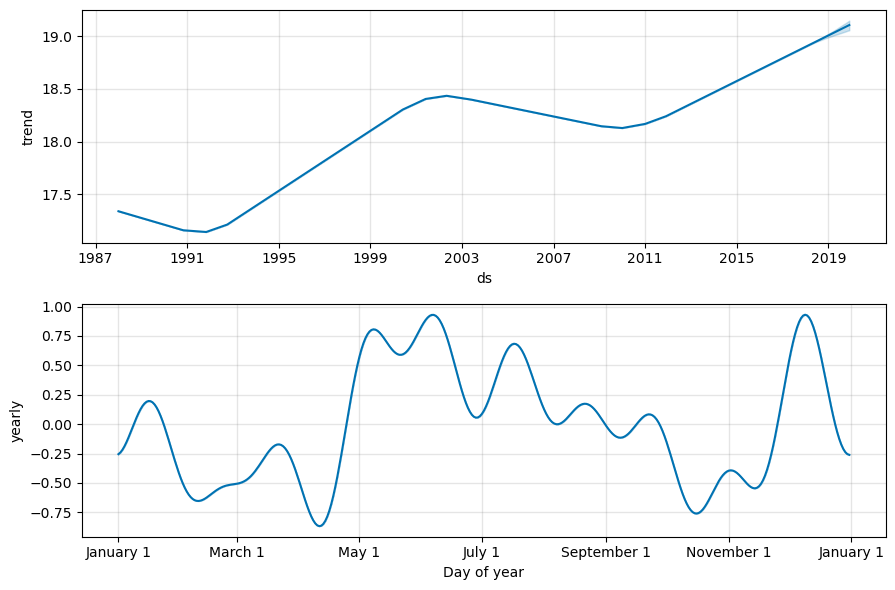

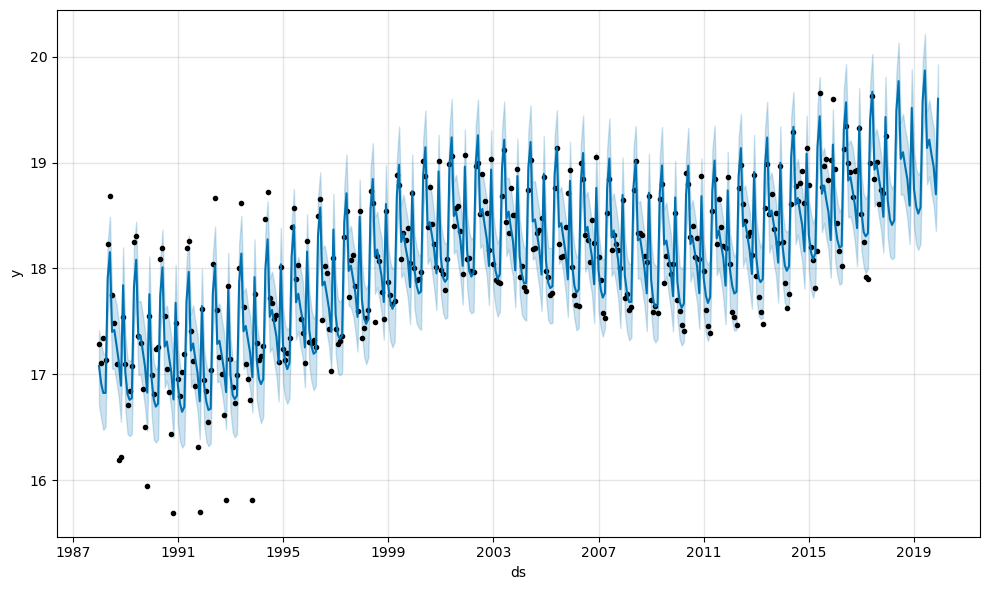

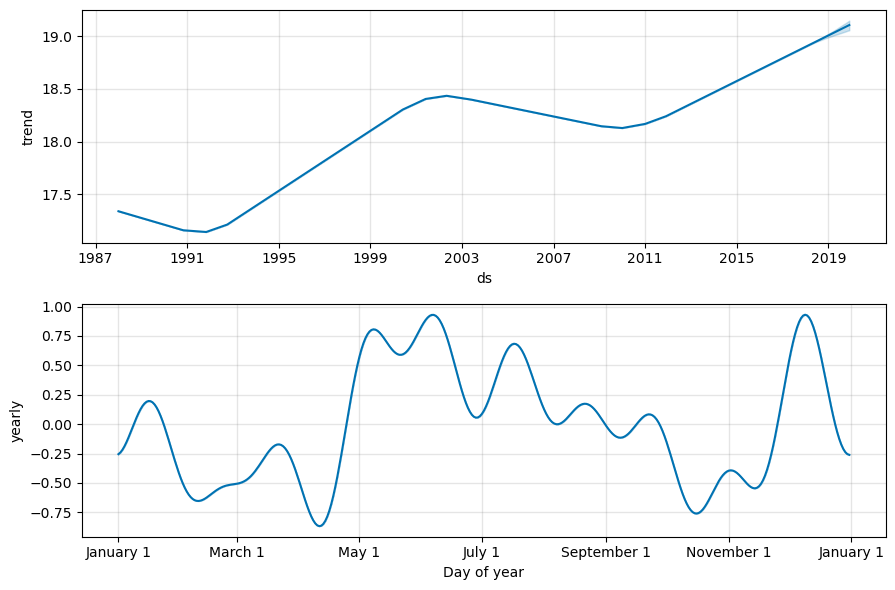

In [7]:
# predict 2018, 2019
future = m.make_future_dataframe(periods = 24, freq="MS")
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [8]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

,ds,yhat,yhat_lower,yhat_upper
0,1988-01-01,17.08,16.75,17.42
1,1988-02-01,16.91,16.59,17.30
2,1988-03-01,16.82,16.49,17.20
3,1988-04-01,16.82,16.46,17.18
4,1988-05-01,17.91,17.54,18.25
...,...,...,...,...
379,2019-08-01,19.22,18.88,19.59
380,2019-09-01,19.08,18.70,19.42
381,2019-10-01,18.96,18.63,19.33
382,2019-11-01,18.70,18.37,19.07


In [9]:
# get actual values for each period, between 1988 and 2017, values in LOG 
actuals = df_year_filter(data_log, 1988, 2019)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

,ds,y-actual
0,1988-01-01,17.28
1,1988-02-01,17.11
2,1988-03-01,17.34
3,1988-04-01,17.13
4,1988-05-01,18.23
...,...,...
379,2019-08-01,19.06
380,2019-09-01,18.96
381,2019-10-01,18.92
382,2019-11-01,18.72


In [10]:
# join actual values and predicted values into one DF
model_eval = predictions.merge(actuals, on='ds', how = 'inner')
model_eval = model_eval.rename(columns={'yhat': 'y-predicted'})
model_eval

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,17.08,16.75,17.42,17.28
1,1988-02-01,16.91,16.59,17.30,17.11
2,1988-03-01,16.82,16.49,17.20,17.34
3,1988-04-01,16.82,16.46,17.18,17.13
4,1988-05-01,17.91,17.54,18.25,18.23
...,...,...,...,...,...
379,2019-08-01,19.22,18.88,19.59,19.06
380,2019-09-01,19.08,18.70,19.42,18.96
381,2019-10-01,18.96,18.63,19.33,18.92
382,2019-11-01,18.70,18.37,19.07,18.72


### Evaluate Model Performance

In [11]:
# return vals to original, take exponent
model_eval_exp = model_eval.copy()
model_eval_exp

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,17.08,16.75,17.42,17.28
1,1988-02-01,16.91,16.59,17.30,17.11
2,1988-03-01,16.82,16.49,17.20,17.34
3,1988-04-01,16.82,16.46,17.18,17.13
4,1988-05-01,17.91,17.54,18.25,18.23
...,...,...,...,...,...
379,2019-08-01,19.22,18.88,19.59,19.06
380,2019-09-01,19.08,18.70,19.42,18.96
381,2019-10-01,18.96,18.63,19.33,18.92
382,2019-11-01,18.70,18.37,19.07,18.72


In [12]:
# return values to original non - log $
model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']] = np.exp(model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']])

In [13]:
model_eval_exp

,ds,y-predicted,yhat_lower,yhat_upper,y-actual
0,1988-01-01,"26,125,427.81","18,871,784.76","36,816,955.27","32,094,345.55"
1,1988-02-01,"22,072,594.23","16,094,941.60","32,519,700.91","26,852,319.99"
2,1988-03-01,"20,225,349.91","14,561,587.12","29,506,568.96","34,003,540.09"
3,1988-04-01,"20,240,672.14","14,024,082.27","28,960,239.33","27,637,080.92"
4,1988-05-01,"59,779,802.07","41,601,971.17","84,638,618.19","82,665,791.27"
...,...,...,...,...,...
379,2019-08-01,"221,450,826.28","158,175,008.11","322,881,467.50","190,136,068.39"
380,2019-09-01,"192,477,647.44","132,226,031.87","272,702,489.30","172,289,856.95"
381,2019-10-01,"171,613,607.06","123,115,618.98","249,435,992.03","165,147,457.37"
382,2019-11-01,"132,153,630.87","94,900,069.60","192,079,992.55","135,296,729.64"


#### Visualise Actuals vs Prediction

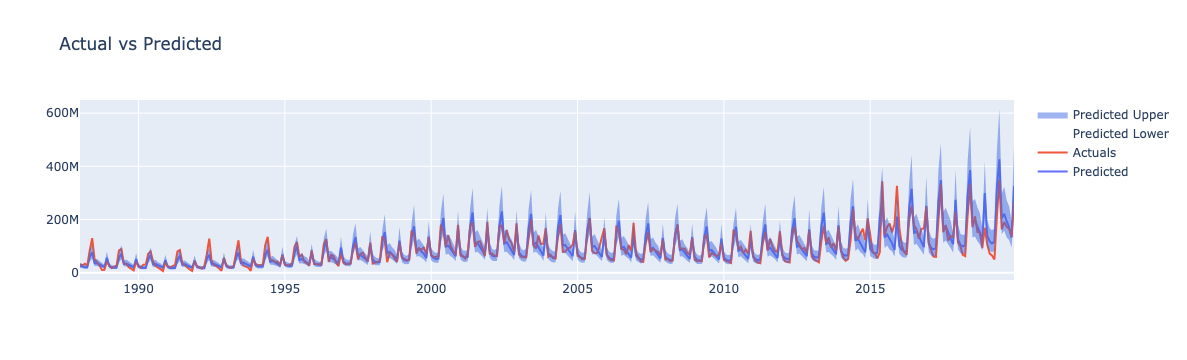

In [18]:
## plot predicted values against actuals, for test range (2018 and 2019 only)
fig = go.Figure()
x_vals1 = df_year_filter(model_eval_exp, 1988, 2019)['ds']


# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-predicted'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')

fig.add_trace(go.Scatter(x=x_vals1, y=model_eval_exp['yhat_upper'],
    fill=None,
    mode='lines',
    line_color='royalblue',line_width=0, name='Predicted Lower'
    ))
fig.add_trace(go.Scatter(
    x=x_vals1, y=model_eval_exp['yhat_lower'],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='royalblue', line_width=0, name='Predicted Upper'))

fig.show()

In [19]:
df_compare = model_eval_exp

## Model 2: Prophet Tuned with CV

### Get Best Params

??? How to use same test train split for comparison?
Train = 1988 to 2017
Test = 2018, 2019

Attempt:
* Use full dataset to get the best params. 
* Re run model with best params, for test, and train seperately, to get seperate scores for easier comparisons

In [20]:
# day range of training data
start_date = train_data['ds'].min().date()
end_date = train_data['ds'].max().date()
end_date-start_date

datetime.timedelta(days=10927)

In [143]:
# ??????????
# Prophet suggested ranges

changepoint_range = [0.001, 0.101,0.201,0.301,0.401,0.5]

print('changepoint_range:',changepoint_range)

seasonality_range=[0.01, 1.01, 3.01, 5.0, 7.01, 10]
print('seasonality_range: ', seasonality_range)

# holidays_range =  np.arange(0.01, 10, 0.5) 
holidays_range=  [0.01, 1.01, 3.01, 5.0, 7.01, 10]
print('holidays_range: ', holidays_range)

changepoint_range: [0.001, 0.101, 0.201, 0.301, 0.401, 0.5]
seasonality_range:  [0.01, 1.01, 3.01, 5.0, 7.01, 10]
holidays_range:  [0.01, 1.01, 3.01, 5.0, 7.01, 10]


In [144]:
param_grid = {  
    'changepoint_prior_scale': changepoint_range,
    'seasonality_prior_scale': seasonality_range,
    # 'holidays_prior_scale': holidays_range,
    'seasonality_mode':['additive', 'multiplicative'], 
    'yearly_seasonality': [True, False]    
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# all_params


QUESTION: 
* run model for entire data or just training range set given CV?
* default code df_cv value at index 0 meaning? 
* for each loop df_p returns RMSE's for many time horizons how to get one value ?
    * reconclie df_p, vs df_cv meaning
    * take average of all RMSE's in the loop (over different horizons)

In [127]:
print(rmses, mapes, rmses_avg, mapes_avg)

[] [] [] []


In [146]:
# # Use cross-validationa to evaluate all parameters
## takes ~~3 minutes to run
cutoffs = pd.to_datetime(['2018-01-01', '2019-01-01']) # manually set dates for new prediction
rmses = []  # Store the RMSEs for each params here
mapes = []# Store the MAPES for each params here
rmses_avg = [] # to compare, the avg rmse for all horizons
mapes_avg = [] # to compare, the avg MAPE for all horizons
for params in all_params:
    print(params)
    m = Prophet(**params).fit(model_data_grouped)  # Fit model with given params ??????
    # train from 1988 to 2017 
    # then after 2017, predict one year out every on Jan 1 2018, and Jan 1 2019
    df_cv = cross_validation(m, initial='10593 days', period='365 days', horizon = '365 days', parallel="processes", cutoffs=cutoffs)
    # convert back from log now??? 
    print(df_cv)
    # df_cv[['yhat', 'yhat_lower','yhat_upper','y']] = np.exp(df_cv[['yhat', 'yhat_lower','yhat_upper','y']]) # ????
    # print(df_cv)
    # get metrics for overall predictions made using CV, not just on one horizon
    rmse_val = np.sqrt(mean_squared_error(df_cv['y'],df_cv['yhat']))
    mape_val = mean_absolute_percentage_error(df_cv['y'],df_cv['yhat'])
    df_p = performance_metrics(df_cv, rolling_window=1)
    print(df_p)
    rmses.append(rmse_val)
    mapes.append(mape_val)
    rmses_avg.append(df_p['rmse'].mean())
    mapes_avg.append(df_p['mape'].mean())

14:52:56 - cmdstanpy - INFO - Chain [1] start processing
14:52:56 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True}


14:52:57 - cmdstanpy - INFO - Chain [1] start processing
14:52:57 - cmdstanpy - INFO - Chain [1] start processing
14:52:57 - cmdstanpy - INFO - Chain [1] done processing
14:52:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:52:57 - cmdstanpy - INFO - Chain [1] done processing
14:52:57 - cmdstanpy - INFO - Chain [1] start processing
14:52:57 - cmdstanpy - INFO - Chain [1] done processing
14:52:57 - cmdstanpy - INFO - Chain [1] start processing
14:52:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 110,550,097.67  69,612,830.38 152,597,473.61  98,741,054.26   
1  2018-03-01 105,984,480.60  66,680,989.17 149,178,529.88  67,438,386.00   
2  2018-04-01 104,785,548.42  63,611,722.95 146,384,555.74  62,713,512.57   
3  2018-05-01 168,920,114.95 128,793,641.41 207,251,080.79 214,656,623.05   
4  2018-06-01 200,013,429.55 159,067,155.00 240,707,494.07 332,987,171.41   
5  2018-07-01 132,518,423.08  93,836,699.22 173,098,794.60 171,257,481.32   
6  2018-08-01 139,374,411.35  99,560,334.87 180,758,142.44 211,866,990.47   
7  2018-09-01 132,529,789.31  94,648,975.19 173,664,156.65 153,366,691.92   
8  2018-10-01 131,169,726.73  86,381,777.31 171,618,135.98 151,565,834.70   
9  2018-11-01 125,625,165.93  86,971,457.26 168,304,641.70  92,707,416.91   
10 2018-12-01 182,328,739.89 142,763,212.53 221,980,535.92 169,260,055.54   
11 2019-01-01 121,536,462.59  82,834,356.06 161,327,196.53 106,274,121.40   

14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
14:52:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 78,548,488.35 211,436,244.57  98,741,054.26   
1  2018-03-01 142,532,049.77 75,339,115.46 204,694,522.96  67,438,386.00   
2  2018-04-01 142,797,009.01 82,701,723.75 206,833,833.22  62,713,512.57   
3  2018-05-01 143,053,421.17 81,707,591.33 209,058,271.11 214,656,623.05   
4  2018-06-01 143,318,380.40 84,512,682.47 212,960,382.18 332,987,171.41   
5  2018-07-01 143,574,792.57 76,614,277.56 207,226,251.62 171,257,481.32   
6  2018-08-01 143,839,751.80 78,887,708.90 206,907,048.40 211,866,990.47   
7  2018-09-01 144,104,711.04 76,659,529.52 214,246,072.57 153,366,691.92   
8  2018-10-01 144,361,123.20 79,888,402.72 210,540,199.09 151,565,834.70   
9  2018-11-01 144,626,082.43 78,670,558.69 209,374,362.04  92,707,416.91   
10 2018-12-01 144,882,494.60 82,297,487.00 208,156,292.80 169,260,055.54   
11 2019-01-01 145,147,453.83 78,404,784.03 213,423,469.96 106,274,121.40   
12 2019-02-0

14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
14:52:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:52:58 - cmdstanpy - INFO - Chain [1] done processing
14:52:58 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing
14:52:59 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 139,185,302.11  84,445,967.69 198,114,527.44  98,741,054.26   
1  2018-03-01 137,300,250.44  78,988,679.47 197,015,910.32  67,438,386.00   
2  2018-04-01 136,289,631.19  76,636,516.42 192,656,192.50  62,713,512.57   
3  2018-05-01 150,595,359.80  91,704,077.38 210,376,614.20 214,656,623.05   
4  2018-06-01 158,180,849.71  96,793,801.65 218,994,300.11 332,987,171.41   
5  2018-07-01 142,237,456.88  87,116,752.04 201,370,017.41 171,257,481.32   
6  2018-08-01 144,320,977.55  85,431,074.02 208,000,241.44 211,866,990.47   
7  2018-09-01 143,062,472.97  80,639,710.68 203,386,443.07 153,366,691.92   
8  2018-10-01 143,908,954.46  83,693,078.15 204,646,601.59 151,565,834.70   
9  2018-11-01 143,422,426.57  84,748,152.20 204,125,108.21  92,707,416.91   
10 2018-12-01 158,046,535.78  99,691,376.33 215,793,250.51 169,260,055.54   
11 2019-01-01 143,796,895.38  86,316,145.49 205,543,978.88 106,274,121.40   

14:52:59 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing
14:52:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:52:59 - cmdstanpy - INFO - Chain [1] done processing
14:52:59 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing
14:52:59 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 76,809,954.37 209,593,588.61  98,741,054.26   
1  2018-03-01 142,532,049.77 79,311,765.99 205,635,413.06  67,438,386.00   
2  2018-04-01 142,797,009.01 74,776,009.56 206,164,232.35  62,713,512.57   
3  2018-05-01 143,053,421.17 80,084,566.04 209,371,739.18 214,656,623.05   
4  2018-06-01 143,318,380.40 74,980,666.01 209,764,079.26 332,987,171.41   
5  2018-07-01 143,574,792.57 81,494,308.99 210,629,931.86 171,257,481.32   
6  2018-08-01 143,839,751.80 79,113,203.58 212,221,350.78 211,866,990.47   
7  2018-09-01 144,104,711.04 84,630,675.98 212,748,700.22 153,366,691.92   
8  2018-10-01 144,361,123.20 83,301,311.36 214,020,433.99 151,565,834.70   
9  2018-11-01 144,626,082.43 81,760,003.16 211,691,579.81  92,707,416.91   
10 2018-12-01 144,882,494.60 76,814,274.69 211,533,005.09 169,260,055.54   
11 2019-01-01 145,147,453.83 76,314,911.02 211,372,634.81 106,274,121.40   
12 2019-02-0

14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  91,794,750.96  33,695,052.12 153,709,919.10  98,741,054.26   
1  2018-03-01  88,829,957.00  28,407,042.96 147,721,618.71  67,438,386.00   
2  2018-04-01  89,835,520.28  30,394,866.94 151,264,078.29  62,713,512.57   
3  2018-05-01 169,964,034.12 107,026,170.66 228,300,732.45 214,656,623.05   
4  2018-06-01 210,326,628.13 156,114,555.71 272,414,026.19 332,987,171.41   
5  2018-07-01 128,140,141.48  68,111,576.36 190,230,889.73 171,257,481.32   
6  2018-08-01 135,703,884.36  77,972,680.26 193,748,770.63 211,866,990.47   
7  2018-09-01 125,927,017.69  60,546,332.26 184,812,339.33 153,366,691.92   
8  2018-10-01 122,435,036.07  65,184,116.36 178,943,780.40 151,565,834.70   
9  2018-11-01 114,422,285.81  51,583,894.46 169,181,625.18  92,707,416.91   
10 2018-12-01 182,607,830.48 122,891,328.54 245,258,090.62 169,260,055.54   
11 2019-01-01 105,981,579.50  44,615,645.76 165,455,055.61 106,274,121.40   

14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
14:53:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 78,478,709.24 206,500,140.80  98,741,054.26   
1  2018-03-01 142,532,049.77 73,275,908.62 207,027,437.20  67,438,386.00   
2  2018-04-01 142,797,009.01 75,004,215.44 207,127,116.58  62,713,512.57   
3  2018-05-01 143,053,421.17 81,898,093.12 206,690,107.17 214,656,623.05   
4  2018-06-01 143,318,380.40 76,640,290.35 203,649,836.46 332,987,171.41   
5  2018-07-01 143,574,792.57 78,215,344.06 208,673,441.13 171,257,481.32   
6  2018-08-01 143,839,751.80 79,846,336.45 212,256,567.70 211,866,990.47   
7  2018-09-01 144,104,711.04 76,599,176.29 207,338,567.76 153,366,691.92   
8  2018-10-01 144,361,123.20 78,094,388.28 206,183,697.99 151,565,834.70   
9  2018-11-01 144,626,082.43 80,892,858.10 214,802,284.03  92,707,416.91   
10 2018-12-01 144,882,494.60 76,155,731.87 204,467,234.38 169,260,055.54   
11 2019-01-01 145,147,453.83 75,293,923.51 214,903,993.37 106,274,121.40   
12 2019-02-0

14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
14:53:01 - cmdstanpy - INFO - Chain [1] done processing
14:53:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:01 - cmdstanpy - INFO - Chain [1] start processing
14:53:02 - cmdstanpy - INFO - Chain [1] done processing
14:53:02 - cmdstanpy - INFO - Chain [1] start processing
14:53:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 136,844,783.02  80,165,038.17 195,670,494.79  98,741,054.26   
1  2018-03-01 134,303,733.90  77,190,916.54 194,055,997.44  67,438,386.00   
2  2018-04-01 132,903,419.35  77,235,821.05 190,918,268.35  62,713,512.57   
3  2018-05-01 151,546,704.85  94,693,634.72 210,406,744.24 214,656,623.05   
4  2018-06-01 161,397,055.14  98,924,869.70 221,382,883.78 332,987,171.41   
5  2018-07-01 140,448,417.83  88,486,973.65 197,259,041.63 171,257,481.32   
6  2018-08-01 143,092,586.98  79,708,544.65 205,966,123.79 211,866,990.47   
7  2018-09-01 141,357,403.68  81,318,758.79 199,521,428.81 153,366,691.92   
8  2018-10-01 142,385,405.93  80,202,717.36 198,980,391.10 151,565,834.70   
9  2018-11-01 141,667,052.52  85,284,468.64 200,181,997.36  92,707,416.91   
10 2018-12-01 160,730,516.55  98,240,579.97 217,837,745.57 169,260,055.54   
11 2019-01-01 141,996,295.10  82,616,378.04 203,707,617.20 106,274,121.40   

14:53:03 - cmdstanpy - INFO - Chain [1] start processing
14:53:03 - cmdstanpy - INFO - Chain [1] start processing
14:53:03 - cmdstanpy - INFO - Chain [1] done processing
14:53:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:03 - cmdstanpy - INFO - Chain [1] start processing
14:53:03 - cmdstanpy - INFO - Chain [1] done processing
14:53:03 - cmdstanpy - INFO - Chain [1] done processing
14:53:03 - cmdstanpy - INFO - Chain [1] start processing
14:53:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 78,781,002.11 212,429,834.48  98,741,054.26   
1  2018-03-01 142,532,049.77 72,499,642.93 211,344,733.21  67,438,386.00   
2  2018-04-01 142,797,009.01 79,019,524.13 208,629,273.33  62,713,512.57   
3  2018-05-01 143,053,421.17 80,075,113.27 208,662,121.26 214,656,623.05   
4  2018-06-01 143,318,380.40 78,842,312.60 210,515,558.72 332,987,171.41   
5  2018-07-01 143,574,792.57 83,172,994.02 211,893,919.13 171,257,481.32   
6  2018-08-01 143,839,751.80 80,850,750.93 211,477,266.09 211,866,990.47   
7  2018-09-01 144,104,711.04 71,363,486.82 211,591,701.05 153,366,691.92   
8  2018-10-01 144,361,123.20 77,456,585.62 207,396,473.15 151,565,834.70   
9  2018-11-01 144,626,082.43 83,961,002.61 214,113,293.78  92,707,416.91   
10 2018-12-01 144,882,494.60 85,929,545.58 208,813,594.49 169,260,055.54   
11 2019-01-01 145,147,453.83 77,681,504.99 209,038,928.82 106,274,121.40   
12 2019-02-0

14:53:03 - cmdstanpy - INFO - Chain [1] start processing
14:53:03 - cmdstanpy - INFO - Chain [1] start processing
14:53:03 - cmdstanpy - INFO - Chain [1] done processing
14:53:03 - cmdstanpy - INFO - Chain [1] done processing
14:53:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:03 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  91,881,421.97  32,597,116.13 151,255,467.19  98,741,054.26   
1  2018-03-01  88,288,325.17  32,642,745.35 148,003,095.49  67,438,386.00   
2  2018-04-01  88,833,330.86  30,476,928.75 149,318,844.14  62,713,512.57   
3  2018-05-01 171,595,903.53 114,826,951.90 228,712,071.60 214,656,623.05   
4  2018-06-01 212,982,105.88 153,619,032.52 269,718,516.22 332,987,171.41   
5  2018-07-01 127,571,868.19  69,949,692.83 185,499,040.79 171,257,481.32   
6  2018-08-01 135,564,174.47  76,009,397.92 192,641,649.72 211,866,990.47   
7  2018-09-01 125,649,372.10  66,936,689.64 188,015,169.60 153,366,691.92   
8  2018-10-01 122,387,045.25  66,893,054.06 179,070,907.80 151,565,834.70   
9  2018-11-01 114,350,804.95  58,253,966.10 173,401,428.45  92,707,416.91   
10 2018-12-01 185,379,388.64 124,597,507.33 245,175,106.74 169,260,055.54   
11 2019-01-01 106,308,972.21  43,621,384.67 164,752,446.80 106,274,121.40   

14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] done processing
14:53:04 - cmdstanpy - INFO - Chain [1] start processing
14:53:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 76,808,302.73 206,250,208.41  98,741,054.26   
1  2018-03-01 142,532,049.77 76,599,251.42 208,465,276.04  67,438,386.00   
2  2018-04-01 142,797,009.01 79,148,380.00 206,593,418.95  62,713,512.57   
3  2018-05-01 143,053,421.17 75,592,332.57 210,990,749.98 214,656,623.05   
4  2018-06-01 143,318,380.40 81,614,460.68 205,081,697.75 332,987,171.41   
5  2018-07-01 143,574,792.57 83,402,500.00 208,530,427.26 171,257,481.32   
6  2018-08-01 143,839,751.80 76,452,891.87 210,582,636.46 211,866,990.47   
7  2018-09-01 144,104,711.04 79,501,669.33 201,157,997.69 153,366,691.92   
8  2018-10-01 144,361,123.20 77,188,473.27 210,869,237.40 151,565,834.70   
9  2018-11-01 144,626,082.43 78,406,953.69 208,595,503.26  92,707,416.91   
10 2018-12-01 144,882,494.60 78,781,339.70 205,491,181.47 169,260,055.54   
11 2019-01-01 145,147,453.83 79,306,352.46 211,514,551.25 106,274,121.40   
12 2019-02-0

14:53:05 - cmdstanpy - INFO - Chain [1] start processing
14:53:05 - cmdstanpy - INFO - Chain [1] start processing
14:53:05 - cmdstanpy - INFO - Chain [1] done processing
14:53:05 - cmdstanpy - INFO - Chain [1] done processing
14:53:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:05 - cmdstanpy - INFO - Chain [1] start processing
14:53:05 - cmdstanpy - INFO - Chain [1] done processing
14:53:05 - cmdstanpy - INFO - Chain [1] start processing
14:53:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 136,846,060.36  81,825,475.77 199,904,127.16  98,741,054.26   
1  2018-03-01 134,304,992.18  76,008,220.67 191,483,062.74  67,438,386.00   
2  2018-04-01 132,904,670.23  72,637,082.42 194,379,638.14  62,713,512.57   
3  2018-05-01 151,548,170.95  91,448,931.26 210,575,934.66 214,656,623.05   
4  2018-06-01 161,398,631.54 103,262,858.18 217,399,355.56 332,987,171.41   
5  2018-07-01 140,449,757.08  76,889,218.49 198,124,776.36 171,257,481.32   
6  2018-08-01 143,093,916.71  83,643,037.81 199,707,479.56 211,866,990.47   
7  2018-09-01 141,358,728.13  81,802,404.85 197,102,102.99 153,366,691.92   
8  2018-10-01 142,386,750.42  85,494,369.18 201,832,751.12 151,565,834.70   
9  2018-11-01 141,668,386.92  81,443,932.97 202,584,462.03  92,707,416.91   
10 2018-12-01 160,732,085.13 104,689,180.43 213,809,318.82 169,260,055.54   
11 2019-01-01 141,997,658.88  86,383,663.19 199,731,050.10 106,274,121.40   

14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 81,929,907.64 208,514,594.44  98,741,054.26   
1  2018-03-01 142,532,049.77 75,378,068.16 207,087,044.29  67,438,386.00   
2  2018-04-01 142,797,009.01 76,395,515.31 205,401,319.16  62,713,512.57   
3  2018-05-01 143,053,421.17 76,821,371.11 212,986,929.17 214,656,623.05   
4  2018-06-01 143,318,380.40 77,363,335.29 209,730,303.54 332,987,171.41   
5  2018-07-01 143,574,792.57 84,022,938.03 207,779,802.13 171,257,481.32   
6  2018-08-01 143,839,751.80 75,162,677.77 208,877,442.61 211,866,990.47   
7  2018-09-01 144,104,711.04 76,752,916.14 206,338,763.07 153,366,691.92   
8  2018-10-01 144,361,123.20 75,271,451.23 213,202,929.52 151,565,834.70   
9  2018-11-01 144,626,082.43 80,958,117.77 208,126,820.35  92,707,416.91   
10 2018-12-01 144,882,494.60 83,704,665.98 208,454,846.85 169,260,055.54   
11 2019-01-01 145,147,453.83 83,018,612.98 211,856,418.24 106,274,121.40   
12 2019-02-0

14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:07 - cmdstanpy - INFO - Chain [1] done processing
14:53:07 - cmdstanpy - INFO - Chain [1] start processing
14:53:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  91,862,696.47  31,696,058.54 151,502,606.55  98,741,054.26   
1  2018-03-01  88,307,090.63  27,706,647.82 146,293,667.39  67,438,386.00   
2  2018-04-01  88,878,154.35  27,536,987.59 144,071,033.88  62,713,512.57   
3  2018-05-01 171,489,582.37 111,869,621.25 227,560,959.71 214,656,623.05   
4  2018-06-01 212,818,066.88 150,259,629.55 271,234,161.60 332,987,171.41   
5  2018-07-01 127,591,931.94  71,262,477.34 184,258,487.70 171,257,481.32   
6  2018-08-01 135,559,171.43  76,911,072.90 194,350,539.39 211,866,990.47   
7  2018-09-01 125,652,142.49  68,350,265.33 179,376,231.29 153,366,691.92   
8  2018-10-01 122,376,611.64  62,265,672.77 179,714,955.85 151,565,834.70   
9  2018-11-01 114,342,518.86  53,014,970.97 173,265,890.86  92,707,416.91   
10 2018-12-01 185,208,787.43 124,963,661.66 245,476,955.62 169,260,055.54   
11 2019-01-01 106,276,049.90  47,804,557.92 169,856,127.27 106,274,121.40   

14:53:07 - cmdstanpy - INFO - Chain [1] start processing
14:53:07 - cmdstanpy - INFO - Chain [1] start processing
14:53:07 - cmdstanpy - INFO - Chain [1] done processing
14:53:07 - cmdstanpy - INFO - Chain [1] done processing
14:53:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:07 - cmdstanpy - INFO - Chain [1] start processing
14:53:07 - cmdstanpy - INFO - Chain [1] done processing
14:53:07 - cmdstanpy - INFO - Chain [1] start processing
14:53:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 77,245,571.93 208,955,302.30  98,741,054.26   
1  2018-03-01 142,532,049.77 76,910,801.56 208,995,656.62  67,438,386.00   
2  2018-04-01 142,797,009.01 79,663,662.27 209,633,127.52  62,713,512.57   
3  2018-05-01 143,053,421.17 77,542,792.07 208,188,424.28 214,656,623.05   
4  2018-06-01 143,318,380.40 77,766,676.18 209,645,783.63 332,987,171.41   
5  2018-07-01 143,574,792.57 82,035,769.27 207,900,665.20 171,257,481.32   
6  2018-08-01 143,839,751.80 80,213,689.53 213,204,228.42 211,866,990.47   
7  2018-09-01 144,104,711.04 79,912,961.42 207,111,734.61 153,366,691.92   
8  2018-10-01 144,361,123.20 82,291,671.85 209,366,978.36 151,565,834.70   
9  2018-11-01 144,626,082.43 84,304,411.55 211,976,382.90  92,707,416.91   
10 2018-12-01 144,882,494.60 82,595,863.16 204,566,777.51 169,260,055.54   
11 2019-01-01 145,147,453.83 76,742,939.82 213,860,926.14 106,274,121.40   
12 2019-02-0

14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing
14:53:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:08 - cmdstanpy - INFO - Chain [1] done processing
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing
14:53:08 - cmdstanpy - INFO - Chain [1] start processing
14:53:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 136,845,739.30  81,298,218.19 194,125,056.49  98,741,054.26   
1  2018-03-01 134,304,679.13  75,257,353.25 187,876,165.78  67,438,386.00   
2  2018-04-01 132,904,359.86  72,149,028.60 188,337,779.43  62,713,512.57   
3  2018-05-01 151,547,816.31  90,848,439.23 207,767,058.03 214,656,623.05   
4  2018-06-01 161,398,256.17 101,323,988.86 220,733,097.04 332,987,171.41   
5  2018-07-01 140,449,432.69  81,706,004.69 197,312,446.24 171,257,481.32   
6  2018-08-01 143,093,585.60  86,412,495.86 198,782,660.71 211,866,990.47   
7  2018-09-01 141,358,400.28  83,196,336.50 201,725,934.28 153,366,691.92   
8  2018-10-01 142,386,422.31  82,582,187.44 204,648,484.01 151,565,834.70   
9  2018-11-01 141,668,062.75  83,287,474.84 198,237,363.44  92,707,416.91   
10 2018-12-01 160,731,716.58 103,621,447.25 218,991,108.16 169,260,055.54   
11 2019-01-01 141,997,332.54  82,673,094.86 201,710,259.53 106,274,121.40   

14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing
14:53:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing
14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 76,108,643.13 205,918,030.92  98,741,054.26   
1  2018-03-01 142,532,049.77 79,523,395.43 210,774,069.16  67,438,386.00   
2  2018-04-01 142,797,009.01 77,173,077.71 207,827,490.99  62,713,512.57   
3  2018-05-01 143,053,421.17 79,468,584.99 207,137,116.71 214,656,623.05   
4  2018-06-01 143,318,380.40 79,731,255.51 212,682,773.35 332,987,171.41   
5  2018-07-01 143,574,792.57 80,008,095.31 210,102,206.59 171,257,481.32   
6  2018-08-01 143,839,751.80 80,469,872.20 206,679,640.29 211,866,990.47   
7  2018-09-01 144,104,711.04 72,977,662.36 209,566,554.95 153,366,691.92   
8  2018-10-01 144,361,123.20 74,188,544.42 210,235,325.86 151,565,834.70   
9  2018-11-01 144,626,082.43 82,032,932.37 209,828,925.41  92,707,416.91   
10 2018-12-01 144,882,494.60 78,631,044.22 208,897,054.12 169,260,055.54   
11 2019-01-01 145,147,453.83 83,014,172.12 211,399,466.48 106,274,121.40   
12 2019-02-0

14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing
14:53:09 - cmdstanpy - INFO - Chain [1] done processing
14:53:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:10 - cmdstanpy - INFO - Chain [1] done processing
14:53:10 - cmdstanpy - INFO - Chain [1] start processing
14:53:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  91,979,194.66  30,711,727.57 153,134,965.79  98,741,054.26   
1  2018-03-01  88,154,472.17  32,206,345.80 150,858,759.86  67,438,386.00   
2  2018-04-01  88,534,471.85  27,801,954.49 148,321,473.71  62,713,512.57   
3  2018-05-01 172,249,972.59 111,139,217.89 234,102,820.80 214,656,623.05   
4  2018-06-01 214,003,383.10 156,926,656.85 276,609,985.15 332,987,171.41   
5  2018-07-01 127,430,118.12  70,815,051.17 187,560,925.78 171,257,481.32   
6  2018-08-01 135,578,758.50  77,397,832.42 192,790,541.34 211,866,990.47   
7  2018-09-01 125,614,614.32  64,602,271.84 187,565,068.55 153,366,691.92   
8  2018-10-01 122,435,410.99  62,833,122.31 178,695,045.41 151,565,834.70   
9  2018-11-01 114,388,669.11  50,443,349.49 171,932,144.23  92,707,416.91   
10 2018-12-01 186,442,864.41 129,309,147.01 248,758,777.13 169,260,055.54   
11 2019-01-01 106,496,601.28  45,875,634.24 164,333,516.97 106,274,121.40   

14:53:10 - cmdstanpy - INFO - Chain [1] start processing
14:53:10 - cmdstanpy - INFO - Chain [1] start processing
14:53:10 - cmdstanpy - INFO - Chain [1] done processing
14:53:10 - cmdstanpy - INFO - Chain [1] done processing
14:53:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:10 - cmdstanpy - INFO - Chain [1] start processing
14:53:10 - cmdstanpy - INFO - Chain [1] done processing
14:53:10 - cmdstanpy - INFO - Chain [1] start processing
14:53:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 79,707,485.09 208,641,415.41  98,741,054.26   
1  2018-03-01 142,532,049.77 76,826,902.84 211,012,631.81  67,438,386.00   
2  2018-04-01 142,797,009.01 77,141,699.62 208,885,031.57  62,713,512.57   
3  2018-05-01 143,053,421.17 78,076,505.54 212,289,019.61 214,656,623.05   
4  2018-06-01 143,318,380.40 76,467,972.43 211,073,082.91 332,987,171.41   
5  2018-07-01 143,574,792.57 78,264,355.89 209,591,741.18 171,257,481.32   
6  2018-08-01 143,839,751.80 80,093,032.38 211,994,905.12 211,866,990.47   
7  2018-09-01 144,104,711.04 76,810,657.43 209,197,050.62 153,366,691.92   
8  2018-10-01 144,361,123.20 79,167,546.89 205,262,265.22 151,565,834.70   
9  2018-11-01 144,626,082.43 78,295,424.00 208,865,128.80  92,707,416.91   
10 2018-12-01 144,882,494.60 81,981,839.62 208,907,454.63 169,260,055.54   
11 2019-01-01 145,147,453.83 80,374,808.75 207,755,140.66 106,274,121.40   
12 2019-02-0

14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing
14:53:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing
14:53:11 - cmdstanpy - INFO - Chain [1] start processing
14:53:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 136,845,685.45  78,237,233.35 190,171,262.52  98,741,054.26   
1  2018-03-01 134,304,567.45  75,366,114.76 193,866,543.42  67,438,386.00   
2  2018-04-01 132,904,245.74  71,578,788.23 190,226,081.62  62,713,512.57   
3  2018-05-01 151,547,904.30  98,229,201.27 204,923,313.86 214,656,623.05   
4  2018-06-01 161,398,436.19 104,199,730.31 220,071,634.86 332,987,171.41   
5  2018-07-01 140,449,376.01  78,506,941.96 202,179,786.43 171,257,481.32   
6  2018-08-01 143,093,579.58  84,014,316.95 200,748,163.03 211,866,990.47   
7  2018-09-01 141,358,346.21  77,453,005.68 201,459,778.24 153,366,691.92   
8  2018-10-01 142,386,388.78  83,463,475.47 201,464,814.90 151,565,834.70   
9  2018-11-01 141,668,029.55  81,662,718.77 204,234,232.45  92,707,416.91   
10 2018-12-01 160,731,870.58 100,276,915.49 220,688,501.62 169,260,055.54   
11 2019-01-01 141,997,269.00  86,602,117.10 198,601,007.30 106,274,121.40   

14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:12 - cmdstanpy - INFO - Chain [1] done processing
14:53:12 - cmdstanpy - INFO - Chain [1] done processing
14:53:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:12 - cmdstanpy - INFO - Chain [1] done processing
14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 76,111,887.28 207,077,143.05  98,741,054.26   
1  2018-03-01 142,532,049.77 77,513,110.93 205,762,409.16  67,438,386.00   
2  2018-04-01 142,797,009.01 77,679,014.34 204,138,707.62  62,713,512.57   
3  2018-05-01 143,053,421.17 77,298,526.77 208,152,987.90 214,656,623.05   
4  2018-06-01 143,318,380.40 74,846,528.80 206,389,437.41 332,987,171.41   
5  2018-07-01 143,574,792.57 77,443,299.56 207,942,989.95 171,257,481.32   
6  2018-08-01 143,839,751.80 78,186,390.41 210,755,750.04 211,866,990.47   
7  2018-09-01 144,104,711.04 79,068,981.43 208,687,247.39 153,366,691.92   
8  2018-10-01 144,361,123.20 77,605,598.83 212,079,062.35 151,565,834.70   
9  2018-11-01 144,626,082.43 77,113,745.24 204,290,255.43  92,707,416.91   
10 2018-12-01 144,882,494.60 78,208,110.34 209,510,927.33 169,260,055.54   
11 2019-01-01 145,147,453.83 79,975,395.42 207,244,300.36 106,274,121.40   
12 2019-02-0

14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:12 - cmdstanpy - INFO - Chain [1] done processing
14:53:12 - cmdstanpy - INFO - Chain [1] done processing
14:53:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  92,052,645.23  33,156,910.66 154,931,279.87  98,741,054.26   
1  2018-03-01  88,042,035.26  28,973,924.39 146,616,477.99  67,438,386.00   
2  2018-04-01  88,286,899.58  27,700,625.38 146,691,404.13  62,713,512.57   
3  2018-05-01 172,779,941.48 115,570,637.13 231,857,899.07 214,656,623.05   
4  2018-06-01 214,835,200.72 158,713,619.31 277,917,866.81 332,987,171.41   
5  2018-07-01 127,311,322.01  70,372,519.85 183,179,455.55 171,257,481.32   
6  2018-08-01 135,586,780.13  75,086,398.31 193,362,105.72 211,866,990.47   
7  2018-09-01 125,582,079.98  69,647,221.90 186,173,569.89 153,366,691.92   
8  2018-10-01 122,470,678.46  58,814,465.27 181,892,274.28 151,565,834.70   
9  2018-11-01 114,416,909.16  55,536,970.15 177,893,085.68  92,707,416.91   
10 2018-12-01 187,309,670.18 130,082,468.71 245,979,654.61 169,260,055.54   
11 2019-01-01 106,643,665.96  48,625,984.23 165,439,181.74 106,274,121.40   

14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 76,687,884.63 206,031,099.06  98,741,054.26   
1  2018-03-01 142,532,049.77 76,062,261.93 209,456,363.39  67,438,386.00   
2  2018-04-01 142,797,009.01 84,201,449.83 209,715,866.52  62,713,512.57   
3  2018-05-01 143,053,421.17 75,084,285.09 208,696,752.89 214,656,623.05   
4  2018-06-01 143,318,380.40 74,506,976.93 204,803,199.44 332,987,171.41   
5  2018-07-01 143,574,792.57 78,613,189.72 210,220,429.14 171,257,481.32   
6  2018-08-01 143,839,751.80 75,781,266.72 207,449,495.90 211,866,990.47   
7  2018-09-01 144,104,711.04 81,430,330.39 210,488,609.52 153,366,691.92   
8  2018-10-01 144,361,123.20 81,569,046.69 212,877,699.35 151,565,834.70   
9  2018-11-01 144,626,082.43 73,968,289.94 211,202,786.86  92,707,416.91   
10 2018-12-01 144,882,494.60 74,156,951.27 212,651,502.52 169,260,055.54   
11 2019-01-01 145,147,453.83 78,663,447.72 209,455,003.46 106,274,121.40   
12 2019-02-0

14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 136,845,645.62  75,270,175.87 196,710,015.95  98,741,054.26   
1  2018-03-01 134,304,552.89  71,502,525.26 191,996,573.43  67,438,386.00   
2  2018-04-01 132,904,221.89  74,313,138.78 193,189,645.28  62,713,512.57   
3  2018-05-01 151,547,901.39  92,900,733.73 207,637,045.71 214,656,623.05   
4  2018-06-01 161,398,443.89 105,649,601.68 215,827,116.15 332,987,171.41   
5  2018-07-01 140,449,354.88  81,401,902.76 197,346,296.00 171,257,481.32   
6  2018-08-01 143,093,544.21  84,592,227.69 198,764,460.68 211,866,990.47   
7  2018-09-01 141,358,335.48  82,496,075.92 194,139,409.87 153,366,691.92   
8  2018-10-01 142,386,381.07  80,644,827.68 204,216,449.93 151,565,834.70   
9  2018-11-01 141,668,006.29  81,053,309.38 200,350,938.45  92,707,416.91   
10 2018-12-01 160,731,884.13  99,842,009.21 222,002,848.84 169,260,055.54   
11 2019-01-01 141,997,260.17  81,980,739.58 198,763,975.66 106,274,121.40   

14:53:15 - cmdstanpy - INFO - Chain [1] start processing
14:53:15 - cmdstanpy - INFO - Chain [1] start processing
14:53:15 - cmdstanpy - INFO - Chain [1] done processing
14:53:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:15 - cmdstanpy - INFO - Chain [1] start processing
14:53:15 - cmdstanpy - INFO - Chain [1] done processing
14:53:15 - cmdstanpy - INFO - Chain [1] done processing
14:53:15 - cmdstanpy - INFO - Chain [1] start processing
14:53:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat    yhat_lower     yhat_upper              y  \
0  2018-02-01 142,292,731.75 76,644,258.58 208,227,450.02  98,741,054.26   
1  2018-03-01 142,532,049.77 74,825,925.16 208,806,981.63  67,438,386.00   
2  2018-04-01 142,797,009.01 75,242,251.53 210,354,278.16  62,713,512.57   
3  2018-05-01 143,053,421.17 76,277,224.96 210,169,543.72 214,656,623.05   
4  2018-06-01 143,318,380.40 85,332,236.27 211,365,457.91 332,987,171.41   
5  2018-07-01 143,574,792.57 74,135,798.68 206,159,459.05 171,257,481.32   
6  2018-08-01 143,839,751.80 73,839,985.16 211,394,238.39 211,866,990.47   
7  2018-09-01 144,104,711.04 78,577,067.19 206,223,050.92 153,366,691.92   
8  2018-10-01 144,361,123.20 82,227,408.28 211,525,817.17 151,565,834.70   
9  2018-11-01 144,626,082.43 76,728,765.31 211,802,705.23  92,707,416.91   
10 2018-12-01 144,882,494.60 78,943,071.35 212,001,803.92 169,260,055.54   
11 2019-01-01 145,147,453.83 83,335,805.22 205,564,505.12 106,274,121.40   
12 2019-02-0

14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing
14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 140,348,724.51 108,587,032.78 172,424,133.23  98,741,054.26   
1  2018-03-01 135,866,219.64 104,141,312.47 165,039,519.82  67,438,386.00   
2  2018-04-01 136,007,394.15 107,392,722.27 165,149,667.29  62,713,512.57   
3  2018-05-01 207,312,213.64 175,905,369.20 236,363,750.45 214,656,623.05   
4  2018-06-01 242,127,780.74 211,335,730.40 273,190,515.93 332,987,171.41   
5  2018-07-01 169,163,616.13 137,485,886.28 201,138,588.04 171,257,481.32   
6  2018-08-01 177,351,873.45 146,547,517.03 205,874,409.25 211,866,990.47   
7  2018-09-01 170,162,574.52 138,625,699.63 202,035,514.17 153,366,691.92   
8  2018-10-01 168,851,731.08 138,183,367.68 199,414,345.69 151,565,834.70   
9  2018-11-01 162,823,118.50 131,256,012.54 193,089,704.80  92,707,416.91   
10 2018-12-01 225,025,192.29 193,975,111.85 258,061,105.28 169,260,055.54   
11 2019-01-01 159,941,186.89 131,206,251.64 192,804,213.76 106,274,121.40   

14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing
14:53:16 - cmdstanpy - INFO - Chain [1] start processing
14:53:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58 101,477,555.18 211,632,853.37  98,741,054.26   
1  2018-03-01 154,428,122.18  98,235,300.44 210,971,137.78  67,438,386.00   
2  2018-04-01 155,071,020.78  93,811,024.48 210,918,817.79  62,713,512.57   
3  2018-05-01 155,693,180.71  99,884,192.71 216,396,564.44 214,656,623.05   
4  2018-06-01 156,336,079.30  94,824,748.97 212,728,400.49 332,987,171.41   
5  2018-07-01 156,958,239.23 100,377,105.42 213,332,001.98 171,257,481.32   
6  2018-08-01 157,601,137.82  99,428,665.59 214,482,109.11 211,866,990.47   
7  2018-09-01 158,244,036.42  99,648,061.22 218,918,386.88 153,366,691.92   
8  2018-10-01 158,866,196.35 105,148,280.83 217,470,515.72 151,565,834.70   
9  2018-11-01 159,509,094.94 106,765,236.15 213,973,328.66  92,707,416.91   
10 2018-12-01 160,131,254.87 102,503,054.96 222,523,707.79 169,260,055.54   
11 2019-01-01 160,774,153.46 104,123,053.25 215,826,164.78 106,274,121.40   

14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 156,318,203.13 107,113,549.74 205,682,145.98  98,741,054.26   
1  2018-03-01 153,623,380.62 101,118,198.03 205,864,527.46  67,438,386.00   
2  2018-04-01 152,383,370.03 100,947,221.32 199,536,823.62  62,713,512.57   
3  2018-05-01 175,519,908.38 127,158,495.11 229,354,892.74 214,656,623.05   
4  2018-06-01 188,644,509.07 138,297,150.20 244,289,367.42 332,987,171.41   
5  2018-07-01 163,328,215.05 113,167,961.48 217,953,702.12 171,257,481.32   
6  2018-08-01 167,134,386.42 117,972,878.04 218,868,406.80 211,866,990.47   
7  2018-09-01 165,359,208.84 110,685,987.64 218,665,003.28 153,366,691.92   
8  2018-10-01 166,997,175.73 116,983,610.99 218,678,400.54 151,565,834.70   
9  2018-11-01 166,423,470.93 114,085,801.80 217,132,902.06  92,707,416.91   
10 2018-12-01 190,650,004.98 141,954,745.27 240,546,898.78 169,260,055.54   
11 2019-01-01 167,187,186.98 115,148,124.71 216,536,829.59 106,274,121.40   

14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing
14:53:17 - cmdstanpy - INFO - Chain [1] start processing
14:53:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  96,531,973.32 205,945,076.17  98,741,054.26   
1  2018-03-01 154,428,122.18  95,587,904.55 212,049,110.72  67,438,386.00   
2  2018-04-01 155,071,020.78  95,162,734.89 217,475,836.43  62,713,512.57   
3  2018-05-01 155,693,180.71  98,735,858.26 211,757,814.80 214,656,623.05   
4  2018-06-01 156,336,079.30  95,789,216.90 212,816,909.47 332,987,171.41   
5  2018-07-01 156,958,239.23 100,218,591.75 212,399,185.70 171,257,481.32   
6  2018-08-01 157,601,137.82  98,599,852.85 214,833,391.43 211,866,990.47   
7  2018-09-01 158,244,036.42 107,882,168.25 213,970,434.86 153,366,691.92   
8  2018-10-01 158,866,196.35 100,239,479.42 217,192,082.27 151,565,834.70   
9  2018-11-01 159,509,094.94 104,514,942.01 216,909,995.93  92,707,416.91   
10 2018-12-01 160,131,254.87  98,323,794.74 215,009,902.49 169,260,055.54   
11 2019-01-01 160,774,153.46 102,908,889.12 219,693,288.00 106,274,121.40   

14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 133,689,858.21 104,964,857.81 162,352,990.23  98,741,054.26   
1  2018-03-01 129,811,561.65 101,387,588.84 159,633,469.09  67,438,386.00   
2  2018-04-01 131,830,996.80 102,752,362.53 161,168,971.53  62,713,512.57   
3  2018-05-01 211,113,482.44 180,470,620.91 240,336,468.21 214,656,623.05   
4  2018-06-01 254,511,327.03 227,207,354.10 284,243,844.05 332,987,171.41   
5  2018-07-01 171,153,672.23 141,109,239.95 200,024,304.77 171,257,481.32   
6  2018-08-01 180,714,331.47 148,987,219.42 210,415,636.31 211,866,990.47   
7  2018-09-01 172,385,812.18 144,027,606.97 202,972,960.54 153,366,691.92   
8  2018-10-01 167,712,993.22 138,010,971.05 197,421,319.08 151,565,834.70   
9  2018-11-01 158,576,141.57 129,169,784.60 185,502,058.62  92,707,416.91   
10 2018-12-01 230,007,173.95 201,054,951.87 260,623,814.73 169,260,055.54   
11 2019-01-01 156,227,816.05 124,597,688.18 185,438,224.06 106,274,121.40   

14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  98,848,528.39 214,319,309.51  98,741,054.26   
1  2018-03-01 154,428,122.18  96,942,040.04 210,730,195.21  67,438,386.00   
2  2018-04-01 155,071,020.78  98,783,008.29 211,748,879.64  62,713,512.57   
3  2018-05-01 155,693,180.71 100,656,764.39 209,005,839.57 214,656,623.05   
4  2018-06-01 156,336,079.30  98,019,810.51 214,098,699.13 332,987,171.41   
5  2018-07-01 156,958,239.23 101,604,881.90 218,212,927.40 171,257,481.32   
6  2018-08-01 157,601,137.82 101,100,095.82 214,442,217.64 211,866,990.47   
7  2018-09-01 158,244,036.42  99,654,242.26 219,615,824.71 153,366,691.92   
8  2018-10-01 158,866,196.35 102,284,555.94 222,513,805.57 151,565,834.70   
9  2018-11-01 159,509,094.94 104,660,205.84 216,930,268.49  92,707,416.91   
10 2018-12-01 160,131,254.87 101,253,976.41 219,816,989.85 169,260,055.54   
11 2019-01-01 160,774,153.46 105,582,527.56 213,353,186.70 106,274,121.40   

14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  97,796,434.14  71,819,285.23 124,161,716.97  98,741,054.26   
1  2018-03-01  85,078,276.00  59,560,269.89 109,508,172.35  67,438,386.00   
2  2018-04-01  85,223,547.84  57,268,643.08 108,977,417.63  62,713,512.57   
3  2018-05-01 235,902,602.27 208,765,287.39 261,891,087.41 214,656,623.05   
4  2018-06-01 334,628,777.71 309,006,159.08 359,824,572.84 332,987,171.41   
5  2018-07-01 168,733,932.96 142,861,672.99 194,698,253.41 171,257,481.32   
6  2018-08-01 188,765,109.15 165,066,284.93 214,606,385.12 211,866,990.47   
7  2018-09-01 171,239,285.92 145,877,259.71 196,012,793.24 153,366,691.92   
8  2018-10-01 165,644,063.77 140,434,100.44 191,160,172.60 151,565,834.70   
9  2018-11-01 149,564,252.93 123,351,290.04 175,549,179.50  92,707,416.91   
10 2018-12-01 292,518,611.43 267,745,589.06 317,264,690.92 169,260,055.54   
11 2019-01-01 132,629,218.48 104,955,884.81 157,682,321.88 106,274,121.40   

14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  94,690,197.94 211,284,115.05  98,741,054.26   
1  2018-03-01 154,428,122.18  96,734,155.63 209,796,224.43  67,438,386.00   
2  2018-04-01 155,071,020.78  99,329,199.74 212,267,246.67  62,713,512.57   
3  2018-05-01 155,693,180.71  98,400,164.54 211,277,369.55 214,656,623.05   
4  2018-06-01 156,336,079.30  99,622,646.61 214,495,233.22 332,987,171.41   
5  2018-07-01 156,958,239.23 105,215,188.27 214,970,182.15 171,257,481.32   
6  2018-08-01 157,601,137.82 102,867,071.07 214,290,309.46 211,866,990.47   
7  2018-09-01 158,244,036.42  99,108,408.92 221,606,143.79 153,366,691.92   
8  2018-10-01 158,866,196.35 101,788,768.53 217,242,033.52 151,565,834.70   
9  2018-11-01 159,509,094.94 101,587,210.05 217,931,301.19  92,707,416.91   
10 2018-12-01 160,131,254.87 102,164,429.05 215,450,797.52 169,260,055.54   
11 2019-01-01 160,774,153.46 100,399,512.19 224,045,818.19 106,274,121.40   

14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 133,677,273.92 103,410,642.68 164,127,443.43  98,741,054.26   
1  2018-03-01 129,804,306.12 100,203,373.40 160,387,465.81  67,438,386.00   
2  2018-04-01 131,848,464.53 104,221,285.42 159,869,984.08  62,713,512.57   
3  2018-05-01 211,118,676.01 180,694,136.21 239,783,948.36 214,656,623.05   
4  2018-06-01 254,551,784.73 224,801,004.69 286,171,033.49 332,987,171.41   
5  2018-07-01 171,194,460.17 141,815,322.76 199,710,311.98 171,257,481.32   
6  2018-08-01 180,763,876.07 151,832,220.79 211,362,540.14 211,866,990.47   
7  2018-09-01 172,443,119.03 143,695,008.93 202,202,818.01 153,366,691.92   
8  2018-10-01 167,742,320.99 137,426,916.31 200,203,779.06 151,565,834.70   
9  2018-11-01 158,597,424.97 130,445,541.67 189,679,179.23  92,707,416.91   
10 2018-12-01 230,058,807.80 200,195,559.01 260,846,694.24 169,260,055.54   
11 2019-01-01 156,283,977.16 126,988,572.63 185,889,496.77 106,274,121.40   

14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  93,988,557.93 209,124,805.84  98,741,054.26   
1  2018-03-01 154,428,122.18  93,763,411.98 211,811,294.44  67,438,386.00   
2  2018-04-01 155,071,020.78  98,007,416.40 213,981,537.90  62,713,512.57   
3  2018-05-01 155,693,180.71  99,727,645.84 211,627,463.19 214,656,623.05   
4  2018-06-01 156,336,079.30  99,604,107.34 218,220,848.93 332,987,171.41   
5  2018-07-01 156,958,239.23  98,686,367.96 215,539,941.21 171,257,481.32   
6  2018-08-01 157,601,137.82  96,127,344.25 214,617,433.04 211,866,990.47   
7  2018-09-01 158,244,036.42  96,254,957.96 211,819,372.89 153,366,691.92   
8  2018-10-01 158,866,196.35  99,988,623.52 214,685,904.82 151,565,834.70   
9  2018-11-01 159,509,094.94  98,772,442.92 217,210,657.04  92,707,416.91   
10 2018-12-01 160,131,254.87 103,925,921.24 218,570,042.08 169,260,055.54   
11 2019-01-01 160,774,153.46 100,685,828.91 212,460,811.76 106,274,121.40   

14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing
14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  97,930,775.26  71,759,008.72 124,318,207.46  98,741,054.26   
1  2018-03-01  85,190,259.66  57,932,340.56 110,702,946.88  67,438,386.00   
2  2018-04-01  85,253,314.54  58,810,001.04 110,968,253.74  62,713,512.57   
3  2018-05-01 235,709,783.35 209,793,855.66 261,757,624.89 214,656,623.05   
4  2018-06-01 335,618,427.45 310,449,845.82 361,854,604.12 332,987,171.41   
5  2018-07-01 168,965,630.04 142,086,691.74 197,170,422.82 171,257,481.32   
6  2018-08-01 189,140,759.33 162,096,108.46 214,391,953.42 211,866,990.47   
7  2018-09-01 171,804,377.92 145,120,576.60 197,160,577.72 153,366,691.92   
8  2018-10-01 165,729,029.34 138,387,641.57 190,423,405.00 151,565,834.70   
9  2018-11-01 149,419,826.02 121,751,981.41 173,623,660.04  92,707,416.91   
10 2018-12-01 293,124,079.52 267,216,948.54 317,206,683.41 169,260,055.54   
11 2019-01-01 132,934,330.17 105,180,609.24 158,765,671.14 106,274,121.40   

14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing
14:53:21 - cmdstanpy - INFO - Chain [1] start processing
14:53:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  95,682,948.08 206,292,471.62  98,741,054.26   
1  2018-03-01 154,428,122.18  93,975,010.52 214,633,718.91  67,438,386.00   
2  2018-04-01 155,071,020.78  94,303,006.45 214,273,142.50  62,713,512.57   
3  2018-05-01 155,693,180.71  95,758,136.91 211,612,163.20 214,656,623.05   
4  2018-06-01 156,336,079.30  95,330,049.46 212,329,879.91 332,987,171.41   
5  2018-07-01 156,958,239.23 100,167,646.32 215,755,469.21 171,257,481.32   
6  2018-08-01 157,601,137.82 101,622,448.99 216,302,260.18 211,866,990.47   
7  2018-09-01 158,244,036.42 100,566,817.47 212,971,459.59 153,366,691.92   
8  2018-10-01 158,866,196.35 104,018,876.66 217,595,533.13 151,565,834.70   
9  2018-11-01 159,509,094.94 107,288,735.96 217,623,159.31  92,707,416.91   
10 2018-12-01 160,131,254.87 102,625,794.68 213,785,239.22 169,260,055.54   
11 2019-01-01 160,774,153.46 105,106,937.66 218,182,068.67 106,274,121.40   

14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:22 - cmdstanpy - INFO - Chain [1] done processing
14:53:22 - cmdstanpy - INFO - Chain [1] done processing
14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:22 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 134,049,528.89 105,066,880.58 162,190,727.40  98,741,054.26   
1  2018-03-01 130,185,256.42 100,348,683.30 159,562,264.30  67,438,386.00   
2  2018-04-01 132,237,242.11 102,632,211.77 163,151,665.87  62,713,512.57   
3  2018-05-01 211,495,089.00 183,275,657.52 242,238,283.15 214,656,623.05   
4  2018-06-01 254,960,502.72 225,538,581.89 283,297,504.75 332,987,171.41   
5  2018-07-01 171,604,013.02 139,527,379.24 201,356,298.42 171,257,481.32   
6  2018-08-01 181,189,179.53 152,508,567.05 212,856,194.98 211,866,990.47   
7  2018-09-01 172,883,526.07 143,127,499.52 202,925,276.87 153,366,691.92   
8  2018-10-01 168,174,910.96 138,931,261.55 198,491,128.58 151,565,834.70   
9  2018-11-01 159,027,501.92 127,417,440.89 190,637,249.38  92,707,416.91   
10 2018-12-01 230,509,206.05 200,947,608.00 260,821,256.88 169,260,055.54   
11 2019-01-01 156,752,075.47 127,248,379.60 187,243,630.70 106,274,121.40   

14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:22 - cmdstanpy - INFO - Chain [1] done processing
14:53:22 - cmdstanpy - INFO - Chain [1] done processing
14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  97,365,573.38 211,912,148.64  98,741,054.26   
1  2018-03-01 154,428,122.18  96,930,653.26 210,876,125.99  67,438,386.00   
2  2018-04-01 155,071,020.78  96,403,705.53 218,246,286.07  62,713,512.57   
3  2018-05-01 155,693,180.71  99,564,479.45 214,479,399.30 214,656,623.05   
4  2018-06-01 156,336,079.30  96,838,914.01 213,872,175.51 332,987,171.41   
5  2018-07-01 156,958,239.23  99,405,989.11 216,338,283.58 171,257,481.32   
6  2018-08-01 157,601,137.82  98,120,355.75 214,340,620.15 211,866,990.47   
7  2018-09-01 158,244,036.42 103,119,356.10 218,077,348.47 153,366,691.92   
8  2018-10-01 158,866,196.35  98,994,415.28 218,602,486.40 151,565,834.70   
9  2018-11-01 159,509,094.94 101,821,057.47 218,907,387.80  92,707,416.91   
10 2018-12-01 160,131,254.87 103,639,360.67 215,104,615.50 169,260,055.54   
11 2019-01-01 160,774,153.46  98,886,262.48 216,869,165.33 106,274,121.40   

14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing
14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:23 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  98,287,663.90  71,963,975.50 124,450,663.53  98,741,054.26   
1  2018-03-01  85,482,102.95  59,647,832.97 109,391,700.57  67,438,386.00   
2  2018-04-01  85,676,052.17  60,160,023.44 111,545,286.50  62,713,512.57   
3  2018-05-01 233,886,229.14 208,213,567.40 260,680,372.02 214,656,623.05   
4  2018-06-01 338,226,624.94 312,728,219.83 363,324,830.97 332,987,171.41   
5  2018-07-01 168,656,880.53 142,560,771.15 192,566,227.62 171,257,481.32   
6  2018-08-01 189,486,534.43 164,105,199.29 216,663,280.60 211,866,990.47   
7  2018-09-01 173,223,477.59 146,929,306.46 199,437,435.86 153,366,691.92   
8  2018-10-01 164,819,153.98 139,749,149.59 188,930,751.92 151,565,834.70   
9  2018-11-01 147,920,571.20 122,993,229.91 172,856,443.57  92,707,416.91   
10 2018-12-01 294,920,451.35 269,929,851.55 320,215,761.49 169,260,055.54   
11 2019-01-01 134,303,809.05 110,138,138.28 158,637,790.93 106,274,121.40   

14:53:23 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing
14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  98,877,684.37 211,506,635.92  98,741,054.26   
1  2018-03-01 154,428,122.18  96,458,003.43 211,166,686.71  67,438,386.00   
2  2018-04-01 155,071,020.78 100,075,534.43 212,541,670.23  62,713,512.57   
3  2018-05-01 155,693,180.71  94,789,665.16 212,201,124.07 214,656,623.05   
4  2018-06-01 156,336,079.30 100,858,861.06 216,618,481.77 332,987,171.41   
5  2018-07-01 156,958,239.23 100,246,351.25 213,623,209.27 171,257,481.32   
6  2018-08-01 157,601,137.82  98,880,829.71 214,601,305.41 211,866,990.47   
7  2018-09-01 158,244,036.42 101,721,471.87 216,438,329.74 153,366,691.92   
8  2018-10-01 158,866,196.35 101,601,061.22 222,480,471.33 151,565,834.70   
9  2018-11-01 159,509,094.94 102,419,917.37 215,734,974.65  92,707,416.91   
10 2018-12-01 160,131,254.87 103,600,364.84 223,327,482.02 169,260,055.54   
11 2019-01-01 160,774,153.46 100,775,575.37 216,218,846.94 106,274,121.40   

14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing
14:53:24 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 133,639,196.81 103,894,562.48 163,059,655.81  98,741,054.26   
1  2018-03-01 129,798,208.74  99,410,832.28 161,052,605.75  67,438,386.00   
2  2018-04-01 131,818,958.25 101,042,310.88 159,650,522.36  62,713,512.57   
3  2018-05-01 211,062,900.23 182,403,770.61 240,045,102.15 214,656,623.05   
4  2018-06-01 254,488,877.82 225,419,178.87 283,014,036.24 332,987,171.41   
5  2018-07-01 171,110,669.97 142,703,308.38 200,656,699.61 171,257,481.32   
6  2018-08-01 180,672,643.39 150,336,003.21 210,263,592.57 211,866,990.47   
7  2018-09-01 172,344,928.68 142,708,244.92 202,900,331.52 153,366,691.92   
8  2018-10-01 167,641,943.58 138,760,285.57 198,675,429.52 151,565,834.70   
9  2018-11-01 158,492,238.93 128,834,486.26 187,544,481.67  92,707,416.91   
10 2018-12-01 229,952,793.59 201,510,859.62 259,074,495.36 169,260,055.54   
11 2019-01-01 156,194,420.36 125,848,151.65 186,821,299.77 106,274,121.40   

14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  94,393,711.58 209,962,913.10  98,741,054.26   
1  2018-03-01 154,428,122.18 101,148,146.67 214,309,763.50  67,438,386.00   
2  2018-04-01 155,071,020.78  98,206,055.12 211,657,620.40  62,713,512.57   
3  2018-05-01 155,693,180.71  96,741,184.61 214,076,693.64 214,656,623.05   
4  2018-06-01 156,336,079.30  95,739,062.61 214,454,331.27 332,987,171.41   
5  2018-07-01 156,958,239.23  97,655,141.00 213,652,000.63 171,257,481.32   
6  2018-08-01 157,601,137.82 104,718,770.42 215,007,220.25 211,866,990.47   
7  2018-09-01 158,244,036.42 103,845,867.66 218,117,857.84 153,366,691.92   
8  2018-10-01 158,866,196.35 104,048,603.62 215,565,491.03 151,565,834.70   
9  2018-11-01 159,509,094.94 103,349,232.74 220,748,141.01  92,707,416.91   
10 2018-12-01 160,131,254.87 103,656,149.94 219,377,734.77 169,260,055.54   
11 2019-01-01 160,774,153.46 101,690,271.48 216,603,759.10 106,274,121.40   

14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  98,204,465.61  71,985,486.21 123,364,294.49  98,741,054.26   
1  2018-03-01  85,444,651.38  58,100,468.23 111,970,037.55  67,438,386.00   
2  2018-04-01  85,587,727.19  59,902,634.69 110,522,359.86  62,713,512.57   
3  2018-05-01 233,120,178.13 206,543,581.25 259,602,845.76 214,656,623.05   
4  2018-06-01 337,895,825.09 311,805,087.16 362,601,104.64 332,987,171.41   
5  2018-07-01 168,336,816.99 143,878,133.58 193,241,132.73 171,257,481.32   
6  2018-08-01 189,226,323.30 162,939,785.77 214,415,959.12 211,866,990.47   
7  2018-09-01 173,116,347.90 146,726,126.28 198,257,280.48 153,366,691.92   
8  2018-10-01 164,576,375.50 135,725,999.07 191,509,605.26 151,565,834.70   
9  2018-11-01 147,517,094.59 124,325,841.41 172,045,697.69  92,707,416.91   
10 2018-12-01 294,326,074.29 270,465,669.57 320,093,268.44 169,260,055.54   
11 2019-01-01 134,134,974.79 109,223,792.24 159,638,981.86 106,274,121.40   

14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58 100,917,649.96 213,006,940.81  98,741,054.26   
1  2018-03-01 154,428,122.18  97,636,675.86 212,917,681.82  67,438,386.00   
2  2018-04-01 155,071,020.78  97,580,275.50 212,654,463.54  62,713,512.57   
3  2018-05-01 155,693,180.71  97,072,437.78 212,998,396.42 214,656,623.05   
4  2018-06-01 156,336,079.30 100,053,063.50 213,407,904.05 332,987,171.41   
5  2018-07-01 156,958,239.23  99,205,545.46 212,422,114.63 171,257,481.32   
6  2018-08-01 157,601,137.82 102,067,624.19 214,656,402.01 211,866,990.47   
7  2018-09-01 158,244,036.42 104,843,891.60 216,407,833.77 153,366,691.92   
8  2018-10-01 158,866,196.35 102,278,529.72 215,368,806.62 151,565,834.70   
9  2018-11-01 159,509,094.94 101,328,575.86 212,273,120.21  92,707,416.91   
10 2018-12-01 160,131,254.87 101,473,186.98 222,521,912.77 169,260,055.54   
11 2019-01-01 160,774,153.46 101,876,839.95 221,981,521.96 106,274,121.40   

14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 133,848,137.98 104,642,363.31 165,696,643.81  98,741,054.26   
1  2018-03-01 129,976,473.94 101,942,931.72 160,157,856.55  67,438,386.00   
2  2018-04-01 132,027,392.74 103,704,622.86 161,541,644.44  62,713,512.57   
3  2018-05-01 211,285,373.76 180,854,783.31 240,381,707.98 214,656,623.05   
4  2018-06-01 254,735,775.55 224,620,060.58 284,551,464.81 332,987,171.41   
5  2018-07-01 171,377,199.89 139,735,027.37 198,605,401.22 171,257,481.32   
6  2018-08-01 180,954,844.10 152,189,956.34 210,104,119.94 211,866,990.47   
7  2018-09-01 172,640,718.02 143,569,198.94 200,686,760.36 153,366,691.92   
8  2018-10-01 167,929,520.03 136,376,955.77 200,702,946.38 151,565,834.70   
9  2018-11-01 158,782,391.65 127,723,267.61 186,963,916.98  92,707,416.91   
10 2018-12-01 230,259,257.88 203,006,765.95 260,961,857.05 169,260,055.54   
11 2019-01-01 156,500,033.39 126,389,138.57 186,124,813.98 106,274,121.40   

14:53:27 - cmdstanpy - INFO - Chain [1] start processing
14:53:27 - cmdstanpy - INFO - Chain [1] start processing
14:53:27 - cmdstanpy - INFO - Chain [1] done processing
14:53:27 - cmdstanpy - INFO - Chain [1] done processing
14:53:27 - cmdstanpy - INFO - Chain [1] start processing
14:53:27 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  97,245,623.27 205,534,087.55  98,741,054.26   
1  2018-03-01 154,428,122.18  93,738,124.74 210,980,130.23  67,438,386.00   
2  2018-04-01 155,071,020.78  99,543,225.38 212,245,819.08  62,713,512.57   
3  2018-05-01 155,693,180.71  98,100,291.37 215,628,685.83 214,656,623.05   
4  2018-06-01 156,336,079.30  95,253,070.61 214,125,224.62 332,987,171.41   
5  2018-07-01 156,958,239.23  94,662,134.10 212,004,324.55 171,257,481.32   
6  2018-08-01 157,601,137.82  97,385,580.29 214,708,900.80 211,866,990.47   
7  2018-09-01 158,244,036.42 102,158,709.67 208,189,620.19 153,366,691.92   
8  2018-10-01 158,866,196.35 103,814,924.38 217,074,086.72 151,565,834.70   
9  2018-11-01 159,509,094.94 100,430,702.37 215,568,314.79  92,707,416.91   
10 2018-12-01 160,131,254.87 103,404,922.17 216,659,679.67 169,260,055.54   
11 2019-01-01 160,774,153.46 101,581,192.28 219,615,498.11 106,274,121.40   

14:53:27 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] done processing
14:53:28 - cmdstanpy - INFO - Chain [1] done processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  98,377,296.26  72,020,907.04 124,140,310.04  98,741,054.26   
1  2018-03-01  85,623,584.15  61,380,259.52 111,334,968.65  67,438,386.00   
2  2018-04-01  85,748,786.46  62,637,824.66 110,403,027.45  62,713,512.57   
3  2018-05-01 233,983,903.42 207,119,861.80 262,699,114.94 214,656,623.05   
4  2018-06-01 338,153,038.87 311,357,152.10 363,360,441.04 332,987,171.41   
5  2018-07-01 168,662,188.75 142,677,929.08 193,526,057.06 171,257,481.32   
6  2018-08-01 189,552,371.34 166,113,368.47 216,940,842.74 211,866,990.47   
7  2018-09-01 173,247,346.40 147,179,717.32 198,956,071.23 153,366,691.92   
8  2018-10-01 165,051,014.88 139,222,898.14 191,422,900.02 151,565,834.70   
9  2018-11-01 148,177,558.11 123,360,791.01 175,637,712.28  92,707,416.91   
10 2018-12-01 294,647,739.88 268,726,578.60 319,846,687.72 169,260,055.54   
11 2019-01-01 134,139,815.86 108,837,058.15 158,494,641.13 106,274,121.40   

14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] done processing
14:53:28 - cmdstanpy - INFO - Chain [1] done processing
14:53:28 - cmdstanpy - INFO - Chain [1] start processing
14:53:28 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 153,847,439.58  99,077,253.49 215,957,367.93  98,741,054.26   
1  2018-03-01 154,428,122.18 100,582,472.91 217,486,328.61  67,438,386.00   
2  2018-04-01 155,071,020.78  99,922,588.54 209,035,012.33  62,713,512.57   
3  2018-05-01 155,693,180.71  96,820,970.78 212,139,361.55 214,656,623.05   
4  2018-06-01 156,336,079.30 101,512,627.71 214,275,010.47 332,987,171.41   
5  2018-07-01 156,958,239.23 102,440,289.54 213,734,636.53 171,257,481.32   
6  2018-08-01 157,601,137.82  96,423,690.32 214,209,909.59 211,866,990.47   
7  2018-09-01 158,244,036.42  97,701,385.22 215,031,859.78 153,366,691.92   
8  2018-10-01 158,866,196.35 100,701,513.63 216,681,710.00 151,565,834.70   
9  2018-11-01 159,509,094.94  99,479,811.48 216,152,677.44  92,707,416.91   
10 2018-12-01 160,131,254.87 100,902,359.07 216,738,641.36 169,260,055.54   
11 2019-01-01 160,774,153.46  98,652,891.55 217,813,533.10 106,274,121.40   

14:53:29 - cmdstanpy - INFO - Chain [1] start processing
14:53:29 - cmdstanpy - INFO - Chain [1] start processing
14:53:29 - cmdstanpy - INFO - Chain [1] done processing
14:53:29 - cmdstanpy - INFO - Chain [1] done processing
14:53:29 - cmdstanpy - INFO - Chain [1] start processing
14:53:29 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 143,681,165.04 114,428,500.73 174,048,338.25  98,741,054.26   
1  2018-03-01 139,282,994.10 109,566,854.01 169,976,241.84  67,438,386.00   
2  2018-04-01 139,548,811.12 108,719,490.47 167,987,806.39  62,713,512.57   
3  2018-05-01 211,225,469.61 180,131,515.63 241,629,048.00 214,656,623.05   
4  2018-06-01 246,288,171.47 215,730,144.38 274,876,600.95 332,987,171.41   
5  2018-07-01 173,165,847.78 142,168,446.07 202,700,532.08 171,257,481.32   
6  2018-08-01 181,470,863.45 151,992,072.13 210,109,615.89 211,866,990.47   
7  2018-09-01 174,327,228.46 143,924,723.67 204,694,158.92 153,366,691.92   
8  2018-10-01 173,072,284.01 142,763,777.03 205,754,160.00 151,565,834.70   
9  2018-11-01 167,080,116.80 136,211,891.69 197,735,592.27  92,707,416.91   
10 2018-12-01 229,562,930.37 198,699,085.05 259,435,869.56 169,260,055.54   
11 2019-01-01 164,149,124.00 132,397,290.56 196,332,183.31 106,274,121.40   

14:53:29 - cmdstanpy - INFO - Chain [1] start processing
14:53:29 - cmdstanpy - INFO - Chain [1] start processing
14:53:29 - cmdstanpy - INFO - Chain [1] done processing
14:53:29 - cmdstanpy - INFO - Chain [1] done processing
14:53:29 - cmdstanpy - INFO - Chain [1] start processing
14:53:29 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 108,158,635.65 220,701,966.95  98,741,054.26   
1  2018-03-01 165,775,457.80 111,254,526.33 221,023,204.53  67,438,386.00   
2  2018-04-01 166,685,510.76 115,208,964.76 221,954,016.24  62,713,512.57   
3  2018-05-01 167,566,207.18 107,185,828.57 224,620,575.55 214,656,623.05   
4  2018-06-01 168,476,260.15 113,713,700.66 225,965,365.60 332,987,171.41   
5  2018-07-01 169,356,956.57 112,696,636.58 228,660,677.20 171,257,481.32   
6  2018-08-01 170,267,009.54 114,444,112.38 226,957,989.02 211,866,990.47   
7  2018-09-01 171,177,062.51 113,043,995.62 230,224,021.40 153,366,691.92   
8  2018-10-01 172,057,758.93 113,702,582.36 228,264,766.08 151,565,834.70   
9  2018-11-01 172,967,811.89 117,412,232.71 224,784,018.65  92,707,416.91   
10 2018-12-01 173,848,508.31 117,653,625.97 229,395,173.68 169,260,055.54   
11 2019-01-01 174,758,561.28 120,074,693.60 228,569,538.16 106,274,121.40   

14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing
14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,269,908.37 115,175,888.92 215,517,111.79  98,741,054.26   
1  2018-03-01 161,376,791.58 112,847,261.32 204,660,980.31  67,438,386.00   
2  2018-04-01 160,111,440.43 114,882,064.30 207,979,798.29  62,713,512.57   
3  2018-05-01 185,931,699.46 136,024,230.04 238,292,976.16 214,656,623.05   
4  2018-06-01 200,712,550.04 151,935,309.78 249,806,150.31 332,987,171.41   
5  2018-07-01 172,606,728.99 126,789,249.56 223,067,191.37 171,257,481.32   
6  2018-08-01 176,989,066.60 129,197,749.94 225,287,999.68 211,866,990.47   
7  2018-09-01 175,158,187.79 129,455,680.32 226,116,287.14 153,366,691.92   
8  2018-10-01 177,068,409.38 127,054,655.24 224,489,739.38 151,565,834.70   
9  2018-11-01 176,552,408.55 127,992,852.04 226,007,481.24  92,707,416.91   
10 2018-12-01 203,778,068.48 156,463,783.61 256,556,112.79 169,260,055.54   
11 2019-01-01 177,450,176.88 129,223,086.57 224,049,505.97 106,274,121.40   

14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing
14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 108,823,932.65 222,081,132.65  98,741,054.26   
1  2018-03-01 165,775,457.80 110,546,586.54 220,694,596.00  67,438,386.00   
2  2018-04-01 166,685,510.76 108,725,008.18 224,910,887.86  62,713,512.57   
3  2018-05-01 167,566,207.18 115,548,573.78 220,946,474.54 214,656,623.05   
4  2018-06-01 168,476,260.15 108,897,773.53 220,344,797.66 332,987,171.41   
5  2018-07-01 169,356,956.57 111,150,509.89 225,289,435.86 171,257,481.32   
6  2018-08-01 170,267,009.54 112,282,727.95 226,163,480.89 211,866,990.47   
7  2018-09-01 171,177,062.51 114,331,266.29 224,513,834.11 153,366,691.92   
8  2018-10-01 172,057,758.93 114,559,994.49 233,091,655.64 151,565,834.70   
9  2018-11-01 172,967,811.89 120,391,073.54 234,834,066.15  92,707,416.91   
10 2018-12-01 173,848,508.31 114,168,129.46 227,620,575.32 169,260,055.54   
11 2019-01-01 174,758,561.28 117,155,996.91 234,799,604.59 106,274,121.40   

14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,004,788.40 108,831,972.58 167,529,777.20  98,741,054.26   
1  2018-03-01 133,183,350.44 104,744,209.95 164,399,893.71  67,438,386.00   
2  2018-04-01 135,310,785.65 104,092,164.01 164,868,254.95  62,713,512.57   
3  2018-05-01 214,672,644.58 184,527,608.71 243,535,536.34 214,656,623.05   
4  2018-06-01 258,143,590.57 231,044,212.73 286,238,338.85 332,987,171.41   
5  2018-07-01 174,876,123.47 144,947,977.34 204,153,968.79 171,257,481.32   
6  2018-08-01 184,526,617.82 155,438,405.05 212,553,756.16 211,866,990.47   
7  2018-09-01 176,284,178.76 147,141,782.74 206,664,061.28 153,366,691.92   
8  2018-10-01 171,693,183.56 141,385,277.61 202,573,327.74 151,565,834.70   
9  2018-11-01 162,674,530.87 134,155,228.89 194,021,522.20  92,707,416.91   
10 2018-12-01 234,222,187.57 206,631,266.98 264,049,305.07 169,260,055.54   
11 2019-01-01 160,270,364.27 128,379,647.35 188,609,601.98 106,274,121.40   

14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 108,028,052.24 222,252,617.15  98,741,054.26   
1  2018-03-01 165,775,457.80 106,181,876.59 222,933,694.00  67,438,386.00   
2  2018-04-01 166,685,510.76 108,857,689.61 224,377,859.01  62,713,512.57   
3  2018-05-01 167,566,207.18 110,917,278.07 226,609,727.63 214,656,623.05   
4  2018-06-01 168,476,260.15 113,727,344.07 225,061,902.49 332,987,171.41   
5  2018-07-01 169,356,956.57 116,760,921.64 225,831,508.12 171,257,481.32   
6  2018-08-01 170,267,009.54 113,564,579.60 227,297,276.84 211,866,990.47   
7  2018-09-01 171,177,062.51 117,260,480.74 224,071,572.34 153,366,691.92   
8  2018-10-01 172,057,758.93 112,629,299.59 229,996,886.56 151,565,834.70   
9  2018-11-01 172,967,811.89 116,925,594.01 228,816,708.98  92,707,416.91   
10 2018-12-01 173,848,508.31 121,364,555.12 229,942,183.42 169,260,055.54   
11 2019-01-01 174,758,561.28 115,590,188.87 225,392,315.02 106,274,121.40   

14:53:32 - cmdstanpy - INFO - Chain [1] start processing
14:53:32 - cmdstanpy - INFO - Chain [1] start processing
14:53:32 - cmdstanpy - INFO - Chain [1] done processing
14:53:32 - cmdstanpy - INFO - Chain [1] done processing
14:53:32 - cmdstanpy - INFO - Chain [1] start processing
14:53:32 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  98,854,189.27  71,928,104.61 124,679,792.23  98,741,054.26   
1  2018-03-01  85,959,837.58  62,050,432.11 111,565,233.89  67,438,386.00   
2  2018-04-01  86,484,385.06  61,072,878.48 111,129,311.18  62,713,512.57   
3  2018-05-01 237,066,222.12 211,377,056.21 259,831,506.50 214,656,623.05   
4  2018-06-01 339,316,483.06 312,012,086.56 365,460,130.97 332,987,171.41   
5  2018-07-01 170,410,589.59 145,052,394.00 197,060,581.19 171,257,481.32   
6  2018-08-01 191,033,594.29 166,172,171.33 216,892,730.45 211,866,990.47   
7  2018-09-01 174,081,475.05 148,562,022.62 200,635,267.47 153,366,691.92   
8  2018-10-01 167,089,881.15 142,238,561.49 193,158,945.31 151,565,834.70   
9  2018-11-01 150,742,560.60 124,825,598.98 176,488,852.20  92,707,416.91   
10 2018-12-01 296,273,379.80 270,698,741.39 319,927,335.37 169,260,055.54   
11 2019-01-01 134,819,794.18 109,902,447.29 160,294,918.71 106,274,121.40   

14:53:32 - cmdstanpy - INFO - Chain [1] start processing
14:53:32 - cmdstanpy - INFO - Chain [1] start processing
14:53:32 - cmdstanpy - INFO - Chain [1] done processing
14:53:32 - cmdstanpy - INFO - Chain [1] done processing
14:53:32 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 113,845,287.46 221,659,362.58  98,741,054.26   
1  2018-03-01 165,775,457.80 110,297,527.51 223,388,353.49  67,438,386.00   
2  2018-04-01 166,685,510.76 107,621,370.60 224,507,178.90  62,713,512.57   
3  2018-05-01 167,566,207.18 114,590,925.18 226,871,407.70 214,656,623.05   
4  2018-06-01 168,476,260.15 111,826,661.54 222,665,612.23 332,987,171.41   
5  2018-07-01 169,356,956.57 113,853,659.25 227,472,310.00 171,257,481.32   
6  2018-08-01 170,267,009.54 116,856,684.78 226,639,226.15 211,866,990.47   
7  2018-09-01 171,177,062.51 115,763,354.21 231,869,584.73 153,366,691.92   
8  2018-10-01 172,057,758.93 115,947,539.15 227,718,818.21 151,565,834.70   
9  2018-11-01 172,967,811.89 116,509,489.73 230,316,040.81  92,707,416.91   
10 2018-12-01 173,848,508.31 114,288,448.79 231,647,500.77 169,260,055.54   
11 2019-01-01 174,758,561.28 122,483,332.74 228,920,974.13 106,274,121.40   

14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 136,454,719.99 103,289,975.76 167,615,118.83  98,741,054.26   
1  2018-03-01 132,619,168.17 104,022,201.23 160,300,651.26  67,438,386.00   
2  2018-04-01 134,726,965.34 106,113,401.84 165,868,407.18  62,713,512.57   
3  2018-05-01 214,040,634.95 187,409,416.81 242,276,799.00 214,656,623.05   
4  2018-06-01 257,536,902.85 228,886,715.43 286,169,583.22 332,987,171.41   
5  2018-07-01 174,235,907.49 144,265,887.22 202,760,276.46 171,257,481.32   
6  2018-08-01 183,894,274.27 155,024,562.00 214,921,155.71 211,866,990.47   
7  2018-09-01 175,655,462.74 145,034,452.15 205,099,886.92 153,366,691.92   
8  2018-10-01 171,015,661.59 141,983,377.20 199,351,865.75 151,565,834.70   
9  2018-11-01 161,954,421.40 132,622,392.20 191,083,236.11  92,707,416.91   
10 2018-12-01 233,523,661.86 205,262,997.54 263,167,443.74 169,260,055.54   
11 2019-01-01 159,590,889.61 129,689,610.25 190,139,485.78 106,274,121.40   

14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] start processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing
14:53:33 - cmdstanpy - INFO - Chain [1] done processing
14:53:34 - cmdstanpy - INFO - Chain [1] start processing
14:53:34 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 108,678,385.01 219,191,453.99  98,741,054.26   
1  2018-03-01 165,775,457.80 106,274,109.22 220,280,398.18  67,438,386.00   
2  2018-04-01 166,685,510.76 110,477,348.07 219,213,394.52  62,713,512.57   
3  2018-05-01 167,566,207.18 112,047,207.67 221,346,741.09 214,656,623.05   
4  2018-06-01 168,476,260.15 112,984,430.14 224,625,656.50 332,987,171.41   
5  2018-07-01 169,356,956.57 118,772,250.31 227,532,030.92 171,257,481.32   
6  2018-08-01 170,267,009.54 115,238,451.92 230,291,738.11 211,866,990.47   
7  2018-09-01 171,177,062.51 112,216,773.10 223,727,812.23 153,366,691.92   
8  2018-10-01 172,057,758.93 115,147,161.96 226,237,910.46 151,565,834.70   
9  2018-11-01 172,967,811.89 115,560,655.53 229,077,370.88  92,707,416.91   
10 2018-12-01 173,848,508.31 116,544,018.31 229,860,850.79 169,260,055.54   
11 2019-01-01 174,758,561.28 115,631,561.40 230,629,544.39 106,274,121.40   

14:53:34 - cmdstanpy - INFO - Chain [1] start processing
14:53:34 - cmdstanpy - INFO - Chain [1] start processing
14:53:34 - cmdstanpy - INFO - Chain [1] done processing
14:53:34 - cmdstanpy - INFO - Chain [1] done processing
14:53:34 - cmdstanpy - INFO - Chain [1] start processing
14:53:34 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  98,733,758.74  72,118,037.54 122,317,979.05  98,741,054.26   
1  2018-03-01  85,918,875.31  60,679,974.61 111,135,772.08  67,438,386.00   
2  2018-04-01  86,555,344.03  62,687,931.33 111,226,441.21  62,713,512.57   
3  2018-05-01 235,202,746.79 211,701,843.53 259,830,197.37 214,656,623.05   
4  2018-06-01 340,513,194.54 313,585,122.09 364,825,856.19 332,987,171.41   
5  2018-07-01 169,876,473.79 144,796,125.67 194,656,182.76 171,257,481.32   
6  2018-08-01 190,923,165.37 164,267,516.99 217,257,908.59 211,866,990.47   
7  2018-09-01 174,708,051.82 151,340,775.22 198,727,500.30 153,366,691.92   
8  2018-10-01 166,133,684.23 140,312,733.65 191,471,984.80 151,565,834.70   
9  2018-11-01 149,331,342.31 124,843,580.99 176,315,115.64  92,707,416.91   
10 2018-12-01 296,488,367.64 270,132,677.10 321,111,045.96 169,260,055.54   
11 2019-01-01 135,208,301.37 109,775,674.46 160,807,716.86 106,274,121.40   

14:53:35 - cmdstanpy - INFO - Chain [1] start processing
14:53:35 - cmdstanpy - INFO - Chain [1] start processing
14:53:35 - cmdstanpy - INFO - Chain [1] done processing
14:53:35 - cmdstanpy - INFO - Chain [1] done processing
14:53:35 - cmdstanpy - INFO - Chain [1] start processing
14:53:35 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 113,957,553.77 225,425,309.14  98,741,054.26   
1  2018-03-01 165,775,457.80 106,509,250.01 222,215,876.34  67,438,386.00   
2  2018-04-01 166,685,510.76 108,559,046.83 224,765,076.17  62,713,512.57   
3  2018-05-01 167,566,207.18 114,831,670.41 226,518,602.28 214,656,623.05   
4  2018-06-01 168,476,260.15 113,556,492.04 223,442,197.47 332,987,171.41   
5  2018-07-01 169,356,956.57 108,195,435.59 222,891,003.02 171,257,481.32   
6  2018-08-01 170,267,009.54 110,073,977.69 226,285,017.97 211,866,990.47   
7  2018-09-01 171,177,062.51 112,786,115.37 227,925,025.39 153,366,691.92   
8  2018-10-01 172,057,758.93 116,811,818.05 230,278,786.24 151,565,834.70   
9  2018-11-01 172,967,811.89 114,699,778.55 230,245,137.23  92,707,416.91   
10 2018-12-01 173,848,508.31 117,179,047.09 229,044,043.76 169,260,055.54   
11 2019-01-01 174,758,561.28 117,882,125.94 231,660,982.49 106,274,121.40   

14:53:35 - cmdstanpy - INFO - Chain [1] start processing
14:53:35 - cmdstanpy - INFO - Chain [1] start processing
14:53:35 - cmdstanpy - INFO - Chain [1] done processing
14:53:35 - cmdstanpy - INFO - Chain [1] done processing
14:53:35 - cmdstanpy - INFO - Chain [1] start processing
14:53:35 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 136,821,090.65 108,508,791.92 166,569,404.09  98,741,054.26   
1  2018-03-01 132,999,984.35 103,548,812.04 163,832,600.39  67,438,386.00   
2  2018-04-01 135,130,591.91 107,188,819.85 163,830,782.13  62,713,512.57   
3  2018-05-01 214,445,203.16 185,331,427.35 243,952,533.13 214,656,623.05   
4  2018-06-01 257,960,209.42 227,592,436.68 286,672,000.99 332,987,171.41   
5  2018-07-01 174,674,922.28 145,972,211.08 204,048,518.07 171,257,481.32   
6  2018-08-01 184,337,048.10 154,685,809.36 211,516,781.53 211,866,990.47   
7  2018-09-01 176,101,737.38 146,538,525.94 205,005,918.84 153,366,691.92   
8  2018-10-01 171,478,703.98 143,064,097.58 200,118,078.35 151,565,834.70   
9  2018-11-01 162,441,098.20 131,563,486.39 192,030,358.44  92,707,416.91   
10 2018-12-01 234,020,611.03 203,449,080.97 263,312,205.04 169,260,055.54   
11 2019-01-01 160,079,806.14 129,623,751.88 189,483,941.27 106,274,121.40   

14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 109,182,103.50 220,394,801.95  98,741,054.26   
1  2018-03-01 165,775,457.80 109,497,916.21 221,997,237.94  67,438,386.00   
2  2018-04-01 166,685,510.76 111,901,347.34 221,962,182.36  62,713,512.57   
3  2018-05-01 167,566,207.18 107,360,321.24 225,292,666.12 214,656,623.05   
4  2018-06-01 168,476,260.15 114,161,461.05 226,360,377.94 332,987,171.41   
5  2018-07-01 169,356,956.57 113,305,510.87 224,946,258.27 171,257,481.32   
6  2018-08-01 170,267,009.54 114,299,483.94 227,239,971.02 211,866,990.47   
7  2018-09-01 171,177,062.51 114,878,465.01 231,745,220.38 153,366,691.92   
8  2018-10-01 172,057,758.93 115,991,619.22 228,510,706.07 151,565,834.70   
9  2018-11-01 172,967,811.89 113,556,595.38 228,636,247.14  92,707,416.91   
10 2018-12-01 173,848,508.31 119,276,845.14 225,052,925.28 169,260,055.54   
11 2019-01-01 174,758,561.28 117,660,163.24 230,907,840.52 106,274,121.40   

14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing
14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  98,937,415.92  73,450,357.71 123,706,397.57  98,741,054.26   
1  2018-03-01  85,994,109.60  60,667,052.82 110,683,111.02  67,438,386.00   
2  2018-04-01  86,566,395.40  62,792,501.43 113,076,347.61  62,713,512.57   
3  2018-05-01 236,133,936.11 208,152,026.20 261,641,406.64 214,656,623.05   
4  2018-06-01 340,768,196.51 316,499,608.29 364,699,378.89 332,987,171.41   
5  2018-07-01 170,317,730.80 145,876,621.76 195,968,327.22 171,257,481.32   
6  2018-08-01 191,289,414.35 165,535,347.76 215,740,918.38 211,866,990.47   
7  2018-09-01 174,861,572.73 148,202,048.85 200,745,542.46 153,366,691.92   
8  2018-10-01 166,716,612.44 141,405,147.04 191,394,549.35 151,565,834.70   
9  2018-11-01 149,993,945.24 124,113,691.59 173,262,927.56  92,707,416.91   
10 2018-12-01 297,037,648.44 270,473,271.65 321,337,256.65 169,260,055.54   
11 2019-01-01 135,300,305.56 110,420,046.21 162,885,744.09 106,274,121.40   

14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 111,307,455.14 222,017,133.06  98,741,054.26   
1  2018-03-01 165,775,457.80 109,354,150.92 223,185,851.47  67,438,386.00   
2  2018-04-01 166,685,510.76 109,223,763.35 226,146,505.18  62,713,512.57   
3  2018-05-01 167,566,207.18 113,921,778.86 218,529,929.84 214,656,623.05   
4  2018-06-01 168,476,260.15 114,116,533.87 222,627,157.01 332,987,171.41   
5  2018-07-01 169,356,956.57 113,693,032.50 226,918,626.95 171,257,481.32   
6  2018-08-01 170,267,009.54 117,506,873.90 223,764,882.38 211,866,990.47   
7  2018-09-01 171,177,062.51 109,958,754.55 224,484,087.44 153,366,691.92   
8  2018-10-01 172,057,758.93 118,401,055.90 232,232,088.79 151,565,834.70   
9  2018-11-01 172,967,811.89 118,468,001.30 229,058,220.78  92,707,416.91   
10 2018-12-01 173,848,508.31 121,613,672.97 231,821,292.83 169,260,055.54   
11 2019-01-01 174,758,561.28 118,483,796.50 231,990,466.75 106,274,121.40   

14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,051,718.00 108,166,055.32 166,868,672.91  98,741,054.26   
1  2018-03-01 133,232,141.20 103,108,652.04 161,381,422.47  67,438,386.00   
2  2018-04-01 135,356,441.27 105,269,572.72 166,372,103.85  62,713,512.57   
3  2018-05-01 214,675,498.03 185,453,649.18 244,754,989.54 214,656,623.05   
4  2018-06-01 258,204,772.70 226,585,032.84 287,280,593.89 332,987,171.41   
5  2018-07-01 174,919,812.23 146,859,664.49 204,064,042.69 171,257,481.32   
6  2018-08-01 184,590,576.54 155,005,054.71 215,416,440.68 211,866,990.47   
7  2018-09-01 176,363,275.05 147,006,976.18 206,139,647.79 153,366,691.92   
8  2018-10-01 171,753,282.69 140,728,580.65 199,430,175.55 151,565,834.70   
9  2018-11-01 162,712,633.78 132,380,041.21 191,441,500.09  92,707,416.91   
10 2018-12-01 234,287,919.05 204,373,471.82 262,878,948.94 169,260,055.54   
11 2019-01-01 160,341,665.82 129,434,189.25 190,661,504.86 106,274,121.40   

14:53:38 - cmdstanpy - INFO - Chain [1] start processing
14:53:38 - cmdstanpy - INFO - Chain [1] start processing
14:53:38 - cmdstanpy - INFO - Chain [1] done processing
14:53:38 - cmdstanpy - INFO - Chain [1] done processing
14:53:38 - cmdstanpy - INFO - Chain [1] start processing
14:53:38 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 111,986,470.74 222,959,926.10  98,741,054.26   
1  2018-03-01 165,775,457.80 111,914,982.98 224,069,514.52  67,438,386.00   
2  2018-04-01 166,685,510.76 112,995,617.80 224,944,143.38  62,713,512.57   
3  2018-05-01 167,566,207.18 113,263,509.34 223,381,803.70 214,656,623.05   
4  2018-06-01 168,476,260.15 115,973,296.09 224,688,470.20 332,987,171.41   
5  2018-07-01 169,356,956.57 114,840,842.92 226,068,896.59 171,257,481.32   
6  2018-08-01 170,267,009.54 111,323,662.30 226,666,671.91 211,866,990.47   
7  2018-09-01 171,177,062.51 118,111,571.48 229,886,858.66 153,366,691.92   
8  2018-10-01 172,057,758.93 115,873,988.73 227,089,957.86 151,565,834.70   
9  2018-11-01 172,967,811.89 118,394,811.72 231,810,761.07  92,707,416.91   
10 2018-12-01 173,848,508.31 116,008,549.15 233,828,798.85 169,260,055.54   
11 2019-01-01 174,758,561.28 122,137,480.97 233,524,113.61 106,274,121.40   

14:53:38 - cmdstanpy - INFO - Chain [1] start processing
14:53:38 - cmdstanpy - INFO - Chain [1] start processing
14:53:38 - cmdstanpy - INFO - Chain [1] done processing
14:53:38 - cmdstanpy - INFO - Chain [1] done processing
14:53:38 - cmdstanpy - INFO - Chain [1] start processing
14:53:38 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  98,919,991.34  73,427,744.41 125,208,764.72  98,741,054.26   
1  2018-03-01  86,040,187.16  62,358,595.25 110,345,805.54  67,438,386.00   
2  2018-04-01  86,583,322.28  62,540,985.21 111,395,585.81  62,713,512.57   
3  2018-05-01 235,699,198.43 212,265,051.97 261,191,411.57 214,656,623.05   
4  2018-06-01 340,606,349.30 315,548,382.70 365,868,997.28 332,987,171.41   
5  2018-07-01 170,123,338.20 144,268,055.63 193,358,964.44 171,257,481.32   
6  2018-08-01 191,110,502.97 166,168,374.53 218,483,168.00 211,866,990.47   
7  2018-09-01 174,755,460.42 151,244,670.46 200,251,892.71 153,366,691.92   
8  2018-10-01 166,548,876.34 142,160,876.14 190,427,379.35 151,565,834.70   
9  2018-11-01 149,799,457.89 126,334,007.99 175,193,827.65  92,707,416.91   
10 2018-12-01 296,802,346.01 272,410,667.65 320,360,156.67 169,260,055.54   
11 2019-01-01 135,295,360.37 109,879,164.35 160,219,772.45 106,274,121.40   

14:53:39 - cmdstanpy - INFO - Chain [1] start processing
14:53:39 - cmdstanpy - INFO - Chain [1] start processing
14:53:39 - cmdstanpy - INFO - Chain [1] done processing
14:53:39 - cmdstanpy - INFO - Chain [1] done processing
14:53:39 - cmdstanpy - INFO - Chain [1] start processing
14:53:39 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 108,522,606.56 223,290,297.18  98,741,054.26   
1  2018-03-01 165,775,457.80 112,483,432.61 221,961,702.39  67,438,386.00   
2  2018-04-01 166,685,510.76 113,149,190.68 222,442,549.03  62,713,512.57   
3  2018-05-01 167,566,207.18 112,677,709.03 224,834,827.17 214,656,623.05   
4  2018-06-01 168,476,260.15 113,927,850.06 222,315,212.29 332,987,171.41   
5  2018-07-01 169,356,956.57 113,824,941.55 223,677,032.28 171,257,481.32   
6  2018-08-01 170,267,009.54 111,422,752.34 228,908,746.32 211,866,990.47   
7  2018-09-01 171,177,062.51 117,694,652.80 230,810,000.25 153,366,691.92   
8  2018-10-01 172,057,758.93 117,774,350.56 225,725,816.64 151,565,834.70   
9  2018-11-01 172,967,811.89 116,037,879.53 231,022,570.98  92,707,416.91   
10 2018-12-01 173,848,508.31 115,919,481.36 228,097,876.81 169,260,055.54   
11 2019-01-01 174,758,561.28 118,913,899.58 228,956,252.24 106,274,121.40   

14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,071,202.16 108,046,328.43 169,764,048.78  98,741,054.26   
1  2018-03-01 133,243,447.91 107,356,244.96 162,837,647.23  67,438,386.00   
2  2018-04-01 135,420,520.77 105,566,763.76 166,739,778.26  62,713,512.57   
3  2018-05-01 214,690,915.15 186,008,435.73 243,164,836.71 214,656,623.05   
4  2018-06-01 258,257,585.49 228,748,927.70 286,554,589.85 332,987,171.41   
5  2018-07-01 174,977,429.60 146,074,378.34 203,673,721.60 171,257,481.32   
6  2018-08-01 184,654,858.88 157,138,747.89 212,203,195.94 211,866,990.47   
7  2018-09-01 176,435,525.03 148,282,987.55 207,229,063.41 153,366,691.92   
8  2018-10-01 171,753,609.59 142,142,328.28 199,155,841.96 151,565,834.70   
9  2018-11-01 162,723,084.14 133,691,817.49 192,261,776.99  92,707,416.91   
10 2018-12-01 234,360,216.48 206,261,932.92 263,534,380.92 169,260,055.54   
11 2019-01-01 160,425,325.02 131,540,027.98 191,808,078.86 106,274,121.40   

14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing
14:53:40 - cmdstanpy - INFO - Chain [1] start processing
14:53:40 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 108,499,475.83 227,022,580.02  98,741,054.26   
1  2018-03-01 165,775,457.80 107,619,108.86 221,631,776.78  67,438,386.00   
2  2018-04-01 166,685,510.76 109,680,011.58 219,393,016.06  62,713,512.57   
3  2018-05-01 167,566,207.18 109,422,364.56 223,457,349.65 214,656,623.05   
4  2018-06-01 168,476,260.15 111,198,776.54 224,237,601.51 332,987,171.41   
5  2018-07-01 169,356,956.57 112,945,314.87 225,403,701.66 171,257,481.32   
6  2018-08-01 170,267,009.54 114,699,914.80 229,679,497.66 211,866,990.47   
7  2018-09-01 171,177,062.51 117,132,104.39 227,690,363.29 153,366,691.92   
8  2018-10-01 172,057,758.93 113,275,959.05 229,345,072.16 151,565,834.70   
9  2018-11-01 172,967,811.89 118,593,882.25 228,745,953.08  92,707,416.91   
10 2018-12-01 173,848,508.31 118,510,857.72 235,127,955.43 169,260,055.54   
11 2019-01-01 174,758,561.28 119,049,398.28 231,532,585.75 106,274,121.40   

14:53:41 - cmdstanpy - INFO - Chain [1] start processing
14:53:41 - cmdstanpy - INFO - Chain [1] start processing
14:53:41 - cmdstanpy - INFO - Chain [1] done processing
14:53:41 - cmdstanpy - INFO - Chain [1] done processing
14:53:41 - cmdstanpy - INFO - Chain [1] start processing
14:53:41 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  98,844,314.28  72,184,778.78 125,512,524.14  98,741,054.26   
1  2018-03-01  85,984,761.16  62,757,081.82 114,183,593.95  67,438,386.00   
2  2018-04-01  86,510,594.71  61,451,101.47 112,024,533.85  62,713,512.57   
3  2018-05-01 235,044,133.80 211,054,270.16 261,452,928.52 214,656,623.05   
4  2018-06-01 340,724,003.36 315,677,032.49 365,511,325.26 332,987,171.41   
5  2018-07-01 169,908,353.13 143,833,864.71 195,123,046.22 171,257,481.32   
6  2018-08-01 191,002,197.59 165,951,515.37 214,979,138.48 211,866,990.47   
7  2018-09-01 174,818,823.85 149,297,573.50 199,237,475.70 153,366,691.92   
8  2018-10-01 166,254,258.95 142,804,221.25 190,914,501.73 151,565,834.70   
9  2018-11-01 149,383,567.91 123,908,401.47 174,448,426.33  92,707,416.91   
10 2018-12-01 296,709,805.13 270,370,108.69 320,759,875.03 169,260,055.54   
11 2019-01-01 135,313,273.26 108,724,080.35 160,001,275.56 106,274,121.40   

14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 164,953,474.47 113,075,776.35 221,248,534.26  98,741,054.26   
1  2018-03-01 165,775,457.80 107,600,528.68 222,417,353.74  67,438,386.00   
2  2018-04-01 166,685,510.76 110,661,558.18 224,004,553.48  62,713,512.57   
3  2018-05-01 167,566,207.18 112,637,999.31 224,259,695.90 214,656,623.05   
4  2018-06-01 168,476,260.15 108,911,713.25 225,904,689.29 332,987,171.41   
5  2018-07-01 169,356,956.57 115,927,127.99 222,826,113.89 171,257,481.32   
6  2018-08-01 170,267,009.54 112,083,006.03 229,681,531.35 211,866,990.47   
7  2018-09-01 171,177,062.51 114,414,545.93 229,745,004.91 153,366,691.92   
8  2018-10-01 172,057,758.93 115,775,452.94 229,643,593.25 151,565,834.70   
9  2018-11-01 172,967,811.89 112,435,407.77 228,924,259.08  92,707,416.91   
10 2018-12-01 173,848,508.31 118,031,133.86 228,849,421.35 169,260,055.54   
11 2019-01-01 174,758,561.28 119,764,059.05 228,308,452.13 106,274,121.40   

14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 144,225,783.72 114,004,090.44 173,096,666.72  98,741,054.26   
1  2018-03-01 139,835,810.53 109,417,403.67 169,687,912.39  67,438,386.00   
2  2018-04-01 140,129,480.84 109,532,516.54 172,631,132.62  62,713,512.57   
3  2018-05-01 211,898,295.90 182,582,632.67 242,724,227.08 214,656,623.05   
4  2018-06-01 247,015,942.78 220,094,414.53 278,389,208.57 332,987,171.41   
5  2018-07-01 173,841,033.10 146,891,760.12 205,654,558.93 171,257,481.32   
6  2018-08-01 182,169,777.19 152,114,410.42 212,744,417.87 211,866,990.47   
7  2018-09-01 175,028,542.27 143,983,126.46 203,732,222.60 153,366,691.92   
8  2018-10-01 173,779,481.37 143,389,346.41 201,758,627.90 151,565,834.70   
9  2018-11-01 167,794,078.61 138,471,922.51 200,856,019.46  92,707,416.91   
10 2018-12-01 230,347,406.83 198,938,417.53 261,829,751.05 169,260,055.54   
11 2019-01-01 164,817,987.87 133,991,429.71 194,002,806.58 106,274,121.40   

14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 111,459,935.98 223,424,410.16  98,741,054.26   
1  2018-03-01 170,327,757.11 116,630,230.89 225,904,611.80  67,438,386.00   
2  2018-04-01 171,353,686.59 115,463,663.63 228,833,786.08  62,713,512.57   
3  2018-05-01 172,346,521.57 118,082,786.98 230,228,606.65 214,656,623.05   
4  2018-06-01 173,372,451.06 117,331,073.26 230,988,635.04 332,987,171.41   
5  2018-07-01 174,365,286.04 120,323,989.22 230,647,163.17 171,257,481.32   
6  2018-08-01 175,391,215.52 116,643,108.65 227,583,637.45 211,866,990.47   
7  2018-09-01 176,417,145.01 120,701,111.87 236,143,711.09 153,366,691.92   
8  2018-10-01 177,409,979.99 125,725,030.01 234,024,312.17 151,565,834.70   
9  2018-11-01 178,435,909.48 125,621,374.11 237,675,889.88  92,707,416.91   
10 2018-12-01 179,428,744.46 123,401,519.89 234,364,056.65 169,260,055.54   
11 2019-01-01 180,454,673.94 123,754,766.15 239,108,090.54 106,274,121.40   

14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
14:53:44 - cmdstanpy - INFO - Chain [1] start processing
14:53:44 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 166,409,347.35 116,955,868.83 216,166,359.97  98,741,054.26   
1  2018-03-01 163,471,018.75 116,829,066.31 210,891,134.30  67,438,386.00   
2  2018-04-01 162,208,179.38 115,983,697.54 211,881,999.67  62,713,512.57   
3  2018-05-01 188,730,027.30 137,790,314.85 235,633,718.29 214,656,623.05   
4  2018-06-01 203,952,449.38 156,309,338.76 254,250,790.65 332,987,171.41   
5  2018-07-01 175,130,341.80 125,638,750.03 225,511,410.82 171,257,481.32   
6  2018-08-01 179,669,605.26 131,172,729.59 227,938,574.44 211,866,990.47   
7  2018-09-01 177,818,151.22 129,043,049.03 225,941,949.29 153,366,691.92   
8  2018-10-01 179,804,574.63 134,240,205.17 229,454,162.04 151,565,834.70   
9  2018-11-01 179,309,535.42 127,915,409.51 227,453,042.99  92,707,416.91   
10 2018-12-01 207,337,909.00 157,700,800.28 259,037,547.37 169,260,055.54   
11 2019-01-01 180,215,756.49 133,058,476.73 231,513,565.23 106,274,121.40   

14:53:44 - cmdstanpy - INFO - Chain [1] start processing
14:53:44 - cmdstanpy - INFO - Chain [1] start processing
14:53:44 - cmdstanpy - INFO - Chain [1] done processing
14:53:44 - cmdstanpy - INFO - Chain [1] done processing
14:53:44 - cmdstanpy - INFO - Chain [1] start processing
14:53:44 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 110,725,737.40 223,391,112.37  98,741,054.26   
1  2018-03-01 170,327,757.11 112,993,770.35 225,373,308.78  67,438,386.00   
2  2018-04-01 171,353,686.59 118,764,150.81 226,728,279.66  62,713,512.57   
3  2018-05-01 172,346,521.57 117,570,616.62 226,611,851.19 214,656,623.05   
4  2018-06-01 173,372,451.06 120,024,680.83 228,925,512.85 332,987,171.41   
5  2018-07-01 174,365,286.04 117,602,390.03 231,694,115.97 171,257,481.32   
6  2018-08-01 175,391,215.52 121,941,479.46 228,860,279.92 211,866,990.47   
7  2018-09-01 176,417,145.01 118,336,735.85 232,049,463.05 153,366,691.92   
8  2018-10-01 177,409,979.99 124,389,269.42 230,533,784.67 151,565,834.70   
9  2018-11-01 178,435,909.48 120,586,923.80 236,377,201.86  92,707,416.91   
10 2018-12-01 179,428,744.46 121,968,313.42 233,685,459.70 169,260,055.54   
11 2019-01-01 180,454,673.94 122,809,773.09 233,968,326.78 106,274,121.40   

14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing
14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,463,884.18 108,041,228.63 167,436,221.60  98,741,054.26   
1  2018-03-01 133,640,479.72 105,007,516.06 162,005,951.56  67,438,386.00   
2  2018-04-01 135,769,158.13 105,497,033.78 165,108,573.78  62,713,512.57   
3  2018-05-01 215,156,814.75 186,054,756.54 245,518,765.57 214,656,623.05   
4  2018-06-01 258,618,484.72 229,042,004.51 286,639,423.74 332,987,171.41   
5  2018-07-01 175,366,310.93 148,047,481.64 203,489,142.77 171,257,481.32   
6  2018-08-01 185,031,869.89 153,948,528.71 214,529,848.91 211,866,990.47   
7  2018-09-01 176,801,158.46 147,728,530.02 205,700,098.66 153,366,691.92   
8  2018-10-01 172,260,107.79 145,343,512.52 202,837,105.81 151,565,834.70   
9  2018-11-01 163,276,102.36 134,534,611.26 194,352,413.90  92,707,416.91   
10 2018-12-01 234,825,286.54 205,988,433.50 265,572,881.11 169,260,055.54   
11 2019-01-01 160,753,057.46 131,801,486.78 188,951,919.88 106,274,121.40   

14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing
14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:45 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 110,389,284.17 224,434,025.72  98,741,054.26   
1  2018-03-01 170,327,757.11 114,246,876.31 225,810,100.82  67,438,386.00   
2  2018-04-01 171,353,686.59 115,306,542.30 228,647,539.71  62,713,512.57   
3  2018-05-01 172,346,521.57 110,808,178.48 226,898,976.18 214,656,623.05   
4  2018-06-01 173,372,451.06 119,320,264.72 228,706,772.99 332,987,171.41   
5  2018-07-01 174,365,286.04 116,755,512.27 232,076,570.57 171,257,481.32   
6  2018-08-01 175,391,215.52 120,351,099.58 229,781,519.20 211,866,990.47   
7  2018-09-01 176,417,145.01 123,381,263.01 230,439,092.25 153,366,691.92   
8  2018-10-01 177,409,979.99 121,515,009.43 232,626,373.95 151,565,834.70   
9  2018-11-01 178,435,909.48 122,667,056.96 232,259,622.46  92,707,416.91   
10 2018-12-01 179,428,744.46 124,125,650.97 234,216,101.40 169,260,055.54   
11 2019-01-01 180,454,673.94 127,661,615.29 237,714,709.70 106,274,121.40   

14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing
14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,105,222.15  73,243,195.17 124,623,556.24  98,741,054.26   
1  2018-03-01  86,208,444.55  62,004,623.89 110,143,690.90  67,438,386.00   
2  2018-04-01  86,868,905.63  60,444,212.66 111,271,352.36  62,713,512.57   
3  2018-05-01 236,191,914.25 211,066,085.92 262,087,383.47 214,656,623.05   
4  2018-06-01 341,507,612.91 316,652,341.15 368,200,042.24 332,987,171.41   
5  2018-07-01 170,530,968.25 144,833,652.71 195,056,513.30 171,257,481.32   
6  2018-08-01 191,615,909.06 164,698,441.44 216,775,474.72 211,866,990.47   
7  2018-09-01 175,242,960.47 149,529,198.84 201,275,195.42 153,366,691.92   
8  2018-10-01 167,036,543.10 141,654,794.01 192,319,452.44 151,565,834.70   
9  2018-11-01 150,369,043.35 125,346,969.83 174,425,266.04  92,707,416.91   
10 2018-12-01 297,526,109.83 272,996,851.12 323,865,237.45 169,260,055.54   
11 2019-01-01 135,604,698.21 111,825,971.65 160,107,653.21 106,274,121.40   

14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing
14:53:46 - cmdstanpy - INFO - Chain [1] start processing
14:53:46 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 112,637,742.77 230,049,003.30  98,741,054.26   
1  2018-03-01 170,327,757.11 115,779,281.29 229,469,502.64  67,438,386.00   
2  2018-04-01 171,353,686.59 115,032,586.02 224,730,556.44  62,713,512.57   
3  2018-05-01 172,346,521.57 113,758,809.21 227,953,464.01 214,656,623.05   
4  2018-06-01 173,372,451.06 114,970,521.90 230,390,700.93 332,987,171.41   
5  2018-07-01 174,365,286.04 121,219,804.49 229,798,627.98 171,257,481.32   
6  2018-08-01 175,391,215.52 119,229,251.18 231,654,432.86 211,866,990.47   
7  2018-09-01 176,417,145.01 121,300,215.14 232,138,231.41 153,366,691.92   
8  2018-10-01 177,409,979.99 119,751,602.37 235,105,343.15 151,565,834.70   
9  2018-11-01 178,435,909.48 120,411,726.56 234,318,457.94  92,707,416.91   
10 2018-12-01 179,428,744.46 120,323,853.40 236,002,795.11 169,260,055.54   
11 2019-01-01 180,454,673.94 122,233,601.57 235,070,473.76 106,274,121.40   

14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,568,524.85 106,488,315.05 167,230,517.50  98,741,054.26   
1  2018-03-01 133,772,166.73 103,776,186.73 162,402,314.88  67,438,386.00   
2  2018-04-01 135,897,731.11 108,133,656.82 165,986,965.90  62,713,512.57   
3  2018-05-01 215,194,354.23 185,520,075.87 242,847,826.27 214,656,623.05   
4  2018-06-01 258,779,884.24 230,431,065.90 288,190,252.57 332,987,171.41   
5  2018-07-01 175,479,266.67 146,290,587.45 206,699,806.05 171,257,481.32   
6  2018-08-01 185,175,817.63 156,966,001.93 214,520,866.41 211,866,990.47   
7  2018-09-01 176,969,434.51 147,051,529.90 204,935,000.01 153,366,691.92   
8  2018-10-01 172,381,529.28 143,091,067.26 200,032,711.40 151,565,834.70   
9  2018-11-01 163,345,767.04 132,471,684.17 194,405,871.10  92,707,416.91   
10 2018-12-01 234,952,936.45 208,259,445.98 265,807,095.14 169,260,055.54   
11 2019-01-01 160,920,608.49 133,182,148.12 190,563,063.34 106,274,121.40   

14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing
14:53:47 - cmdstanpy - INFO - Chain [1] start processing
14:53:47 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 113,967,743.57 225,909,177.85  98,741,054.26   
1  2018-03-01 170,327,757.11 113,755,712.49 224,551,136.70  67,438,386.00   
2  2018-04-01 171,353,686.59 114,491,996.13 226,443,318.50  62,713,512.57   
3  2018-05-01 172,346,521.57 119,196,024.65 227,790,500.53 214,656,623.05   
4  2018-06-01 173,372,451.06 121,705,485.86 229,943,138.88 332,987,171.41   
5  2018-07-01 174,365,286.04 121,318,191.99 231,749,549.33 171,257,481.32   
6  2018-08-01 175,391,215.52 118,940,754.02 232,856,480.58 211,866,990.47   
7  2018-09-01 176,417,145.01 120,803,782.80 229,612,242.91 153,366,691.92   
8  2018-10-01 177,409,979.99 122,933,189.94 231,615,512.59 151,565,834.70   
9  2018-11-01 178,435,909.48 124,841,574.58 234,307,468.95  92,707,416.91   
10 2018-12-01 179,428,744.46 124,436,902.12 236,508,805.98 169,260,055.54   
11 2019-01-01 180,454,673.94 122,422,670.53 232,166,593.47 106,274,121.40   

14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,165,163.07  74,194,459.18 125,844,724.91  98,741,054.26   
1  2018-03-01  86,252,341.27  59,900,611.11 110,192,882.79  67,438,386.00   
2  2018-04-01  86,934,385.85  62,486,102.06 111,745,283.82  62,713,512.57   
3  2018-05-01 235,642,550.14 209,113,943.72 262,086,987.33 214,656,623.05   
4  2018-06-01 342,355,237.84 317,046,527.67 366,399,904.68 332,987,171.41   
5  2018-07-01 170,463,789.90 146,754,286.94 196,154,525.90 171,257,481.32   
6  2018-08-01 191,726,133.33 167,133,764.45 217,905,007.91 211,866,990.47   
7  2018-09-01 175,702,424.54 150,675,358.67 200,999,867.94 153,366,691.92   
8  2018-10-01 166,838,474.53 141,935,728.46 191,944,671.28 151,565,834.70   
9  2018-11-01 150,009,612.51 124,066,603.04 175,561,641.12  92,707,416.91   
10 2018-12-01 298,011,210.01 274,088,556.47 322,952,508.50 169,260,055.54   
11 2019-01-01 135,967,970.61 111,189,131.58 160,582,642.12 106,274,121.40   

14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 110,730,266.99 225,759,465.51  98,741,054.26   
1  2018-03-01 170,327,757.11 114,435,106.59 227,471,524.42  67,438,386.00   
2  2018-04-01 171,353,686.59 115,506,609.76 231,504,577.68  62,713,512.57   
3  2018-05-01 172,346,521.57 118,817,807.82 226,429,734.01 214,656,623.05   
4  2018-06-01 173,372,451.06 118,526,709.62 232,063,008.46 332,987,171.41   
5  2018-07-01 174,365,286.04 117,335,055.85 229,725,733.94 171,257,481.32   
6  2018-08-01 175,391,215.52 121,708,777.26 228,650,087.18 211,866,990.47   
7  2018-09-01 176,417,145.01 123,311,009.04 234,718,576.11 153,366,691.92   
8  2018-10-01 177,409,979.99 122,064,146.50 231,048,376.50 151,565,834.70   
9  2018-11-01 178,435,909.48 127,356,260.54 236,077,406.65  92,707,416.91   
10 2018-12-01 179,428,744.46 122,676,388.22 237,539,394.22 169,260,055.54   
11 2019-01-01 180,454,673.94 120,295,063.78 238,049,953.17 106,274,121.40   

14:53:49 - cmdstanpy - INFO - Chain [1] start processing
14:53:49 - cmdstanpy - INFO - Chain [1] start processing
14:53:49 - cmdstanpy - INFO - Chain [1] done processing
14:53:49 - cmdstanpy - INFO - Chain [1] done processing
14:53:49 - cmdstanpy - INFO - Chain [1] start processing
14:53:49 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,477,251.77 108,070,639.93 167,585,968.47  98,741,054.26   
1  2018-03-01 133,660,588.69 105,016,649.60 162,458,955.57  67,438,386.00   
2  2018-04-01 135,802,153.32 107,297,627.14 165,515,197.77  62,713,512.57   
3  2018-05-01 215,131,147.51 184,997,082.76 244,747,958.71 214,656,623.05   
4  2018-06-01 258,654,320.94 228,584,523.56 288,861,960.17 332,987,171.41   
5  2018-07-01 175,383,874.19 145,925,881.94 204,978,627.54 171,257,481.32   
6  2018-08-01 185,069,586.32 155,173,399.69 213,192,726.70 211,866,990.47   
7  2018-09-01 176,854,582.47 148,205,006.85 205,569,748.47 153,366,691.92   
8  2018-10-01 172,264,715.69 141,078,056.30 200,812,526.98 151,565,834.70   
9  2018-11-01 163,262,785.91 136,007,045.77 190,480,566.24  92,707,416.91   
10 2018-12-01 234,863,504.17 205,180,284.11 264,422,060.46 169,260,055.54   
11 2019-01-01 160,792,970.76 133,360,020.87 190,627,862.66 106,274,121.40   

14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 110,742,111.56 226,032,223.77  98,741,054.26   
1  2018-03-01 170,327,757.11 118,181,413.49 229,511,735.26  67,438,386.00   
2  2018-04-01 171,353,686.59 112,400,888.58 223,035,441.18  62,713,512.57   
3  2018-05-01 172,346,521.57 120,445,368.89 231,001,072.61 214,656,623.05   
4  2018-06-01 173,372,451.06 121,427,528.23 228,476,745.92 332,987,171.41   
5  2018-07-01 174,365,286.04 114,977,096.68 228,933,126.00 171,257,481.32   
6  2018-08-01 175,391,215.52 117,441,114.30 232,351,990.68 211,866,990.47   
7  2018-09-01 176,417,145.01 118,258,550.10 233,124,401.98 153,366,691.92   
8  2018-10-01 177,409,979.99 122,590,769.97 230,789,556.88 151,565,834.70   
9  2018-11-01 178,435,909.48 122,635,167.47 234,598,567.94  92,707,416.91   
10 2018-12-01 179,428,744.46 120,528,934.07 232,813,110.45 169,260,055.54   
11 2019-01-01 180,454,673.94 121,761,841.82 231,649,316.69 106,274,121.40   

14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing
14:53:50 - cmdstanpy - INFO - Chain [1] start processing
14:53:50 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,288,103.54  72,635,874.17 125,144,837.16  98,741,054.26   
1  2018-03-01  86,351,772.85  61,645,959.64 110,328,186.08  67,438,386.00   
2  2018-04-01  87,025,352.06  60,794,367.55 111,932,174.23  62,713,512.57   
3  2018-05-01 236,317,697.12 211,787,495.70 261,863,208.20 214,656,623.05   
4  2018-06-01 342,392,528.11 316,231,351.41 368,189,692.37 332,987,171.41   
5  2018-07-01 170,814,705.46 145,806,466.54 195,941,255.91 171,257,481.32   
6  2018-08-01 191,977,477.37 166,835,608.99 217,481,536.80 211,866,990.47   
7  2018-09-01 175,733,117.74 151,871,660.14 200,716,550.68 153,366,691.92   
8  2018-10-01 167,240,178.69 142,248,675.76 191,966,594.28 151,565,834.70   
9  2018-11-01 150,473,996.64 126,302,982.92 175,854,289.86  92,707,416.91   
10 2018-12-01 298,212,780.80 273,392,983.23 323,484,539.57 169,260,055.54   
11 2019-01-01 135,993,529.55 111,718,000.70 160,869,530.35 106,274,121.40   

14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing
14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 110,011,507.58 223,835,720.92  98,741,054.26   
1  2018-03-01 170,327,757.11 113,642,973.04 228,248,748.25  67,438,386.00   
2  2018-04-01 171,353,686.59 114,336,109.13 230,258,005.76  62,713,512.57   
3  2018-05-01 172,346,521.57 116,878,314.32 227,045,491.30 214,656,623.05   
4  2018-06-01 173,372,451.06 120,244,328.16 228,890,916.96 332,987,171.41   
5  2018-07-01 174,365,286.04 114,634,709.57 231,084,301.31 171,257,481.32   
6  2018-08-01 175,391,215.52 118,804,085.41 228,890,468.55 211,866,990.47   
7  2018-09-01 176,417,145.01 119,010,596.96 232,579,348.86 153,366,691.92   
8  2018-10-01 177,409,979.99 119,688,672.44 235,549,199.99 151,565,834.70   
9  2018-11-01 178,435,909.48 121,896,276.30 235,235,722.86  92,707,416.91   
10 2018-12-01 179,428,744.46 123,245,097.53 234,606,188.96 169,260,055.54   
11 2019-01-01 180,454,673.94 120,872,375.63 235,703,152.82 106,274,121.40   

14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing
14:53:51 - cmdstanpy - INFO - Chain [1] start processing
14:53:51 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,483,945.39 111,661,522.94 166,643,832.21  98,741,054.26   
1  2018-03-01 133,673,826.73 106,098,276.84 162,187,432.25  67,438,386.00   
2  2018-04-01 135,808,364.48 106,761,708.56 165,735,988.71  62,713,512.57   
3  2018-05-01 215,134,406.12 185,313,479.66 244,053,292.67 214,656,623.05   
4  2018-06-01 258,656,613.64 227,557,057.63 289,007,450.03 332,987,171.41   
5  2018-07-01 175,389,271.49 148,084,870.99 205,875,420.65 171,257,481.32   
6  2018-08-01 185,074,060.37 156,675,869.42 214,345,978.96 211,866,990.47   
7  2018-09-01 176,859,905.24 148,240,713.34 203,823,679.85 153,366,691.92   
8  2018-10-01 172,267,247.82 142,892,529.04 199,925,139.02 151,565,834.70   
9  2018-11-01 163,260,014.47 134,218,195.39 193,507,230.69  92,707,416.91   
10 2018-12-01 234,858,123.23 206,629,149.76 267,474,387.99 169,260,055.54   
11 2019-01-01 160,805,878.94 133,740,693.79 189,262,536.18 106,274,121.40   

14:53:52 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing
14:53:52 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 113,286,362.07 223,539,152.62  98,741,054.26   
1  2018-03-01 170,327,757.11 112,807,157.91 222,648,698.54  67,438,386.00   
2  2018-04-01 171,353,686.59 115,860,281.27 229,885,845.94  62,713,512.57   
3  2018-05-01 172,346,521.57 114,004,240.57 226,597,741.36 214,656,623.05   
4  2018-06-01 173,372,451.06 114,458,239.76 229,256,101.23 332,987,171.41   
5  2018-07-01 174,365,286.04 118,569,310.14 229,604,560.19 171,257,481.32   
6  2018-08-01 175,391,215.52 117,251,319.76 233,982,417.85 211,866,990.47   
7  2018-09-01 176,417,145.01 116,815,979.79 230,952,446.36 153,366,691.92   
8  2018-10-01 177,409,979.99 124,419,505.88 232,584,866.81 151,565,834.70   
9  2018-11-01 178,435,909.48 120,677,291.14 234,537,158.14  92,707,416.91   
10 2018-12-01 179,428,744.46 128,133,552.45 238,613,620.92 169,260,055.54   
11 2019-01-01 180,454,673.94 121,987,782.57 235,695,092.94 106,274,121.40   

14:53:52 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing
14:53:52 - cmdstanpy - INFO - Chain [1] start processing
14:53:52 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,166,955.60  74,404,133.13 124,439,261.98  98,741,054.26   
1  2018-03-01  86,281,479.35  60,360,020.80 110,710,131.81  67,438,386.00   
2  2018-04-01  86,893,809.25  61,120,079.45 110,831,422.55  62,713,512.57   
3  2018-05-01 235,317,579.11 209,967,316.31 260,160,555.10 214,656,623.05   
4  2018-06-01 342,332,762.21 318,962,718.36 369,555,757.49 332,987,171.41   
5  2018-07-01 170,341,960.43 147,731,078.95 194,876,390.84 171,257,481.32   
6  2018-08-01 191,604,271.19 166,866,297.95 216,004,863.58 211,866,990.47   
7  2018-09-01 175,616,114.87 150,971,946.68 199,909,530.39 153,366,691.92   
8  2018-10-01 166,731,035.72 142,362,807.89 191,801,114.88 151,565,834.70   
9  2018-11-01 149,836,054.15 123,247,142.46 173,249,419.11  92,707,416.91   
10 2018-12-01 297,876,150.23 274,379,036.69 323,483,611.81 169,260,055.54   
11 2019-01-01 135,877,541.21 111,461,592.36 160,837,213.30 106,274,121.40   

14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing
14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 112,390,439.10 223,471,824.97  98,741,054.26   
1  2018-03-01 170,327,757.11 111,764,616.59 228,707,275.62  67,438,386.00   
2  2018-04-01 171,353,686.59 114,969,768.31 225,477,200.92  62,713,512.57   
3  2018-05-01 172,346,521.57 114,481,732.51 229,446,882.60 214,656,623.05   
4  2018-06-01 173,372,451.06 118,399,446.23 230,615,148.77 332,987,171.41   
5  2018-07-01 174,365,286.04 124,028,095.22 234,407,320.42 171,257,481.32   
6  2018-08-01 175,391,215.52 118,250,119.16 232,340,925.02 211,866,990.47   
7  2018-09-01 176,417,145.01 122,383,353.60 232,394,673.23 153,366,691.92   
8  2018-10-01 177,409,979.99 120,489,937.08 231,831,521.82 151,565,834.70   
9  2018-11-01 178,435,909.48 120,429,193.79 228,704,657.36  92,707,416.91   
10 2018-12-01 179,428,744.46 119,083,067.07 232,746,261.36 169,260,055.54   
11 2019-01-01 180,454,673.94 121,481,048.82 235,271,083.49 106,274,121.40   

14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,541,015.92 108,407,050.62 163,894,728.84  98,741,054.26   
1  2018-03-01 133,726,130.25 103,934,282.14 163,459,381.59  67,438,386.00   
2  2018-04-01 135,871,760.19 106,458,269.41 165,240,225.42  62,713,512.57   
3  2018-05-01 215,201,058.33 185,394,151.11 243,440,256.79 214,656,623.05   
4  2018-06-01 258,729,048.99 227,519,448.37 286,372,508.38 332,987,171.41   
5  2018-07-01 175,461,757.03 145,656,167.05 204,062,310.48 171,257,481.32   
6  2018-08-01 185,152,642.86 156,448,355.29 215,085,926.53 211,866,990.47   
7  2018-09-01 176,941,368.49 148,324,866.25 205,519,839.28 153,366,691.92   
8  2018-10-01 172,353,082.39 143,138,381.36 201,580,764.46 151,565,834.70   
9  2018-11-01 163,354,446.01 133,364,691.37 194,085,051.16  92,707,416.91   
10 2018-12-01 234,963,186.54 203,516,504.31 262,822,165.37 169,260,055.54   
11 2019-01-01 160,860,233.67 132,034,600.06 190,123,031.82 106,274,121.40   

14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 110,688,019.60 222,854,941.38  98,741,054.26   
1  2018-03-01 170,327,757.11 112,377,872.96 223,656,643.73  67,438,386.00   
2  2018-04-01 171,353,686.59 117,097,323.82 226,351,231.44  62,713,512.57   
3  2018-05-01 172,346,521.57 115,259,669.83 227,630,913.12 214,656,623.05   
4  2018-06-01 173,372,451.06 115,571,096.39 230,758,927.97 332,987,171.41   
5  2018-07-01 174,365,286.04 118,321,608.80 232,193,805.91 171,257,481.32   
6  2018-08-01 175,391,215.52 120,949,682.88 231,464,056.86 211,866,990.47   
7  2018-09-01 176,417,145.01 122,715,361.43 231,905,133.89 153,366,691.92   
8  2018-10-01 177,409,979.99 120,042,426.95 231,022,206.34 151,565,834.70   
9  2018-11-01 178,435,909.48 125,882,331.44 238,714,895.31  92,707,416.91   
10 2018-12-01 179,428,744.46 125,499,646.98 231,458,816.00 169,260,055.54   
11 2019-01-01 180,454,673.94 124,238,771.51 234,817,373.85 106,274,121.40   

14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing
14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,117,030.08  74,663,150.72 123,284,741.73  98,741,054.26   
1  2018-03-01  86,204,144.08  61,654,124.68 111,788,099.18  67,438,386.00   
2  2018-04-01  86,861,275.79  60,367,419.53 111,649,622.93  62,713,512.57   
3  2018-05-01 235,955,638.41 211,234,686.71 261,143,097.75 214,656,623.05   
4  2018-06-01 342,008,406.50 316,281,944.42 367,165,880.16 332,987,171.41   
5  2018-07-01 170,527,572.29 145,902,073.98 194,845,371.89 171,257,481.32   
6  2018-08-01 191,700,938.01 167,344,983.68 217,257,606.18 211,866,990.47   
7  2018-09-01 175,494,514.30 151,054,171.61 200,301,599.17 153,366,691.92   
8  2018-10-01 166,964,001.44 143,450,742.77 193,897,718.76 151,565,834.70   
9  2018-11-01 150,198,873.69 124,742,428.66 173,334,660.40  92,707,416.91   
10 2018-12-01 297,847,304.36 271,922,519.47 323,226,572.46 169,260,055.54   
11 2019-01-01 135,765,042.21 109,485,615.84 159,768,995.61 106,274,121.40   

14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing
14:53:55 - cmdstanpy - INFO - Chain [1] start processing
14:53:55 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 169,401,111.12 112,712,309.30 225,390,464.13  98,741,054.26   
1  2018-03-01 170,327,757.11 113,826,733.35 221,267,531.21  67,438,386.00   
2  2018-04-01 171,353,686.59 116,586,031.80 226,380,697.44  62,713,512.57   
3  2018-05-01 172,346,521.57 118,960,925.16 226,567,122.88 214,656,623.05   
4  2018-06-01 173,372,451.06 115,868,902.37 231,318,337.89 332,987,171.41   
5  2018-07-01 174,365,286.04 122,721,998.81 229,117,137.91 171,257,481.32   
6  2018-08-01 175,391,215.52 115,191,847.35 227,691,064.53 211,866,990.47   
7  2018-09-01 176,417,145.01 122,897,714.20 234,488,695.81 153,366,691.92   
8  2018-10-01 177,409,979.99 119,980,655.04 232,866,724.30 151,565,834.70   
9  2018-11-01 178,435,909.48 120,871,870.60 237,529,633.01  92,707,416.91   
10 2018-12-01 179,428,744.46 124,818,719.74 237,341,261.93 169,260,055.54   
11 2019-01-01 180,454,673.94 123,768,109.73 238,085,208.80 106,274,121.40   

14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing
14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 144,477,681.37 113,442,617.10 173,963,658.48  98,741,054.26   
1  2018-03-01 140,104,714.68 110,662,464.78 170,433,166.75  67,438,386.00   
2  2018-04-01 140,409,182.60 112,961,084.22 171,140,290.39  62,713,512.57   
3  2018-05-01 212,204,423.43 183,048,601.16 241,866,820.85 214,656,623.05   
4  2018-06-01 247,341,313.37 216,760,114.91 275,844,496.10 332,987,171.41   
5  2018-07-01 174,156,552.54 144,741,845.96 204,909,431.59 171,257,481.32   
6  2018-08-01 182,496,667.14 150,967,798.03 212,787,224.96 211,866,990.47   
7  2018-09-01 175,359,877.53 146,160,597.25 205,765,410.01 153,366,691.92   
8  2018-10-01 174,118,947.73 145,713,307.04 203,831,409.70 151,565,834.70   
9  2018-11-01 168,146,821.19 137,012,624.69 199,425,556.61  92,707,416.91   
10 2018-12-01 230,724,753.54 200,615,956.16 260,820,430.78 169,260,055.54   
11 2019-01-01 165,138,249.74 134,781,401.58 195,623,183.85 106,274,121.40   

14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing
14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 116,353,660.73 223,789,112.34  98,741,054.26   
1  2018-03-01 171,877,853.12 117,484,783.35 226,804,752.56  67,438,386.00   
2  2018-04-01 172,939,973.44 117,159,159.29 231,457,427.09  62,713,512.57   
3  2018-05-01 173,967,831.82 117,255,225.57 228,279,436.08 214,656,623.05   
4  2018-06-01 175,029,952.14 117,311,931.30 230,173,732.46 332,987,171.41   
5  2018-07-01 176,057,810.51 126,604,458.10 233,000,178.21 171,257,481.32   
6  2018-08-01 177,119,930.83 119,471,174.39 230,373,419.02 211,866,990.47   
7  2018-09-01 178,182,051.15 125,159,913.34 234,328,017.41 153,366,691.92   
8  2018-10-01 179,209,909.52 121,465,080.77 231,473,510.83 151,565,834.70   
9  2018-11-01 180,272,029.85 125,638,214.82 234,801,615.12  92,707,416.91   
10 2018-12-01 181,299,888.22 124,872,746.47 237,423,040.69 169,260,055.54   
11 2019-01-01 182,362,008.54 131,629,084.90 239,041,621.03 106,274,121.40   

14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing
14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 167,497,842.46 117,736,393.42 213,144,357.46  98,741,054.26   
1  2018-03-01 164,517,560.52 119,050,465.88 213,753,336.77  67,438,386.00   
2  2018-04-01 163,241,355.69 109,946,423.48 208,566,237.96  62,713,512.57   
3  2018-05-01 190,138,619.11 139,625,519.98 242,151,344.50 214,656,623.05   
4  2018-06-01 205,581,902.92 159,401,655.02 256,166,814.09 332,987,171.41   
5  2018-07-01 176,365,576.05 125,768,746.95 222,089,149.98 171,257,481.32   
6  2018-08-01 180,990,035.03 133,911,580.00 224,895,132.76 211,866,990.47   
7  2018-09-01 179,127,824.23 130,387,660.46 227,510,014.79 153,366,691.92   
8  2018-10-01 181,147,980.01 135,298,142.40 229,416,445.87 151,565,834.70   
9  2018-11-01 180,649,725.56 129,863,824.54 232,980,636.13  92,707,416.91   
10 2018-12-01 209,110,782.95 160,411,757.63 260,223,884.71 169,260,055.54   
11 2019-01-01 181,578,765.36 135,743,280.82 229,076,801.82 106,274,121.40   

14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing
14:53:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:57 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 117,327,942.54 230,809,656.65  98,741,054.26   
1  2018-03-01 171,877,853.12 119,744,424.99 230,685,026.44  67,438,386.00   
2  2018-04-01 172,939,973.44 117,524,692.51 228,929,102.15  62,713,512.57   
3  2018-05-01 173,967,831.82 116,796,522.44 231,426,243.82 214,656,623.05   
4  2018-06-01 175,029,952.14 122,965,068.61 231,353,704.32 332,987,171.41   
5  2018-07-01 176,057,810.51 125,845,250.43 230,823,379.30 171,257,481.32   
6  2018-08-01 177,119,930.83 119,570,776.16 234,758,930.57 211,866,990.47   
7  2018-09-01 178,182,051.15 125,450,965.41 230,525,687.90 153,366,691.92   
8  2018-10-01 179,209,909.52 124,901,141.11 236,638,043.20 151,565,834.70   
9  2018-11-01 180,272,029.85 125,716,043.70 239,118,746.02  92,707,416.91   
10 2018-12-01 181,299,888.22 123,696,982.79 236,087,186.92 169,260,055.54   
11 2019-01-01 182,362,008.54 124,183,643.58 234,014,932.36 106,274,121.40   

14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,850,026.32 109,649,708.54 168,953,114.22  98,741,054.26   
1  2018-03-01 134,029,509.02 103,413,395.51 163,189,366.89  67,438,386.00   
2  2018-04-01 136,184,349.87 107,787,821.71 164,668,741.92  62,713,512.57   
3  2018-05-01 215,488,189.91 188,548,455.60 245,400,941.47 214,656,623.05   
4  2018-06-01 259,008,743.67 228,794,896.75 288,206,556.03 332,987,171.41   
5  2018-07-01 175,772,050.20 147,354,614.18 204,955,685.26 171,257,481.32   
6  2018-08-01 185,476,614.79 156,287,500.54 217,615,034.91 211,866,990.47   
7  2018-09-01 177,283,696.63 149,329,123.15 207,615,641.32 153,366,691.92   
8  2018-10-01 172,667,866.50 143,182,939.79 200,362,052.10 151,565,834.70   
9  2018-11-01 163,694,755.59 135,174,785.47 193,825,292.64  92,707,416.91   
10 2018-12-01 235,340,125.10 205,162,861.05 264,408,384.45 169,260,055.54   
11 2019-01-01 161,189,539.83 131,624,286.07 189,969,911.86 106,274,121.40   

14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing
14:53:58 - cmdstanpy - INFO - Chain [1] start processing
14:53:58 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 114,095,644.26 223,747,767.71  98,741,054.26   
1  2018-03-01 171,877,853.12 116,245,512.45 225,603,435.85  67,438,386.00   
2  2018-04-01 172,939,973.44 115,777,832.47 233,044,496.11  62,713,512.57   
3  2018-05-01 173,967,831.82 117,616,932.74 231,296,393.53 214,656,623.05   
4  2018-06-01 175,029,952.14 118,557,587.51 233,403,453.99 332,987,171.41   
5  2018-07-01 176,057,810.51 121,673,023.07 234,838,746.10 171,257,481.32   
6  2018-08-01 177,119,930.83 122,284,375.86 232,726,009.82 211,866,990.47   
7  2018-09-01 178,182,051.15 124,749,818.56 238,248,880.51 153,366,691.92   
8  2018-10-01 179,209,909.52 118,646,540.65 234,546,172.18 151,565,834.70   
9  2018-11-01 180,272,029.85 130,967,737.84 238,613,436.19  92,707,416.91   
10 2018-12-01 181,299,888.22 125,996,362.53 234,169,865.34 169,260,055.54   
11 2019-01-01 182,362,008.54 126,254,064.75 234,840,007.79 106,274,121.40   

14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing
14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,241,970.49  74,466,229.09 125,407,822.17  98,741,054.26   
1  2018-03-01  86,301,472.45  60,268,157.28 110,286,358.43  67,438,386.00   
2  2018-04-01  87,003,695.05  63,605,021.45 112,974,206.01  62,713,512.57   
3  2018-05-01 237,124,219.93 212,121,082.06 261,611,506.51 214,656,623.05   
4  2018-06-01 341,809,699.61 316,510,494.51 365,341,499.53 332,987,171.41   
5  2018-07-01 170,992,740.15 144,015,444.49 195,040,036.07 171,257,481.32   
6  2018-08-01 192,008,062.37 166,667,680.97 217,310,780.08 211,866,990.47   
7  2018-09-01 175,388,391.19 148,197,081.69 200,682,269.61 153,366,691.92   
8  2018-10-01 167,611,408.45 142,060,193.09 193,152,763.93 151,565,834.70   
9  2018-11-01 151,109,239.96 126,146,376.68 176,932,815.68  92,707,416.91   
10 2018-12-01 298,011,471.99 271,579,581.97 322,282,208.42 169,260,055.54   
11 2019-01-01 135,712,640.93 110,088,928.13 160,320,466.51 106,274,121.40   

14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing
14:53:59 - cmdstanpy - INFO - Chain [1] start processing
14:53:59 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 113,510,167.30 225,620,409.07  98,741,054.26   
1  2018-03-01 171,877,853.12 118,935,635.56 223,854,871.84  67,438,386.00   
2  2018-04-01 172,939,973.44 116,073,960.17 228,793,366.42  62,713,512.57   
3  2018-05-01 173,967,831.82 116,383,600.80 231,647,918.10 214,656,623.05   
4  2018-06-01 175,029,952.14 125,412,623.66 229,663,817.95 332,987,171.41   
5  2018-07-01 176,057,810.51 122,066,068.05 232,498,050.57 171,257,481.32   
6  2018-08-01 177,119,930.83 125,009,889.88 235,802,010.71 211,866,990.47   
7  2018-09-01 178,182,051.15 121,941,432.31 229,437,235.47 153,366,691.92   
8  2018-10-01 179,209,909.52 125,782,563.58 232,299,735.53 151,565,834.70   
9  2018-11-01 180,272,029.85 127,235,795.79 237,291,427.20  92,707,416.91   
10 2018-12-01 181,299,888.22 127,183,400.12 240,244,559.92 169,260,055.54   
11 2019-01-01 182,362,008.54 128,153,463.92 237,239,665.64 106,274,121.40   

14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,933,249.91 109,617,686.20 168,088,886.78  98,741,054.26   
1  2018-03-01 134,117,607.89 104,163,136.82 164,810,904.58  67,438,386.00   
2  2018-04-01 136,271,678.31 108,205,194.02 166,742,590.02  62,713,512.57   
3  2018-05-01 215,595,959.41 187,578,080.32 245,474,820.52 214,656,623.05   
4  2018-06-01 259,116,558.62 229,007,411.07 287,231,227.87 332,987,171.41   
5  2018-07-01 175,864,272.07 146,138,588.50 202,389,560.83 171,257,481.32   
6  2018-08-01 185,569,883.76 156,713,127.92 212,808,608.58 211,866,990.47   
7  2018-09-01 177,372,081.38 149,094,929.32 208,137,931.69 153,366,691.92   
8  2018-10-01 172,786,423.74 145,334,007.77 201,416,946.91 151,565,834.70   
9  2018-11-01 163,811,959.01 132,653,244.15 191,461,933.15  92,707,416.91   
10 2018-12-01 235,437,224.09 205,625,264.21 262,940,792.60 169,260,055.54   
11 2019-01-01 161,275,425.39 133,166,290.57 188,405,814.66 106,274,121.40   

14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 113,666,166.42 228,002,260.49  98,741,054.26   
1  2018-03-01 171,877,853.12 118,470,241.14 229,928,975.16  67,438,386.00   
2  2018-04-01 172,939,973.44 116,050,329.00 228,161,285.76  62,713,512.57   
3  2018-05-01 173,967,831.82 117,663,147.88 230,320,203.12 214,656,623.05   
4  2018-06-01 175,029,952.14 121,429,945.96 233,406,602.24 332,987,171.41   
5  2018-07-01 176,057,810.51 121,615,607.79 234,176,646.04 171,257,481.32   
6  2018-08-01 177,119,930.83 127,328,584.77 233,837,346.76 211,866,990.47   
7  2018-09-01 178,182,051.15 125,892,448.95 233,619,385.42 153,366,691.92   
8  2018-10-01 179,209,909.52 119,844,133.16 232,766,241.33 151,565,834.70   
9  2018-11-01 180,272,029.85 122,068,228.49 236,846,869.88  92,707,416.91   
10 2018-12-01 181,299,888.22 122,196,387.38 236,392,024.87 169,260,055.54   
11 2019-01-01 182,362,008.54 126,654,781.41 241,192,303.46 106,274,121.40   

14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,290,449.70  74,430,742.86 123,362,385.24  98,741,054.26   
1  2018-03-01  86,391,471.35  61,640,534.24 111,232,695.74  67,438,386.00   
2  2018-04-01  87,074,055.37  59,655,841.45 111,690,024.34  62,713,512.57   
3  2018-05-01 236,367,646.93 208,962,201.06 260,584,871.37 214,656,623.05   
4  2018-06-01 342,705,640.83 316,708,251.29 368,703,749.21 332,987,171.41   
5  2018-07-01 170,869,363.38 146,573,076.54 196,097,222.96 171,257,481.32   
6  2018-08-01 192,073,561.40 167,993,408.30 217,910,422.56 211,866,990.47   
7  2018-09-01 175,833,822.07 150,391,388.36 200,694,485.52 153,366,691.92   
8  2018-10-01 167,321,627.84 144,048,135.00 191,988,167.11 151,565,834.70   
9  2018-11-01 150,610,697.24 123,680,315.06 176,486,116.95  92,707,416.91   
10 2018-12-01 298,454,189.86 272,791,318.20 324,609,204.26 169,260,055.54   
11 2019-01-01 136,024,957.12 110,988,776.38 161,132,453.49 106,274,121.40   

14:54:02 - cmdstanpy - INFO - Chain [1] start processing
14:54:02 - cmdstanpy - INFO - Chain [1] start processing
14:54:02 - cmdstanpy - INFO - Chain [1] done processing
14:54:02 - cmdstanpy - INFO - Chain [1] done processing
14:54:02 - cmdstanpy - INFO - Chain [1] start processing
14:54:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 114,366,034.73 229,072,386.78  98,741,054.26   
1  2018-03-01 171,877,853.12 120,826,538.63 227,535,826.86  67,438,386.00   
2  2018-04-01 172,939,973.44 120,997,478.99 230,767,317.30  62,713,512.57   
3  2018-05-01 173,967,831.82 121,246,772.88 227,429,727.54 214,656,623.05   
4  2018-06-01 175,029,952.14 117,421,006.28 232,376,409.71 332,987,171.41   
5  2018-07-01 176,057,810.51 117,467,945.97 228,004,852.93 171,257,481.32   
6  2018-08-01 177,119,930.83 119,375,033.01 230,293,283.25 211,866,990.47   
7  2018-09-01 178,182,051.15 120,643,507.69 236,665,313.76 153,366,691.92   
8  2018-10-01 179,209,909.52 124,112,536.78 237,455,240.83 151,565,834.70   
9  2018-11-01 180,272,029.85 120,849,759.44 233,636,462.05  92,707,416.91   
10 2018-12-01 181,299,888.22 123,846,286.66 237,355,735.08 169,260,055.54   
11 2019-01-01 182,362,008.54 125,760,455.75 237,721,176.38 106,274,121.40   

14:54:02 - cmdstanpy - INFO - Chain [1] start processing
14:54:02 - cmdstanpy - INFO - Chain [1] start processing
14:54:02 - cmdstanpy - INFO - Chain [1] done processing
14:54:02 - cmdstanpy - INFO - Chain [1] done processing
14:54:02 - cmdstanpy - INFO - Chain [1] start processing
14:54:02 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,811,684.02 107,533,442.56 166,732,027.82  98,741,054.26   
1  2018-03-01 134,002,273.67 105,281,371.25 162,460,034.35  67,438,386.00   
2  2018-04-01 136,155,948.20 105,827,558.14 163,409,468.18  62,713,512.57   
3  2018-05-01 215,401,454.87 185,757,674.05 244,890,451.31 214,656,623.05   
4  2018-06-01 259,016,650.67 228,353,553.31 287,146,159.78 332,987,171.41   
5  2018-07-01 175,714,007.99 145,430,552.53 206,411,401.96 171,257,481.32   
6  2018-08-01 185,437,263.89 156,263,265.54 216,690,417.53 211,866,990.47   
7  2018-09-01 177,253,631.23 148,494,923.77 206,225,963.51 153,366,691.92   
8  2018-10-01 172,625,589.77 143,799,623.52 202,259,216.17 151,565,834.70   
9  2018-11-01 163,610,832.12 134,778,751.91 194,207,097.56  92,707,416.91   
10 2018-12-01 235,287,733.49 207,662,340.95 265,225,811.20 169,260,055.54   
11 2019-01-01 161,148,636.58 130,976,734.91 188,667,664.06 106,274,121.40   

14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing
14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing
14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 115,165,048.15 223,738,685.99  98,741,054.26   
1  2018-03-01 171,877,853.12 116,842,336.01 224,116,534.44  67,438,386.00   
2  2018-04-01 172,939,973.44 119,499,123.95 229,797,171.96  62,713,512.57   
3  2018-05-01 173,967,831.82 117,606,011.60 228,784,721.14 214,656,623.05   
4  2018-06-01 175,029,952.14 122,124,692.63 230,328,179.48 332,987,171.41   
5  2018-07-01 176,057,810.51 119,321,719.03 229,628,367.68 171,257,481.32   
6  2018-08-01 177,119,930.83 121,129,155.09 232,906,843.37 211,866,990.47   
7  2018-09-01 178,182,051.15 124,238,159.98 232,671,918.57 153,366,691.92   
8  2018-10-01 179,209,909.52 123,516,238.09 232,703,509.16 151,565,834.70   
9  2018-11-01 180,272,029.85 125,599,592.85 240,706,784.68  92,707,416.91   
10 2018-12-01 181,299,888.22 118,029,426.78 236,355,506.09 169,260,055.54   
11 2019-01-01 182,362,008.54 123,856,542.95 236,660,657.90 106,274,121.40   

14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing
14:54:03 - cmdstanpy - INFO - Chain [1] start processing
14:54:03 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,299,422.55  73,264,535.16 125,963,500.02  98,741,054.26   
1  2018-03-01  86,379,649.10  60,379,823.15 112,071,750.15  67,438,386.00   
2  2018-04-01  87,069,081.07  61,090,155.25 111,128,897.27  62,713,512.57   
3  2018-05-01 236,280,860.59 213,925,295.66 263,203,002.23 214,656,623.05   
4  2018-06-01 342,906,770.85 318,551,435.21 366,504,874.55 332,987,171.41   
5  2018-07-01 170,900,268.92 145,689,231.63 193,957,565.81 171,257,481.32   
6  2018-08-01 192,114,760.25 164,211,912.18 218,496,725.25 211,866,990.47   
7  2018-09-01 175,882,946.77 152,678,152.67 201,670,243.32 153,366,691.92   
8  2018-10-01 167,313,490.47 143,269,334.79 192,845,000.46 151,565,834.70   
9  2018-11-01 150,587,684.73 124,296,212.06 175,599,812.73  92,707,416.91   
10 2018-12-01 298,546,072.46 272,546,702.63 325,158,937.58 169,260,055.54   
11 2019-01-01 136,092,643.68 111,743,488.75 160,720,997.77 106,274,121.40   

14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing
14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 116,962,008.63 228,086,484.27  98,741,054.26   
1  2018-03-01 171,877,853.12 116,231,502.27 229,291,660.39  67,438,386.00   
2  2018-04-01 172,939,973.44 121,964,485.31 229,240,497.60  62,713,512.57   
3  2018-05-01 173,967,831.82 114,275,150.98 231,766,461.89 214,656,623.05   
4  2018-06-01 175,029,952.14 119,308,042.89 231,123,905.73 332,987,171.41   
5  2018-07-01 176,057,810.51 119,791,722.98 231,615,656.51 171,257,481.32   
6  2018-08-01 177,119,930.83 122,200,872.86 233,600,529.30 211,866,990.47   
7  2018-09-01 178,182,051.15 123,730,081.10 233,511,556.34 153,366,691.92   
8  2018-10-01 179,209,909.52 125,514,390.21 235,256,391.62 151,565,834.70   
9  2018-11-01 180,272,029.85 124,069,659.21 239,825,356.55  92,707,416.91   
10 2018-12-01 181,299,888.22 128,364,823.21 237,080,562.45 169,260,055.54   
11 2019-01-01 182,362,008.54 129,667,136.06 239,508,946.98 106,274,121.40   

14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing
14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:04 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,897,919.80 108,813,224.18 166,819,662.01  98,741,054.26   
1  2018-03-01 134,090,812.52 105,975,576.86 163,234,319.10  67,438,386.00   
2  2018-04-01 136,232,994.35 107,113,706.95 163,444,817.01  62,713,512.57   
3  2018-05-01 215,552,823.64 188,210,462.79 245,997,857.05 214,656,623.05   
4  2018-06-01 259,093,019.78 229,847,074.28 290,528,917.21 332,987,171.41   
5  2018-07-01 175,825,183.69 149,020,231.70 205,427,544.47 171,257,481.32   
6  2018-08-01 185,531,312.74 154,551,877.53 213,976,948.51 211,866,990.47   
7  2018-09-01 177,333,567.81 148,862,295.04 207,861,781.93 153,366,691.92   
8  2018-10-01 172,760,814.68 143,815,719.56 202,087,026.78 151,565,834.70   
9  2018-11-01 163,774,388.41 134,941,287.18 194,182,279.34  92,707,416.91   
10 2018-12-01 235,393,757.99 206,835,063.42 264,411,047.49 169,260,055.54   
11 2019-01-01 161,243,887.15 131,543,702.69 189,995,839.15 106,274,121.40   

14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing
14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing
14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 118,241,293.69 227,891,779.92  98,741,054.26   
1  2018-03-01 171,877,853.12 113,623,941.04 226,040,915.99  67,438,386.00   
2  2018-04-01 172,939,973.44 118,110,675.75 228,248,995.55  62,713,512.57   
3  2018-05-01 173,967,831.82 117,950,670.44 228,226,343.36 214,656,623.05   
4  2018-06-01 175,029,952.14 120,064,059.07 227,017,057.98 332,987,171.41   
5  2018-07-01 176,057,810.51 120,863,832.74 234,742,303.84 171,257,481.32   
6  2018-08-01 177,119,930.83 121,494,707.09 233,510,891.15 211,866,990.47   
7  2018-09-01 178,182,051.15 121,074,433.03 236,952,754.68 153,366,691.92   
8  2018-10-01 179,209,909.52 124,667,968.80 235,984,490.84 151,565,834.70   
9  2018-11-01 180,272,029.85 121,990,428.05 239,458,949.88  92,707,416.91   
10 2018-12-01 181,299,888.22 129,056,000.53 239,310,476.65 169,260,055.54   
11 2019-01-01 182,362,008.54 124,751,591.96 236,536,757.45 106,274,121.40   

14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,369,878.67  75,552,217.81 125,571,043.07  98,741,054.26   
1  2018-03-01  86,431,406.01  62,324,891.59 110,490,556.16  67,438,386.00   
2  2018-04-01  87,114,773.74  62,489,190.65 111,891,602.25  62,713,512.57   
3  2018-05-01 236,299,995.47 211,892,613.42 261,562,376.54 214,656,623.05   
4  2018-06-01 342,994,977.80 320,379,225.56 368,554,446.78 332,987,171.41   
5  2018-07-01 170,968,884.63 145,304,390.73 195,155,638.84 171,257,481.32   
6  2018-08-01 192,185,127.95 166,389,716.58 216,519,015.43 211,866,990.47   
7  2018-09-01 175,978,663.96 151,484,917.08 200,741,756.09 153,366,691.92   
8  2018-10-01 167,397,795.60 142,088,710.11 192,061,458.98 151,565,834.70   
9  2018-11-01 150,659,022.06 126,572,854.72 176,203,141.88  92,707,416.91   
10 2018-12-01 298,663,347.16 275,712,076.21 324,044,305.90 169,260,055.54   
11 2019-01-01 136,169,203.35 111,970,783.35 161,655,431.03 106,274,121.40   

14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 120,072,927.73 227,212,370.65  98,741,054.26   
1  2018-03-01 171,877,853.12 115,260,696.16 226,234,771.43  67,438,386.00   
2  2018-04-01 172,939,973.44 116,789,052.48 226,376,382.55  62,713,512.57   
3  2018-05-01 173,967,831.82 114,372,590.38 228,851,188.26 214,656,623.05   
4  2018-06-01 175,029,952.14 120,296,047.89 231,613,984.51 332,987,171.41   
5  2018-07-01 176,057,810.51 116,113,519.52 235,797,037.30 171,257,481.32   
6  2018-08-01 177,119,930.83 120,963,453.83 231,856,809.03 211,866,990.47   
7  2018-09-01 178,182,051.15 119,584,017.99 233,767,422.73 153,366,691.92   
8  2018-10-01 179,209,909.52 123,170,594.35 233,536,231.80 151,565,834.70   
9  2018-11-01 180,272,029.85 122,994,308.67 235,559,452.25  92,707,416.91   
10 2018-12-01 181,299,888.22 124,932,887.31 239,594,863.46 169,260,055.54   
11 2019-01-01 182,362,008.54 126,539,159.82 239,521,269.55 106,274,121.40   

14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing
14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 137,818,679.55 111,130,157.41 167,529,784.00  98,741,054.26   
1  2018-03-01 134,006,129.18 104,117,026.62 163,395,926.69  67,438,386.00   
2  2018-04-01 136,157,362.89 106,328,100.19 166,661,330.23  62,713,512.57   
3  2018-05-01 215,491,022.48 188,783,087.44 244,521,878.19 214,656,623.05   
4  2018-06-01 259,018,288.54 230,417,539.72 290,875,526.71 332,987,171.41   
5  2018-07-01 175,758,510.94 146,159,978.90 202,569,602.16 171,257,481.32   
6  2018-08-01 185,460,585.73 155,864,407.24 215,967,081.40 211,866,990.47   
7  2018-09-01 177,258,417.52 146,983,246.10 207,864,154.29 153,366,691.92   
8  2018-10-01 172,686,156.25 144,390,023.83 202,555,958.36 151,565,834.70   
9  2018-11-01 163,706,827.51 135,264,053.99 192,882,208.86  92,707,416.91   
10 2018-12-01 235,324,268.81 204,739,563.88 264,028,830.92 169,260,055.54   
11 2019-01-01 161,172,515.88 133,073,914.39 191,657,568.88 106,274,121.40   

14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing
14:54:07 - cmdstanpy - INFO - Chain [1] start processing
14:54:07 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 114,967,789.47 225,490,436.04  98,741,054.26   
1  2018-03-01 171,877,853.12 117,143,227.57 226,203,623.18  67,438,386.00   
2  2018-04-01 172,939,973.44 115,845,511.91 228,583,893.20  62,713,512.57   
3  2018-05-01 173,967,831.82 117,495,335.94 227,635,582.56 214,656,623.05   
4  2018-06-01 175,029,952.14 118,631,145.51 232,972,625.86 332,987,171.41   
5  2018-07-01 176,057,810.51 123,557,638.75 232,281,735.73 171,257,481.32   
6  2018-08-01 177,119,930.83 121,849,750.28 230,806,214.37 211,866,990.47   
7  2018-09-01 178,182,051.15 122,195,083.84 234,988,928.35 153,366,691.92   
8  2018-10-01 179,209,909.52 122,712,591.56 238,976,877.28 151,565,834.70   
9  2018-11-01 180,272,029.85 121,613,267.96 238,942,836.71  92,707,416.91   
10 2018-12-01 181,299,888.22 123,120,720.66 235,216,297.73 169,260,055.54   
11 2019-01-01 182,362,008.54 127,124,179.62 239,151,255.87 106,274,121.40   

14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing
14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,187,510.54  74,529,045.93 124,581,555.70  98,741,054.26   
1  2018-03-01  86,254,232.58  61,520,201.53 110,955,248.38  67,438,386.00   
2  2018-04-01  87,001,077.51  63,111,684.76 110,199,637.05  62,713,512.57   
3  2018-05-01 235,949,533.50 211,437,721.82 261,646,551.27 214,656,623.05   
4  2018-06-01 342,507,730.77 318,517,571.46 366,208,077.14 332,987,171.41   
5  2018-07-01 170,635,606.50 143,928,184.62 195,479,886.46 171,257,481.32   
6  2018-08-01 191,887,821.70 167,947,542.31 215,984,463.08 211,866,990.47   
7  2018-09-01 175,772,057.62 152,117,207.28 202,080,288.57 153,366,691.92   
8  2018-10-01 167,055,017.25 141,895,931.00 192,857,443.51 151,565,834.70   
9  2018-11-01 150,308,498.20 125,468,230.73 176,771,778.40  92,707,416.91   
10 2018-12-01 298,139,829.99 273,890,352.12 323,994,208.95 169,260,055.54   
11 2019-01-01 135,978,815.39 111,595,790.01 160,593,835.77 106,274,121.40   

14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing
14:54:08 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 170,918,518.64 114,133,854.85 223,145,102.69  98,741,054.26   
1  2018-03-01 171,877,853.12 113,621,938.70 227,515,455.08  67,438,386.00   
2  2018-04-01 172,939,973.44 117,395,264.44 229,428,244.97  62,713,512.57   
3  2018-05-01 173,967,831.82 118,812,424.37 226,368,439.43 214,656,623.05   
4  2018-06-01 175,029,952.14 123,877,260.55 231,113,417.81 332,987,171.41   
5  2018-07-01 176,057,810.51 116,550,473.51 232,779,420.98 171,257,481.32   
6  2018-08-01 177,119,930.83 121,927,983.13 230,643,013.04 211,866,990.47   
7  2018-09-01 178,182,051.15 121,043,199.79 235,160,329.08 153,366,691.92   
8  2018-10-01 179,209,909.52 127,149,552.59 236,840,714.26 151,565,834.70   
9  2018-11-01 180,272,029.85 124,436,533.53 236,512,690.95  92,707,416.91   
10 2018-12-01 181,299,888.22 123,877,211.99 235,748,559.52 169,260,055.54   
11 2019-01-01 182,362,008.54 121,760,985.49 240,676,414.05 106,274,121.40   

14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 144,788,838.79 112,686,006.93 175,560,411.95  98,741,054.26   
1  2018-03-01 140,430,975.64 111,386,528.47 170,494,182.06  67,438,386.00   
2  2018-04-01 140,755,648.89 112,463,595.03 170,606,375.45  62,713,512.57   
3  2018-05-01 212,625,835.37 181,495,687.77 242,888,411.86 214,656,623.05   
4  2018-06-01 247,809,645.42 216,606,821.19 276,841,737.39 332,987,171.41   
5  2018-07-01 174,583,914.50 144,058,120.25 204,046,214.19 171,257,481.32   
6  2018-08-01 182,941,336.29 152,439,534.82 211,367,015.66 211,866,990.47   
7  2018-09-01 175,812,465.22 147,591,938.46 205,551,956.77 153,366,691.92   
8  2018-10-01 174,576,876.25 144,711,187.29 205,007,762.31 151,565,834.70   
9  2018-11-01 168,607,426.71 137,667,832.80 199,039,588.30  92,707,416.91   
10 2018-12-01 231,241,827.02 200,040,510.55 261,448,236.44 169,260,055.54   
11 2019-01-01 165,550,537.28 135,152,462.38 195,778,621.90 106,274,121.40   

14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing
14:54:09 - cmdstanpy - INFO - Chain [1] start processing
14:54:09 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 117,178,996.65 230,821,091.56  98,741,054.26   
1  2018-03-01 172,519,619.17 117,182,989.62 230,544,671.95  67,438,386.00   
2  2018-04-01 173,598,312.41 114,016,616.20 228,923,340.56  62,713,512.57   
3  2018-05-01 174,642,209.10 124,365,916.89 230,347,972.45 214,656,623.05   
4  2018-06-01 175,720,902.35 117,680,043.77 233,193,753.04 332,987,171.41   
5  2018-07-01 176,764,799.04 121,729,956.96 234,199,281.07 171,257,481.32   
6  2018-08-01 177,843,492.28 125,542,388.51 235,616,280.68 211,866,990.47   
7  2018-09-01 178,922,185.53 126,275,209.92 235,042,545.43 153,366,691.92   
8  2018-10-01 179,966,082.22 126,923,779.78 236,419,015.67 151,565,834.70   
9  2018-11-01 181,044,775.46 127,844,397.99 238,631,464.27  92,707,416.91   
10 2018-12-01 182,088,672.15 127,401,828.77 237,575,071.37 169,260,055.54   
11 2019-01-01 183,167,365.40 120,944,720.48 236,446,194.59 106,274,121.40   

14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing
14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 167,990,918.44 119,948,805.70 215,801,106.14  98,741,054.26   
1  2018-03-01 164,996,101.83 116,989,032.80 211,991,273.65  67,438,386.00   
2  2018-04-01 163,717,933.45 114,384,204.30 213,573,536.17  62,713,512.57   
3  2018-05-01 190,819,373.71 144,072,512.58 241,235,751.97 214,656,623.05   
4  2018-06-01 206,381,841.74 156,605,695.41 256,799,734.94 332,987,171.41   
5  2018-07-01 176,960,343.05 129,029,941.12 223,807,726.40 171,257,481.32   
6  2018-08-01 181,627,014.57 130,626,970.57 230,127,742.96 211,866,990.47   
7  2018-09-01 179,761,844.05 132,763,736.92 223,988,491.01 153,366,691.92   
8  2018-10-01 181,804,746.08 128,604,697.68 232,474,665.67 151,565,834.70   
9  2018-11-01 181,313,721.94 132,609,464.03 228,023,626.92  92,707,416.91   
10 2018-12-01 210,005,835.87 162,131,298.76 256,210,817.40 169,260,055.54   
11 2019-01-01 182,239,253.43 130,381,208.61 226,991,356.61 106,274,121.40   

14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing
14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 113,347,489.91 226,310,109.77  98,741,054.26   
1  2018-03-01 172,519,619.17 120,549,461.30 230,988,893.95  67,438,386.00   
2  2018-04-01 173,598,312.41 116,933,780.74 229,551,168.06  62,713,512.57   
3  2018-05-01 174,642,209.10 122,172,955.69 232,468,289.56 214,656,623.05   
4  2018-06-01 175,720,902.35 117,159,380.41 234,093,158.64 332,987,171.41   
5  2018-07-01 176,764,799.04 122,652,724.90 231,705,228.66 171,257,481.32   
6  2018-08-01 177,843,492.28 123,926,094.15 226,995,170.32 211,866,990.47   
7  2018-09-01 178,922,185.53 125,480,473.50 232,639,372.46 153,366,691.92   
8  2018-10-01 179,966,082.22 125,029,162.55 234,740,091.24 151,565,834.70   
9  2018-11-01 181,044,775.46 121,874,135.60 235,524,689.79  92,707,416.91   
10 2018-12-01 182,088,672.15 124,737,389.23 239,614,433.62 169,260,055.54   
11 2019-01-01 183,167,365.40 131,741,989.85 238,459,296.74 106,274,121.40   

14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 138,161,716.32 109,110,706.52 166,708,751.66  98,741,054.26   
1  2018-03-01 134,359,552.14 107,784,070.76 164,391,895.01  67,438,386.00   
2  2018-04-01 136,497,892.89 106,215,016.52 164,710,567.66  62,713,512.57   
3  2018-05-01 215,816,830.10 183,572,758.69 242,584,465.51 214,656,623.05   
4  2018-06-01 259,381,192.06 231,061,388.88 289,106,992.46 332,987,171.41   
5  2018-07-01 176,107,753.40 145,891,804.35 205,152,292.31 171,257,481.32   
6  2018-08-01 185,828,974.44 156,781,068.51 214,877,681.87 211,866,990.47   
7  2018-09-01 177,647,444.09 145,851,809.70 206,093,489.96 153,366,691.92   
8  2018-10-01 173,102,701.32 144,059,407.18 203,036,204.72 151,565,834.70   
9  2018-11-01 164,127,761.59 136,269,006.12 194,637,235.33  92,707,416.91   
10 2018-12-01 235,762,820.87 207,123,105.65 264,926,340.45 169,260,055.54   
11 2019-01-01 161,530,450.60 131,769,663.90 188,552,740.14 106,274,121.40   

14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:12 - cmdstanpy - INFO - Chain [1] start processing
14:54:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 110,855,910.24 227,183,535.96  98,741,054.26   
1  2018-03-01 172,519,619.17 117,674,051.41 226,482,977.49  67,438,386.00   
2  2018-04-01 173,598,312.41 118,838,026.12 229,338,850.40  62,713,512.57   
3  2018-05-01 174,642,209.10 119,004,249.73 235,065,405.94 214,656,623.05   
4  2018-06-01 175,720,902.35 116,891,580.77 233,594,652.06 332,987,171.41   
5  2018-07-01 176,764,799.04 119,300,265.16 231,546,700.86 171,257,481.32   
6  2018-08-01 177,843,492.28 121,197,210.88 234,795,818.84 211,866,990.47   
7  2018-09-01 178,922,185.53 126,496,691.21 234,886,881.93 153,366,691.92   
8  2018-10-01 179,966,082.22 125,169,978.53 235,018,732.31 151,565,834.70   
9  2018-11-01 181,044,775.46 126,758,558.42 238,228,213.55  92,707,416.91   
10 2018-12-01 182,088,672.15 128,798,370.08 237,972,834.28 169,260,055.54   
11 2019-01-01 183,167,365.40 126,346,293.08 242,342,357.07 106,274,121.40   

14:54:12 - cmdstanpy - INFO - Chain [1] start processing
14:54:12 - cmdstanpy - INFO - Chain [1] start processing
14:54:12 - cmdstanpy - INFO - Chain [1] done processing
14:54:12 - cmdstanpy - INFO - Chain [1] done processing
14:54:12 - cmdstanpy - INFO - Chain [1] start processing
14:54:12 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,450,894.35  73,695,011.76 124,153,698.07  98,741,054.26   
1  2018-03-01  86,465,801.10  60,270,674.25 110,898,875.75  67,438,386.00   
2  2018-04-01  87,227,442.68  61,779,794.30 111,315,451.26  62,713,512.57   
3  2018-05-01 237,539,807.16 212,298,486.99 260,574,776.82 214,656,623.05   
4  2018-06-01 342,621,912.75 318,082,206.54 368,428,678.66 332,987,171.41   
5  2018-07-01 171,382,568.70 145,190,353.55 196,712,895.18 171,257,481.32   
6  2018-08-01 192,442,877.09 166,991,142.70 217,919,180.94 211,866,990.47   
7  2018-09-01 175,823,992.20 152,072,277.00 201,504,512.30 153,366,691.92   
8  2018-10-01 167,993,473.17 143,514,214.87 193,059,967.04 151,565,834.70   
9  2018-11-01 151,510,839.42 126,179,313.53 176,908,609.70  92,707,416.91   
10 2018-12-01 298,734,062.67 273,552,754.11 324,038,057.44 169,260,055.54   
11 2019-01-01 136,055,891.59 109,522,212.33 160,310,575.10 106,274,121.40   

14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 113,242,536.62 225,138,154.87  98,741,054.26   
1  2018-03-01 172,519,619.17 115,904,917.17 222,355,249.97  67,438,386.00   
2  2018-04-01 173,598,312.41 116,803,693.02 230,071,131.66  62,713,512.57   
3  2018-05-01 174,642,209.10 117,009,998.50 232,598,842.12 214,656,623.05   
4  2018-06-01 175,720,902.35 119,170,517.00 233,186,292.31 332,987,171.41   
5  2018-07-01 176,764,799.04 120,382,410.91 231,949,059.07 171,257,481.32   
6  2018-08-01 177,843,492.28 123,077,021.08 231,195,832.62 211,866,990.47   
7  2018-09-01 178,922,185.53 124,954,980.61 233,391,634.77 153,366,691.92   
8  2018-10-01 179,966,082.22 124,951,133.73 236,437,583.77 151,565,834.70   
9  2018-11-01 181,044,775.46 122,715,915.65 239,402,237.78  92,707,416.91   
10 2018-12-01 182,088,672.15 126,572,447.59 237,067,459.10 169,260,055.54   
11 2019-01-01 183,167,365.40 126,843,240.31 236,579,953.25 106,274,121.40   

14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing
14:54:13 - cmdstanpy - INFO - Chain [1] start processing
14:54:13 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 138,173,114.31 107,459,353.34 165,635,822.87  98,741,054.26   
1  2018-03-01 134,361,422.20 106,996,518.48 164,994,713.40  67,438,386.00   
2  2018-04-01 136,519,494.72 106,017,352.51 164,053,762.00  62,713,512.57   
3  2018-05-01 215,848,844.53 185,600,188.85 244,881,125.66 214,656,623.05   
4  2018-06-01 259,382,131.56 230,596,103.35 287,263,905.13 332,987,171.41   
5  2018-07-01 176,120,557.10 146,015,791.52 205,290,198.36 171,257,481.32   
6  2018-08-01 185,842,674.67 155,756,308.18 213,484,051.63 211,866,990.47   
7  2018-09-01 177,658,717.58 148,010,237.12 206,982,501.22 153,366,691.92   
8  2018-10-01 173,093,373.73 144,106,830.64 200,815,400.50 151,565,834.70   
9  2018-11-01 164,136,545.26 135,911,116.73 191,438,842.94  92,707,416.91   
10 2018-12-01 235,784,574.67 205,268,908.50 264,356,957.40 169,260,055.54   
11 2019-01-01 161,538,822.54 131,770,097.27 191,841,966.72 106,274,121.40   

14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing
14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 113,863,037.40 222,130,698.49  98,741,054.26   
1  2018-03-01 172,519,619.17 116,821,932.43 229,097,828.20  67,438,386.00   
2  2018-04-01 173,598,312.41 120,950,417.30 223,013,777.25  62,713,512.57   
3  2018-05-01 174,642,209.10 118,242,314.17 230,610,217.14 214,656,623.05   
4  2018-06-01 175,720,902.35 116,510,279.05 227,799,329.51 332,987,171.41   
5  2018-07-01 176,764,799.04 123,232,250.75 234,971,405.53 171,257,481.32   
6  2018-08-01 177,843,492.28 122,814,236.00 234,378,165.31 211,866,990.47   
7  2018-09-01 178,922,185.53 121,253,649.45 235,475,466.08 153,366,691.92   
8  2018-10-01 179,966,082.22 124,534,148.44 232,781,370.68 151,565,834.70   
9  2018-11-01 181,044,775.46 123,671,032.09 236,197,235.05  92,707,416.91   
10 2018-12-01 182,088,672.15 127,063,530.32 237,451,967.79 169,260,055.54   
11 2019-01-01 183,167,365.40 127,159,620.06 239,053,246.51 106,274,121.40   

14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing
14:54:14 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,316,614.50  73,954,588.07 125,262,577.43  98,741,054.26   
1  2018-03-01  86,382,328.94  61,717,810.03 111,824,383.86  67,438,386.00   
2  2018-04-01  87,139,623.69  61,612,134.02 112,924,729.54  62,713,512.57   
3  2018-05-01 236,423,717.98 210,208,154.99 263,401,978.88 214,656,623.05   
4  2018-06-01 343,022,863.03 318,347,984.97 368,524,065.11 332,987,171.41   
5  2018-07-01 171,002,518.79 145,781,156.42 197,630,676.41 171,257,481.32   
6  2018-08-01 192,232,106.54 166,980,649.74 217,382,519.31 211,866,990.47   
7  2018-09-01 175,980,404.36 150,816,328.90 201,668,902.32 153,366,691.92   
8  2018-10-01 167,426,377.35 142,482,191.03 192,056,430.11 151,565,834.70   
9  2018-11-01 150,742,977.94 125,205,865.75 176,785,729.95  92,707,416.91   
10 2018-12-01 298,643,458.04 273,926,131.13 323,911,120.64 169,260,055.54   
11 2019-01-01 136,127,740.15 112,304,095.59 159,703,275.30 106,274,121.40   

14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing
14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 116,296,414.62 228,294,014.61  98,741,054.26   
1  2018-03-01 172,519,619.17 119,072,673.81 225,378,421.40  67,438,386.00   
2  2018-04-01 173,598,312.41 118,100,699.80 231,031,786.22  62,713,512.57   
3  2018-05-01 174,642,209.10 116,851,297.80 224,785,056.16 214,656,623.05   
4  2018-06-01 175,720,902.35 119,795,507.40 232,172,846.88 332,987,171.41   
5  2018-07-01 176,764,799.04 123,072,360.37 239,631,726.09 171,257,481.32   
6  2018-08-01 177,843,492.28 122,975,583.15 232,589,885.85 211,866,990.47   
7  2018-09-01 178,922,185.53 120,212,045.44 230,586,610.13 153,366,691.92   
8  2018-10-01 179,966,082.22 127,741,869.05 242,696,134.47 151,565,834.70   
9  2018-11-01 181,044,775.46 119,890,306.17 234,356,118.73  92,707,416.91   
10 2018-12-01 182,088,672.15 128,577,357.05 238,856,504.86 169,260,055.54   
11 2019-01-01 183,167,365.40 129,534,482.83 237,949,304.85 106,274,121.40   

14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing
14:54:15 - cmdstanpy - INFO - Chain [1] done processing
14:54:15 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 138,129,484.10 108,769,256.76 169,579,391.47  98,741,054.26   
1  2018-03-01 134,322,237.10 103,019,842.91 163,462,519.67  67,438,386.00   
2  2018-04-01 136,466,907.61 107,007,415.78 164,450,198.98  62,713,512.57   
3  2018-05-01 215,794,572.54 186,805,248.26 243,182,902.60 214,656,623.05   
4  2018-06-01 259,319,486.42 229,818,701.16 290,013,420.31 332,987,171.41   
5  2018-07-01 176,064,677.71 146,624,046.36 207,281,890.26 171,257,481.32   
6  2018-08-01 185,781,412.37 156,763,914.91 216,926,381.57 211,866,990.47   
7  2018-09-01 177,594,655.35 149,670,835.71 206,216,811.21 153,366,691.92   
8  2018-10-01 173,042,896.04 143,274,469.17 202,615,376.83 151,565,834.70   
9  2018-11-01 164,083,391.30 132,703,052.38 193,753,634.85  92,707,416.91   
10 2018-12-01 235,713,516.08 205,140,212.58 263,707,386.63 169,260,055.54   
11 2019-01-01 161,466,100.03 131,573,589.83 191,763,842.23 106,274,121.40   

14:54:16 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] done processing
14:54:16 - cmdstanpy - INFO - Chain [1] done processing
14:54:16 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 117,107,011.19 229,112,428.58  98,741,054.26   
1  2018-03-01 172,519,619.17 114,977,029.71 224,158,795.55  67,438,386.00   
2  2018-04-01 173,598,312.41 116,566,875.84 228,564,245.51  62,713,512.57   
3  2018-05-01 174,642,209.10 122,405,678.70 231,209,753.31 214,656,623.05   
4  2018-06-01 175,720,902.35 119,816,408.82 229,814,664.23 332,987,171.41   
5  2018-07-01 176,764,799.04 121,462,498.25 234,559,385.75 171,257,481.32   
6  2018-08-01 177,843,492.28 120,735,981.58 232,233,028.84 211,866,990.47   
7  2018-09-01 178,922,185.53 119,118,286.57 235,472,446.59 153,366,691.92   
8  2018-10-01 179,966,082.22 123,818,862.86 233,201,153.25 151,565,834.70   
9  2018-11-01 181,044,775.46 126,111,944.01 230,939,673.41  92,707,416.91   
10 2018-12-01 182,088,672.15 127,801,937.66 237,479,121.74 169,260,055.54   
11 2019-01-01 183,167,365.40 127,680,555.19 241,670,235.53 106,274,121.40   

14:54:16 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,403,830.64  75,502,175.74 123,250,079.51  98,741,054.26   
1  2018-03-01  86,455,601.00  62,106,309.95 110,900,745.09  67,438,386.00   
2  2018-04-01  87,212,063.79  61,380,533.25 113,453,168.38  62,713,512.57   
3  2018-05-01 236,529,961.71 211,369,878.24 261,041,758.29 214,656,623.05   
4  2018-06-01 343,459,765.99 317,468,144.70 368,393,788.31 332,987,171.41   
5  2018-07-01 171,128,342.06 146,538,958.49 196,408,485.20 171,257,481.32   
6  2018-08-01 192,365,447.67 167,173,624.72 215,290,197.87 211,866,990.47   
7  2018-09-01 176,129,665.14 151,101,614.13 199,299,308.40 153,366,691.92   
8  2018-10-01 167,504,323.91 144,507,945.63 193,236,418.61 151,565,834.70   
9  2018-11-01 150,791,467.86 126,832,620.69 175,113,261.67  92,707,416.91   
10 2018-12-01 298,907,205.02 272,800,611.39 322,364,408.82 169,260,055.54   
11 2019-01-01 136,279,981.63 112,149,378.07 160,465,876.05 106,274,121.40   

14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 116,997,335.01 230,417,441.78  98,741,054.26   
1  2018-03-01 172,519,619.17 117,554,664.49 224,566,251.77  67,438,386.00   
2  2018-04-01 173,598,312.41 120,694,197.20 232,533,251.94  62,713,512.57   
3  2018-05-01 174,642,209.10 116,025,962.81 231,781,282.11 214,656,623.05   
4  2018-06-01 175,720,902.35 115,526,931.13 229,849,501.22 332,987,171.41   
5  2018-07-01 176,764,799.04 124,794,222.45 226,183,122.11 171,257,481.32   
6  2018-08-01 177,843,492.28 121,204,962.72 229,005,536.65 211,866,990.47   
7  2018-09-01 178,922,185.53 125,448,082.33 237,065,934.18 153,366,691.92   
8  2018-10-01 179,966,082.22 125,405,541.62 233,149,083.89 151,565,834.70   
9  2018-11-01 181,044,775.46 130,257,005.59 237,068,716.55  92,707,416.91   
10 2018-12-01 182,088,672.15 126,814,046.08 238,969,342.53 169,260,055.54   
11 2019-01-01 183,167,365.40 127,141,322.30 234,968,113.58 106,274,121.40   

14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing
14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 138,247,884.87 108,919,720.91 165,312,836.18  98,741,054.26   
1  2018-03-01 134,443,591.61 104,965,146.23 163,195,664.36  67,438,386.00   
2  2018-04-01 136,596,540.05 107,816,817.22 165,759,430.56  62,713,512.57   
3  2018-05-01 215,933,151.27 189,130,745.66 246,471,828.77 214,656,623.05   
4  2018-06-01 259,467,467.70 228,997,680.08 290,129,035.16 332,987,171.41   
5  2018-07-01 176,216,533.02 147,874,265.78 204,295,852.53 171,257,481.32   
6  2018-08-01 185,937,231.45 156,832,782.87 214,586,229.57 211,866,990.47   
7  2018-09-01 177,752,496.80 150,433,367.79 208,405,910.37 153,366,691.92   
8  2018-10-01 173,199,871.53 143,848,472.30 202,612,356.35 151,565,834.70   
9  2018-11-01 164,239,804.54 136,204,271.64 194,105,925.80  92,707,416.91   
10 2018-12-01 235,874,771.65 205,527,650.29 264,135,134.99 169,260,055.54   
11 2019-01-01 161,655,982.31 132,383,430.93 191,206,282.19 106,274,121.40   

14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing
14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:54:18 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 113,227,065.73 228,583,944.09  98,741,054.26   
1  2018-03-01 172,519,619.17 116,369,081.22 229,457,101.41  67,438,386.00   
2  2018-04-01 173,598,312.41 120,085,589.64 231,052,415.28  62,713,512.57   
3  2018-05-01 174,642,209.10 119,749,317.95 235,279,637.64 214,656,623.05   
4  2018-06-01 175,720,902.35 118,444,577.27 226,732,271.05 332,987,171.41   
5  2018-07-01 176,764,799.04 121,587,778.91 231,574,550.32 171,257,481.32   
6  2018-08-01 177,843,492.28 118,993,167.60 234,504,849.84 211,866,990.47   
7  2018-09-01 178,922,185.53 123,134,455.83 235,544,632.10 153,366,691.92   
8  2018-10-01 179,966,082.22 122,982,741.85 232,217,596.86 151,565,834.70   
9  2018-11-01 181,044,775.46 129,899,249.20 237,636,690.26  92,707,416.91   
10 2018-12-01 182,088,672.15 125,088,141.00 238,993,303.68 169,260,055.54   
11 2019-01-01 183,167,365.40 127,045,623.57 236,374,592.66 106,274,121.40   

14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,361,609.17  73,426,280.68 124,361,962.83  98,741,054.26   
1  2018-03-01  86,410,124.25  61,479,040.77 111,134,274.81  67,438,386.00   
2  2018-04-01  87,195,282.91  60,967,856.27 112,599,134.86  62,713,512.57   
3  2018-05-01 236,358,474.25 210,968,322.14 263,541,004.40 214,656,623.05   
4  2018-06-01 343,055,113.22 319,411,439.66 367,776,592.78 332,987,171.41   
5  2018-07-01 170,968,533.52 145,986,291.00 197,438,017.81 171,257,481.32   
6  2018-08-01 192,237,252.61 166,320,237.22 215,586,691.10 211,866,990.47   
7  2018-09-01 176,068,280.91 152,274,819.17 198,878,530.49 153,366,691.92   
8  2018-10-01 167,419,265.91 144,093,328.75 194,859,419.72 151,565,834.70   
9  2018-11-01 150,687,396.31 124,574,654.86 175,702,012.36  92,707,416.91   
10 2018-12-01 298,638,644.83 273,792,647.21 323,437,921.91 169,260,055.54   
11 2019-01-01 136,186,594.57 110,668,157.23 161,399,025.43 106,274,121.40   

14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing
14:54:19 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 115,360,735.36 223,874,157.58  98,741,054.26   
1  2018-03-01 172,519,619.17 115,469,742.40 226,644,079.90  67,438,386.00   
2  2018-04-01 173,598,312.41 117,441,714.56 226,902,980.30  62,713,512.57   
3  2018-05-01 174,642,209.10 116,767,278.51 234,076,584.09 214,656,623.05   
4  2018-06-01 175,720,902.35 116,382,125.19 230,375,147.80 332,987,171.41   
5  2018-07-01 176,764,799.04 123,222,867.76 229,644,289.16 171,257,481.32   
6  2018-08-01 177,843,492.28 123,807,758.72 232,603,237.00 211,866,990.47   
7  2018-09-01 178,922,185.53 120,920,786.47 235,519,588.98 153,366,691.92   
8  2018-10-01 179,966,082.22 127,685,438.94 237,541,712.11 151,565,834.70   
9  2018-11-01 181,044,775.46 125,986,926.74 233,524,921.85  92,707,416.91   
10 2018-12-01 182,088,672.15 126,763,576.33 241,005,911.42 169,260,055.54   
11 2019-01-01 183,167,365.40 126,519,914.73 235,625,895.28 106,274,121.40   

14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing
14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 138,064,413.39 108,322,312.12 167,901,702.02  98,741,054.26   
1  2018-03-01 134,255,797.81 109,046,044.71 163,274,048.67  67,438,386.00   
2  2018-04-01 136,399,808.81 106,216,531.03 167,955,339.44  62,713,512.57   
3  2018-05-01 215,718,613.84 186,550,549.96 245,324,331.35 214,656,623.05   
4  2018-06-01 259,247,236.85 228,606,150.22 289,242,980.54 332,987,171.41   
5  2018-07-01 175,988,173.78 148,641,049.61 205,819,314.02 171,257,481.32   
6  2018-08-01 185,705,779.40 154,987,233.03 214,698,991.30 211,866,990.47   
7  2018-09-01 177,519,809.71 147,283,838.18 205,630,766.54 153,366,691.92   
8  2018-10-01 172,961,949.94 143,527,974.20 199,023,121.70 151,565,834.70   
9  2018-11-01 164,003,027.24 135,508,928.85 191,754,808.10  92,707,416.91   
10 2018-12-01 235,640,980.72 207,071,606.19 263,508,717.27 169,260,055.54   
11 2019-01-01 161,389,933.70 131,848,349.69 191,248,265.15 106,274,121.40   

14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing
14:54:20 - cmdstanpy - INFO - Chain [1] done processing
14:54:20 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01 171,545,315.59 114,536,825.45 228,364,639.08  98,741,054.26   
1  2018-03-01 172,519,619.17 117,182,663.37 224,588,007.65  67,438,386.00   
2  2018-04-01 173,598,312.41 117,272,807.81 229,205,793.45  62,713,512.57   
3  2018-05-01 174,642,209.10 118,800,593.37 230,751,567.37 214,656,623.05   
4  2018-06-01 175,720,902.35 122,878,107.97 230,249,254.70 332,987,171.41   
5  2018-07-01 176,764,799.04 114,943,675.39 230,993,827.23 171,257,481.32   
6  2018-08-01 177,843,492.28 124,627,849.87 238,336,703.11 211,866,990.47   
7  2018-09-01 178,922,185.53 123,895,617.15 236,734,284.05 153,366,691.92   
8  2018-10-01 179,966,082.22 127,298,479.50 236,169,689.86 151,565,834.70   
9  2018-11-01 181,044,775.46 127,425,835.47 233,285,471.01  92,707,416.91   
10 2018-12-01 182,088,672.15 128,176,241.86 237,770,492.61 169,260,055.54   
11 2019-01-01 183,167,365.40 131,206,518.10 238,211,400.82 106,274,121.40   

14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing
14:54:21 - cmdstanpy - INFO - Chain [1] start processing
14:54:21 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper              y  \
0  2018-02-01  99,302,428.31  75,224,575.53 124,129,312.51  98,741,054.26   
1  2018-03-01  86,365,234.75  60,792,450.04 111,624,923.72  67,438,386.00   
2  2018-04-01  87,114,100.64  61,800,337.09 112,819,098.12  62,713,512.57   
3  2018-05-01 236,144,109.92 212,163,521.68 262,858,725.95 214,656,623.05   
4  2018-06-01 343,008,928.86 319,201,403.05 368,448,403.66 332,987,171.41   
5  2018-07-01 170,850,389.40 146,286,944.66 194,472,239.21 171,257,481.32   
6  2018-08-01 192,141,841.85 167,857,181.83 216,896,768.26 211,866,990.47   
7  2018-09-01 176,016,781.80 151,621,152.55 198,941,388.02 153,366,691.92   
8  2018-10-01 167,320,215.41 142,677,996.79 192,448,708.28 151,565,834.70   
9  2018-11-01 150,584,783.98 126,860,020.16 178,599,963.45  92,707,416.91   
10 2018-12-01 298,552,028.71 272,717,100.13 321,414,613.64 169,260,055.54   
11 2019-01-01 136,136,913.54 109,119,613.65 162,734,202.64 106,274,121.40   

14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
# # Find the best parameters
tuning_results = pd.DataFrame(all_params)

tuning_results['rmse'] = rmses
tuning_results['mapes'] = mapes
tuning_results['rmses_avg'] = rmses_avg
tuning_results['mapes_avg'] = mapes_avg
tuning_results.sort_values(by=[ 'mapes','rmse','rmses_avg', 'mapes_avg'], ascending = True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,yearly_seasonality,rmse,mapes,rmses_avg,mapes_avg
30,0.10,1.01,multiplicative,True,"32,588,005.11",0.19,"32,588,005.11",0.19
34,0.10,3.01,multiplicative,True,"32,662,516.54",0.19,"32,662,516.54",0.19
42,0.10,7.01,multiplicative,True,"32,745,149.74",0.19,"32,745,149.74",0.19
46,0.10,10.00,multiplicative,True,"32,862,963.59",0.19,"32,862,963.59",0.19
38,0.10,5.00,multiplicative,True,"32,918,782.62",0.19,"32,918,782.62",0.19
...,...,...,...,...,...,...,...,...
111,0.40,5.00,multiplicative,False,"80,265,147.70",0.62,"80,265,147.70",0.62
113,0.40,7.01,additive,False,"80,265,147.70",0.62,"80,265,147.70",0.62
115,0.40,7.01,multiplicative,False,"80,265,147.70",0.62,"80,265,147.70",0.62
117,0.40,10.00,additive,False,"80,265,147.70",0.62,"80,265,147.70",0.62


In [130]:
tuning_results.sort_values(by=['rmses_avg', 'mapes_avg'], ascending = True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,yearly_seasonality,rmse,mapes,rmses_avg,mapes_avg
20,0.00,10.00,additive,True,"46,446,569.94",0.37,"46,446,569.94","46,446,569.94"
42,0.10,7.01,multiplicative,True,"46,450,976.51",0.34,"46,450,976.51","46,450,976.51"
16,0.00,7.01,additive,True,"46,543,164.31",0.37,"46,543,164.31","46,543,164.31"
30,0.10,1.01,multiplicative,True,"46,544,278.41",0.34,"46,544,278.41","46,544,278.41"
4,0.00,1.01,additive,True,"46,608,823.78",0.37,"46,608,823.78","46,608,823.78"
...,...,...,...,...,...,...,...,...
135,0.50,5.00,multiplicative,False,"80,633,574.15",0.81,"80,633,574.15","80,633,574.15"
137,0.50,7.01,additive,False,"80,633,574.15",0.81,"80,633,574.15","80,633,574.15"
139,0.50,7.01,multiplicative,False,"80,633,574.15",0.81,"80,633,574.15","80,633,574.15"
141,0.50,10.00,additive,False,"80,633,574.15",0.81,"80,633,574.15","80,633,574.15"


#### Next steps:
* run on non log values
* run on noninflation adjusted vals
* Keep agg on months 

In [36]:
len(rmses)

835

In [28]:
tuning_results.sort_values(by='rmse')

KeyError: 'rmse'

In [38]:
## Best model params:
# Python
best_params = all_params[np.argmin(rmses)]

print(f'best params rmse score is {min(rmses)}')
best_params['rmse'] = min(rmses)
print(best_params)

IndexError: list index out of range

In [81]:
# attempt1_results = pd.DataFrame.from_dict(best_params, orient='index', columns = ['attempt1'])
tuning_attempts

,attempt1,initial=10yrs,initial=15yrs
changepoint_prior_scale,5,5,5
seasonality_prior_scale,25,25,25
seasonality_mode,multiplicative,multiplicative,multiplicative
yearly_seasonality,True,True,True
rmse,"84,155,734.63","84,155,734.63","84,155,734.63"


In [82]:
tuning_attempts['smaller_CPS'] = best_params
tuning_attempts

,attempt1,initial=10yrs,initial=15yrs,smaller_CPS
changepoint_prior_scale,5,5,5,5
seasonality_prior_scale,25,25,25,15.00
seasonality_mode,multiplicative,multiplicative,multiplicative,multiplicative
yearly_seasonality,True,True,True,True
rmse,"84,155,734.63","84,155,734.63","84,155,734.63","83,961,852.17"


In [ ]:
df_cv

### Run on Training / Test data seperate

# Results

In [22]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''take in true(actual) and predicted values to calculate the MAPE score. 
    MAPE = mean absolute percentage error'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    result = np.mean(np.abs((y_true - y_pred) / y_true))
    return result

In [29]:
# Model Eval Metrics
# split y actuals and predictions for train range
y_actual_train = df_year_filter(df_compare, 1988, 2017)['y-actual']
y_pred_train = df_year_filter(df_compare, 1988, 2017)['y-predicted']

# RMSE - PROPHET - 1988 to 2017 TRAIN RANGE

mse_train = mean_squared_error(y_actual_train, y_pred_train, squared=True)
rmse_train =  mean_squared_error(y_actual_train, y_pred_train, squared=False)
mape_train = mean_absolute_percentage_error(y_actual_train, y_pred_train)
# print(f'Train Prophet MSE value is {mse_train: ,.2f}, years 1988 to 2017')
# print(f'Train Prophet RMSE value is {rmse_train : ,.2f}, years 1988 to 2017')
# print(f'Train Prophet MAPE value is {mape_train: ,.5f}, years 1988 to 2017')

# RMSE - PROPHET - 2018 to 2019 TEST RANGE
# split y actuals and predictions for TEST range
y_actual_test = df_year_filter(df_compare, 2018, 2019)['y-actual']
y_pred_test = df_year_filter(df_compare, 2018, 2019)['y-predicted']


mse_test = mean_squared_error(y_actual_test, y_pred_test, squared=True)
rmse_test =  mean_squared_error(y_actual_test, y_pred_test, squared=False)
mape_test = mean_absolute_percentage_error(y_actual_test, y_pred_test)
# print(f'TEST Prophet MSE value is {mse_test: ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet RMSE value is {rmse_test : ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet MAPE value is {mape_test: ,.5f}, years 2018 to 2019')
prophet_vals = [mse_train, mse_test, rmse_train, rmse_test, mape_train, mape_test]

In [33]:
# results = pd.DataFrame(data={'Prophet-Basic':prophet_vals}, index = ['mse_train', 'mse_test', 'rmse_train', 'rmse_test', 'mape_train', 'mape_test'])

In [ ]:
results['new-col'] = 

In [35]:
results

,Prophet-Basic
mse_train,"548,425,076,145,008.88"
mse_test,"2,683,968,874,187,328.50"
rmse_train,"23,418,477.24"
rmse_test,"51,807,034.99"
mape_train,0.21
mape_test,0.32
